# Making an accurate detector for fake disaster tweets

Using BERT pretrained model to compute tweet rich features for ML models by using hybrid approach.

In [1]:
# Execute this to disable GPU usage
from tensorflow import config
config.set_visible_devices([], 'GPU')

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.math as tf_math
from tensorflow.keras.layers import Input, Lambda, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from transformers import BertTokenizer, TFBertModel

### Data loading

Let's load the data

In [2]:
# Load csv data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Remove duplicated text from train set
train[train['text'].duplicated(keep='first')]

# Prepare train and test set
X_train, y_train = train['text'], train['target']
X_test = test['text']

## Text preprocessing through BERT pretrained model

1. Tokenize input data to fit BERT input

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tweet_max_length = 280

# Tokenize train y test set according to BERT model input format
X_train_tok = tokenizer(text=X_train.tolist(),
                        max_length=tweet_max_length,
                        padding='max_length',
                        add_special_tokens=True,
                        return_attention_mask=True,
                        return_token_type_ids=True,
                        pad_to_max_length=True,
                        return_tensors='tf')

X_test_tok = tokenizer(text=X_test.tolist(),
                        max_length=tweet_max_length,
                        padding='max_length',
                        add_special_tokens=True,
                        return_attention_mask=True,
                        return_token_type_ids=True,
                        pad_to_max_length=True,
                        return_tensors='tf')

2. Compute features by using BERT head pretrained model. Hybrid approach will be used: From the model output hidden states, average pool hidden state and max pool hidden state will be computed and concatened so to make a long feature for each tweet. 

In [5]:
# Load pretrained model
def build_BERT_hry_appr_feat_ext(max_length: int):
    
    # Prepare input layers with tokenized data
    input_ids = Input(shape=(max_length,), dtype='int32', name='input_ids')
    token_typ_ids = Input(shape=(max_length,), dtype='int32', name='token_typ_ids')
    attention_masks = Input(shape=(max_length,), dtype='int32', name='attention_masks')
    
    # Load pretrained model
    bert_pre_model = TFBertModel.from_pretrained('bert-base-uncased')
    bert_pre_model.trainable = False

    sequence_output, pooled_output = bert_pre_model(input_ids, attention_masks, token_typ_ids)
    
    # Average and max sequence output to obtain a feture of dim 768
    out_avg = Lambda(lambda x: tf_math.reduce_mean(x, axis=1))(bert_pre_model.output[0])
    out_max = Lambda(lambda x: tf_math.reduce_max(x, axis=1))(bert_pre_model.output[0])
    out_layer = Concatenate(axis=1)([out_avg, out_max])
    
    # Prepare model
    model = Model(inputs=(input_ids, attention_masks, token_typ_ids), outputs=out_layer)
    
    return model

3. Extract features for train and test set and save into disk.

In [6]:
bert_feat_extr = build_BERT_hry_appr_feat_ext(tweet_max_length)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f540eede6c0> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f540eede6c0> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [9]:
# Extract features for train set
X_train_vect = bert_feat_extr.predict([X_train_tok['input_ids'],
                                      X_train_tok['attention_mask'],
                                      X_train_tok['token_type_ids']])
np.save('X_train_BERT_hyb_appr_hidden_states.npy', X_train_vect)

# Extract features for test set
X_test_vect = bert_feat_extr.predict([X_test_tok['input_ids'],
                                      X_test_tok['attention_mask'],
                                      X_test_tok['token_type_ids']])
np.save('X_test_BERT_hyb_appr_hidden_states.npy', X_test_vect)

In [11]:
X_train_vect.shape

(7613, 1536)

## Model fitting

Let's use these computed features to feed ML models

In [8]:
# Load precomputed features from disk
X_train_vect = np.load('X_train_BERT_hyb_appr_hidden_states.npy')
X_test_vect = np.load('X_test_BERT_hyb_appr_hidden_states.npy')

In [9]:
from sklearn.model_selection import ParameterGrid
from sklearn import metrics

### SVM Models

Try to fit SVM Models.
Validation through stratified K-fold with `K=5` will be used.

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

Following parameters will be used for gridding.

In [14]:
svm_params = {
        'C': np.arange(0.5, 10, 0.5),
        'kernel': ['linear', 'rbf']
    }

# KFold
K = 5
kfold = StratifiedKFold(n_splits=K)

In [15]:
smv_lin_rbf_perf_metrics = []

for param in ParameterGrid(svm_params):
    
    meta = {
        'kernel': param['kernel'],
        'C': param['C'],
        'accuracy_fold': [],
        'precision_fold': [],
        'recall_fold': [],
        'specificity_fold': [],
        'f1_score_fold': []
    }
    
    print('Training with parameters {}'.format(param))
    
    for train_index, test_index in kfold.split(X_train_vect, y_train):
    
        # Split train and test partition
        X_train_part = X_train_vect[train_index]
        y_train_part = y_train[train_index].values
        
        X_test_part = X_train_vect[test_index]
        y_test_part = y_train[test_index].values
        
        # Fit SVM model with linear or rbf reknel
        svm = SVC(kernel=param['kernel'], C=param['C'])
        svm.fit(X_train_part, y_train_part)
        
        # Predict over test
        y_pred = svm.predict(X_test_part)
        
        # Meassure performance metrics
        meta['accuracy_fold'].append(metrics.accuracy_score(y_test_part, y_pred))
        meta['precision_fold'].append(metrics.precision_score(y_test_part, y_pred))
        meta['recall_fold'].append(metrics.recall_score(y_test_part, y_pred))
        #  Exchange class 1 and 0 so measure recall for class 0 (specificity)
        meta['specificity_fold'].append(metrics.recall_score(np.abs(y_test_part-1), np.abs(y_pred-1)))
        meta['f1_score_fold'].append(metrics.f1_score(y_test_part, y_pred))
    
    # Compute global average metrics
    meta['accuracy_avg'] = np.mean(meta['accuracy_fold'])
    meta['accuracy_std'] = np.std(meta['accuracy_fold'])
    
    meta['precision_avg'] = np.mean(meta['precision_fold'])
    meta['precision_std'] = np.std(meta['precision_fold'])
    
    meta['recall_avg'] = np.mean(meta['recall_fold'])
    meta['recall_std'] = np.std(meta['recall_fold'])
    
    meta['specificity_avg'] = np.mean(meta['specificity_fold'])
    meta['specificity_std'] = np.std(meta['specificity_fold'])
    
    meta['f1_score_avg'] = np.mean(meta['f1_score_fold'])
    meta['f1_score_std'] = np.std(meta['f1_score_fold'])
    
    smv_lin_rbf_perf_metrics.append(meta)

smv_lin_rbf_perf_metrics = pd.DataFrame(smv_lin_rbf_perf_metrics)

Training with parameters {'C': 0.5, 'kernel': 'linear'}
Training with parameters {'C': 0.5, 'kernel': 'rbf'}
Training with parameters {'C': 1.0, 'kernel': 'linear'}
Training with parameters {'C': 1.0, 'kernel': 'rbf'}
Training with parameters {'C': 1.5, 'kernel': 'linear'}
Training with parameters {'C': 1.5, 'kernel': 'rbf'}
Training with parameters {'C': 2.0, 'kernel': 'linear'}
Training with parameters {'C': 2.0, 'kernel': 'rbf'}
Training with parameters {'C': 2.5, 'kernel': 'linear'}
Training with parameters {'C': 2.5, 'kernel': 'rbf'}
Training with parameters {'C': 3.0, 'kernel': 'linear'}
Training with parameters {'C': 3.0, 'kernel': 'rbf'}
Training with parameters {'C': 3.5, 'kernel': 'linear'}
Training with parameters {'C': 3.5, 'kernel': 'rbf'}
Training with parameters {'C': 4.0, 'kernel': 'linear'}
Training with parameters {'C': 4.0, 'kernel': 'rbf'}
Training with parameters {'C': 4.5, 'kernel': 'linear'}
Training with parameters {'C': 4.5, 'kernel': 'rbf'}
Training with param

In [16]:
smv_lin_rbf_perf_metrics

,kernel,C,accuracy_fold,precision_fold,recall_fold,specificity_fold,f1_score_fold,accuracy_avg,accuracy_std,precision_avg,precision_std,recall_avg,recall_std,specificity_avg,specificity_std,f1_score_avg,f1_score_std
0,linear,0.5,"[0.7747866053841103, 0.7360472751149048, 0.741...","[0.7680412371134021, 0.7, 0.6851063829787234, ...","[0.6824427480916031, 0.6743119266055045, 0.738...","[0.8444700460829493, 0.7825086306098964, 0.744...","[0.7227162489894907, 0.6869158878504673, 0.710...",0.753055,0.018062,0.714886,0.029114,0.710495,0.039717,0.785132,0.032594,0.711728,0.022326
1,rbf,0.5,"[0.8063033486539725, 0.788575180564675, 0.8063...","[0.8930131004366813, 0.8155893536121673, 0.830...","[0.6244274809160305, 0.6559633027522935, 0.689...","[0.9435483870967742, 0.8883774453394706, 0.894...","[0.7349505840071878, 0.7271186440677965, 0.753...",0.803627,0.021535,0.835812,0.035147,0.677485,0.046779,0.898668,0.024951,0.747138,0.030877
2,linear,1.0,"[0.7616546290216678, 0.7406434668417596, 0.734...","[0.7508591065292096, 0.7045813586097947, 0.672...","[0.667175572519084, 0.6819571865443425, 0.7431...","[0.8329493087557603, 0.7848101265822784, 0.727...","[0.7065481002425223, 0.693084693084693, 0.7058...",0.749378,0.016330,0.708384,0.026143,0.711723,0.044082,0.777762,0.033835,0.708886,0.021489
3,rbf,1.0,"[0.8082731451083388, 0.793827971109652, 0.8181...","[0.8789144050104384, 0.8183520599250936, 0.836...","[0.6427480916030535, 0.6681957186544343, 0.717...","[0.9331797235023042, 0.8883774453394706, 0.894...","[0.742504409171076, 0.7356902356902357, 0.7720...",0.809406,0.020875,0.833560,0.028495,0.696440,0.049424,0.894520,0.021392,0.757689,0.030850
4,linear,1.5,"[0.7544320420223244, 0.7314510833880499, 0.732...","[0.7353433835845896, 0.6917057902973396, 0.671...","[0.6702290076335878, 0.6758409785932722, 0.740...","[0.8179723502304147, 0.7733026467203682, 0.727...","[0.7012779552715654, 0.6836813611755608, 0.704...",0.741233,0.017166,0.696971,0.023301,0.705911,0.044504,0.767857,0.029327,0.700474,0.023702
5,rbf,1.5,"[0.8135259356533159, 0.7866053841103086, 0.821...","[0.8778004073319755, 0.8051948051948052, 0.837...","[0.6580152671755726, 0.6636085626911316, 0.724...","[0.9308755760368663, 0.8791714614499425, 0.894...","[0.7521815008726004, 0.7275775356244762, 0.777...",0.810063,0.021735,0.829923,0.029581,0.702857,0.049040,0.890836,0.021913,0.760047,0.031359
6,linear,2.0,"[0.7524622455679579, 0.7255416940249507, 0.728...","[0.7278688524590164, 0.6820987654320988, 0.667...","[0.6778625954198473, 0.6758409785932722, 0.735...","[0.8087557603686636, 0.762945914844649, 0.7238...","[0.7019762845849803, 0.6789554531490015, 0.699...",0.736898,0.021125,0.690128,0.025541,0.704991,0.044224,0.760948,0.027851,0.696759,0.027474
7,rbf,2.0,"[0.81483913328956, 0.7866053841103086, 0.82140...","[0.8813905930470347, 0.8051948051948052, 0.829...","[0.6580152671755726, 0.6636085626911316, 0.735...","[0.9331797235023042, 0.8791714614499425, 0.886...","[0.7534965034965034, 0.7275775356244762, 0.779...",0.809931,0.020185,0.826374,0.030589,0.707750,0.051520,0.886920,0.024259,0.761091,0.030024
8,linear,2.5,"[0.7504924491135916, 0.7281680892974393, 0.728...","[0.7250409165302782, 0.6840490797546013, 0.667...","[0.6763358778625954, 0.6819571865443425, 0.735...","[0.8064516129032258, 0.762945914844649, 0.7238...","[0.6998420221169036, 0.6830015313935681, 0.699...",0.736241,0.016805,0.689178,0.021549,0.704992,0.042207,0.759796,0.026768,0.696225,0.023239
9,rbf,2.5,"[0.8135259356533159, 0.7852921864740644, 0.819...","[0.8732394366197183, 0.7989031078610603, 0.825...","[0.6625954198473283, 0.6681957186544343, 0.735...","[0.9274193548387096, 0.8734177215189873, 0.882...","[0.7534722222222222, 0.7277268942547875, 0.777...",0.809012,0.019884,0.821630,0.028913,0.711112,0.050530,0.882775,0.023332,0.761109,0.029442


In [17]:
bert_feat_extr.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 280)]        0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 280)]        0                                            
__________________________________________________________________________________________________
token_typ_ids (InputLayer)      [(None, 280)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_masks[0][0]        

In [18]:
def plot_performance(perf_df, param, param_name=None):
    
    if not param_name:
        param_name = param

    fig, ax = plt.subplots(3,2, figsize=(16,20))

    # Plot accuracy
    ax[0, 0].fill_between(perf_df[param].values,
                     perf_df['accuracy_fold'].apply(np.min),
                     perf_df['accuracy_fold'].apply(np.max), color='lightblue')
    ax[0, 0].plot(perf_df[param].values, perf_df['accuracy_avg'].values, color='tab:blue')
    ax[0, 0].set_xlabel(param_name)
    ax[0, 0].set_ylabel('Accuracy')
    ax[0, 0].set_title('Accuracy evolution against {}'.format(param_name))
    
    # Plot precision
    ax[0, 1].fill_between(perf_df[param].values,
                     perf_df['precision_fold'].apply(np.min),
                     perf_df['precision_fold'].apply(np.max), color='coral')
    ax[0, 1].plot(perf_df[param].values, perf_df['precision_avg'].values, color='tab:red')
    ax[0, 1].set_xlabel(param_name)
    ax[0, 1].set_ylabel('Precision')
    ax[0, 1].set_title('Precision evolution against {}'.format(param_name))
    
    # Plot recall
    ax[1, 0].fill_between(perf_df[param].values,
                     perf_df['recall_fold'].apply(np.min),
                     perf_df['recall_fold'].apply(np.max), color='lightgreen')
    ax[1, 0].plot(perf_df[param].values, perf_df['recall_avg'].values, color='tab:green')
    ax[1, 0].set_xlabel(param_name)
    ax[1, 0].set_ylabel('Recall')
    ax[1, 0].set_title('Recall evolution against {}'.format(param_name))
    
    # Plot specificity
    ax[1, 1].fill_between(perf_df[param].values,
                     perf_df['specificity_fold'].apply(np.min),
                     perf_df['specificity_fold'].apply(np.max), color='orange')
    ax[1, 1].plot(perf_df[param].values, perf_df['specificity_avg'].values, color='tab:orange')
    ax[1, 1].set_xlabel(param_name)
    ax[1, 1].set_ylabel('Specificity')
    ax[1, 1].set_title('Specificity evolution against {}'.format(param_name))

    # Plot f1 score
    ax[2, 0].fill_between(perf_df[param].values,
                     perf_df['f1_score_fold'].apply(np.min),
                     perf_df['f1_score_fold'].apply(np.max), color='lightpink')
    ax[2, 0].plot(perf_df[param].values, perf_df['f1_score_avg'].values, color='tab:pink')
    ax[2, 0].set_xlabel(param_name)
    ax[2, 0].set_ylabel('F1 Score')
    ax[2, 0].set_title('F1 Score evolution against {}'.format(param_name))
    
    plt.show()
    return fig, ax

Plot evolution for linear kernel

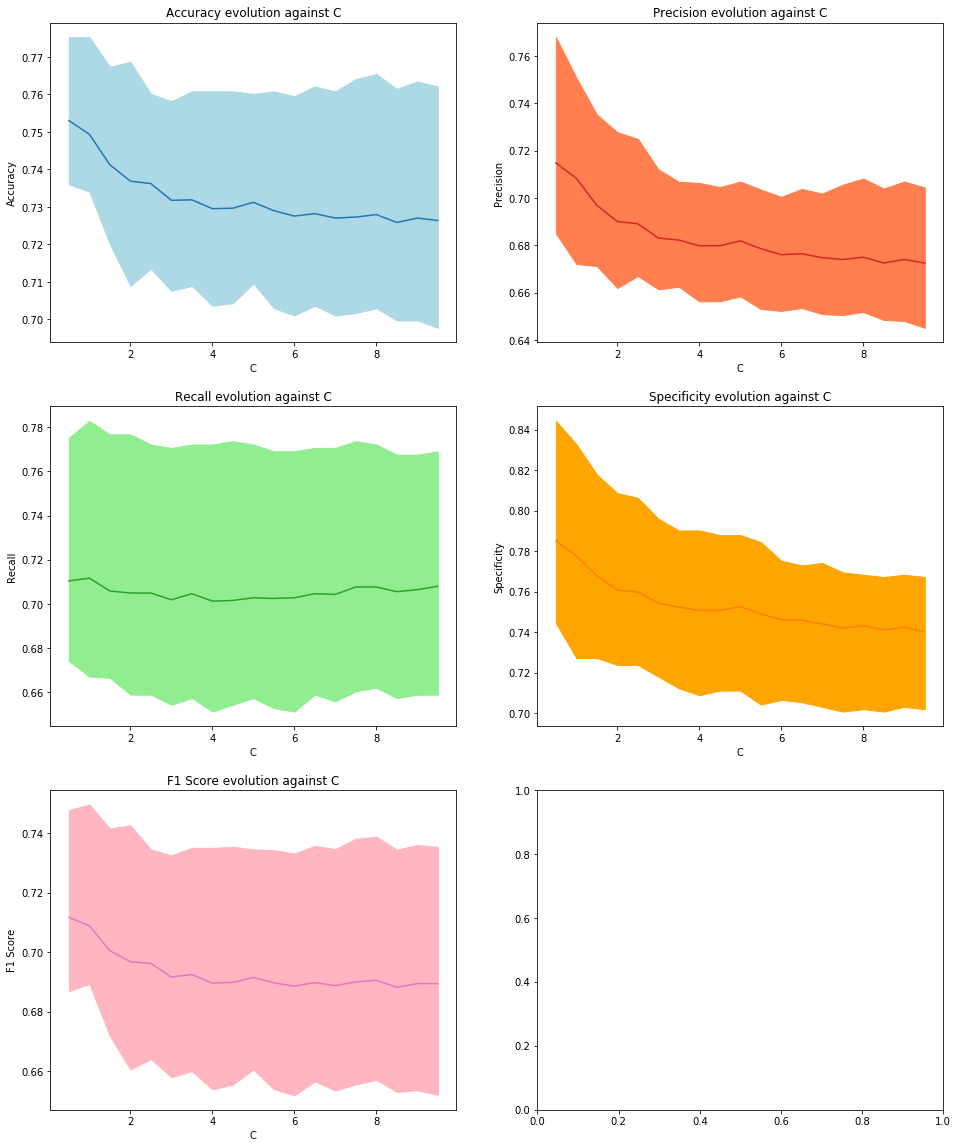

(<Figure size 1152x1440 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f526012d3c8>,
       dtype=object))

In [19]:
plot_performance(smv_lin_rbf_perf_metrics[smv_lin_rbf_perf_metrics['kernel']=='linear'], param='C')

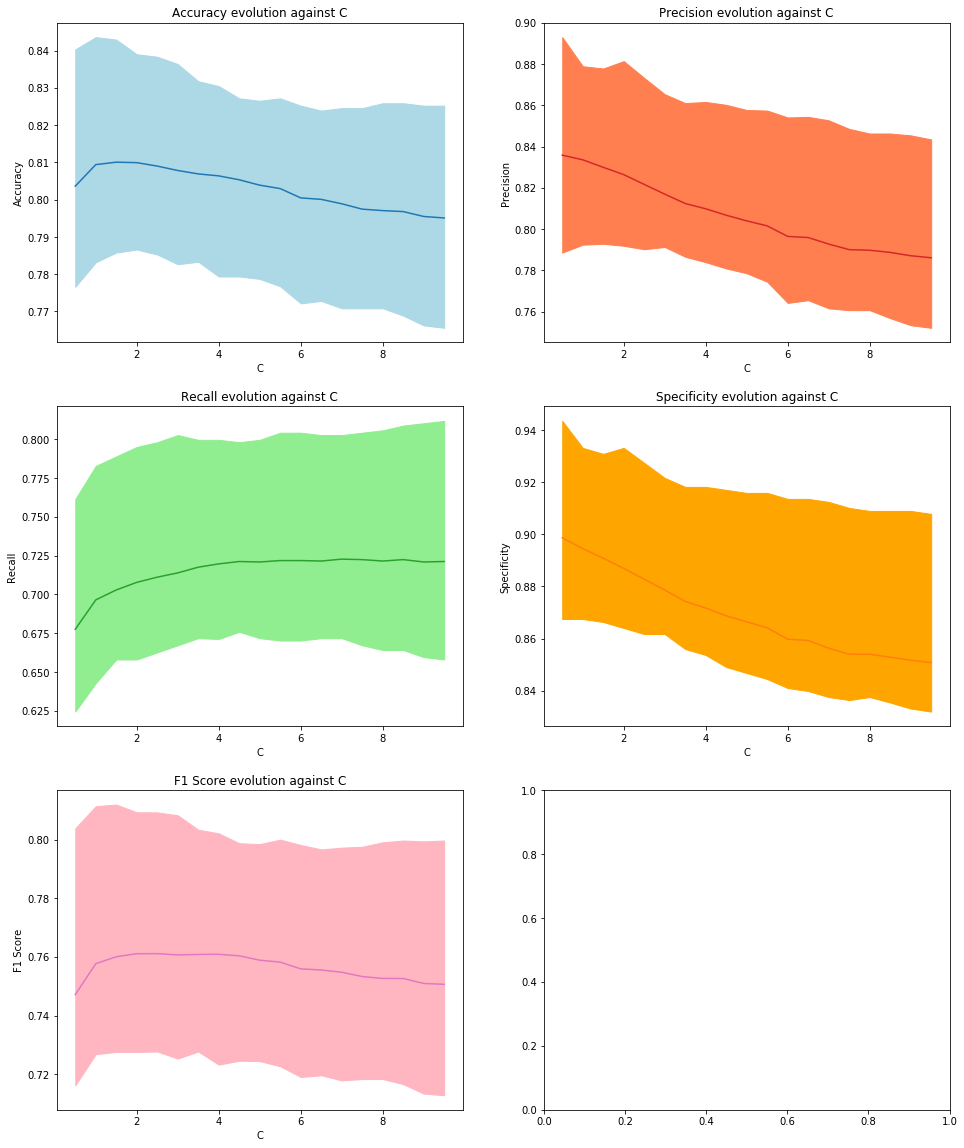

(<Figure size 1152x1440 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f52240dfcc0>,
       dtype=object))

In [20]:
plot_performance(smv_lin_rbf_perf_metrics[smv_lin_rbf_perf_metrics['kernel']=='rbf'], param='C')

In [21]:
smv_lin_rbf_perf_metrics.to_csv('smv_lin_rbf_perf_metrics_BERT_hyb_appr.csv', sep=';')

### Neural Networks

Fit models based on Multilayer Perceptro models

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import GlorotUniform

In [4]:
def build_MLP_network(input_dim, layers_dim: tuple, dropout=0.1, lr=1e-4, inner_act_func='relu', out_act_func='sigmoid', seed=10):
    
    if isinstance(dropout, (float, int)):
        dropout = (dropout,) * len(layers_dim)
    
    # Input
    input_layer = Input(shape=(input_dim,), dtype='float32')
    prev_lay = input_layer
    
    # Add intern fully-connected layers
    for i in range(len(layers_dim)):
        fully_lay = Dense(layers_dim[i], activation='relu',
                          kernel_initializer=GlorotUniform(seed=seed))(prev_lay)
        drop_layer = Dropout(dropout[i])(fully_lay)
        prev_lay = drop_layer
    
    # Add classification output layer
    output_layer = Dense(1, activation='sigmoid',
                        kernel_initializer=GlorotUniform(seed=seed))(prev_lay)
    
    # Builad & compile model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
    model.optimizer.lr = lr
    
    return model

Firstly, grid over neural networks different architectures

In [5]:
def mulspace_limits(begin, end, factor):
    x = begin
    
    while x <= end:
        yield x
        x *= factor

In [10]:
# Configuration with only 1 hidden layer
one_hidden_lay_conf = [[x] for x in mulspace_limits(32, X_train_vect.shape[1], 2)]

# Configuration with 2 hidden layers
two_hidden_lay_conf = [[x[0], y] for x in one_hidden_lay_conf[1:] for y in mulspace_limits(32, x[0], 2)]

# Grid parameters
params = {
        'lay_conf': one_hidden_lay_conf + two_hidden_lay_conf,
        'lr': [1e-4],
        'dropout': [0.1],
        'max_epochs': [300],
        'batch_size': [100],
        'seed': [123456]
    }

In [26]:
params

{'lay_conf': [[32],
  [64],
  [128],
  [256],
  [512],
  [1024],
  [64, 32],
  [64, 64],
  [128, 32],
  [128, 64],
  [128, 128],
  [256, 32],
  [256, 64],
  [256, 128],
  [256, 256],
  [512, 32],
  [512, 64],
  [512, 128],
  [512, 256],
  [512, 512],
  [1024, 32],
  [1024, 64],
  [1024, 128],
  [1024, 256],
  [1024, 512],
  [1024, 1024]],
 'lr': [0.0001],
 'dropout': [0.1],
 'max_epochs': [300],
 'batch_size': [100],
 'seed': [123456]}

Perform experiments by griding parameters above. Simple one-hot validation will be used

In [9]:
def make_MLP_exp(X, y, params, val_split=0.1, test_size=0.2):

    mlp_perf_metrics = []

    # Split train and test sets in a single one-shot validation
    X_train_part, X_test_part, y_train_part, y_test_part = train_test_split(X, y, test_size=test_size)

    for param in ParameterGrid(params):

        meta = {
            'n_layers': len(param['lay_conf']), #if isinstance(conf, list) else 1
            'layer_conf': param['lay_conf'],
            'lr': param['lr'],
            'dropout': param['dropout'],
            'batch_size': param['batch_size']
        }

        print('Training with parameters {}'.format(param))

        # Fit MLP
        mlp_model = build_MLP_network(input_dim=X.shape[1],
                                      layers_dim=param['lay_conf'],
                                      dropout=param['dropout'], lr=param['lr'],
                                      seed=param['seed'],
                                      inner_act_func=param['inner_act_func'] if 'inner_act_func' in param else 'relu',
                                      out_act_func=param['out_act_func'] if 'out_act_func' in param else 'sigmoid')
        mlp_model.summary()
        hist = mlp_model.fit(X_train_part, y_train_part,
                             batch_size=param['batch_size'],
                             epochs=param['max_epochs'],
                              validation_split=val_split,
                              callbacks=[EarlyStopping(monitor='val_loss', patience=5,
                                                       restore_best_weights=True,
                                                      min_delta=1e-7)])

        # Add train & val metrics
        meta['accuracy_train'] = hist.history['acc'][-1]
        meta['accuracy_val'] = hist.history['val_acc'][-1]
        meta['loss_train'] = hist.history['loss'][-1]
        meta['loss_val'] = hist.history['val_loss'][-1]
        meta['epochs'] = len(hist.history['val_loss'])

        # Predict over test
        y_pred = mlp_model.predict(X_test_part)
        y_pred[y_pred >= 0.5] = 1
        y_pred[y_pred < 0.5] = 0
        y_pred = y_pred.squeeze().astype('int8')

        # Meassure performance metrics
        meta['accuracy'] = metrics.accuracy_score(y_test_part, y_pred)
        meta['precision'] = metrics.precision_score(y_test_part, y_pred)
        meta['recall'] = metrics.recall_score(y_test_part, y_pred)
        #  Exchange class 1 and 0 so measure recall for class 0 (specificity)
        meta['specificity'] = metrics.recall_score(np.abs(y_test_part-1), np.abs(y_pred-1))
        meta['f1_score'] = metrics.f1_score(y_test_part, y_pred)

        mlp_perf_metrics.append(meta)

    mlp_perf_metrics = pd.DataFrame(mlp_perf_metrics)
    return mlp_perf_metrics

In [28]:
mlp_perf_metrics1 = make_MLP_exp(X_train_vect, y_train.values, params)

Training with parameters {'batch_size': 100, 'dropout': 0.1, 'lay_conf': [32], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1536)]            0         
_________________________________________________________________
dense (Dense)                (None, 32)                49184     
_________________________________________________________________
dropout_37 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 49,217
Trainable params: 49,217
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
55/55 [==============================] - 1s 7ms/step - loss: 0.6452 - acc: 0.6267 - val_loss: 0.6027 - val_acc: 0

55/55 [==============================] - 0s 5ms/step - loss: 0.3616 - acc: 0.8471 - val_loss: 0.4386 - val_acc: 0.7849
Training with parameters {'batch_size': 100, 'dropout': 0.1, 'lay_conf': [128], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1536)]            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               196736    
_________________________________________________________________
dropout_39 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 196,865
Trainable params: 196,865
Non-trainable params: 0
_________________________________________________________________
Epo

Epoch 25/300
55/55 [==============================] - 0s 6ms/step - loss: 0.3750 - acc: 0.8407 - val_loss: 0.4449 - val_acc: 0.7849
Epoch 26/300
55/55 [==============================] - 0s 6ms/step - loss: 0.3754 - acc: 0.8387 - val_loss: 0.4495 - val_acc: 0.7865
Epoch 27/300
55/55 [==============================] - 0s 8ms/step - loss: 0.3749 - acc: 0.8371 - val_loss: 0.4629 - val_acc: 0.7882
Epoch 28/300
55/55 [==============================] - 0s 8ms/step - loss: 0.3708 - acc: 0.8402 - val_loss: 0.4448 - val_acc: 0.7882
Epoch 29/300
55/55 [==============================] - 0s 8ms/step - loss: 0.3736 - acc: 0.8387 - val_loss: 0.4499 - val_acc: 0.7947
Training with parameters {'batch_size': 100, 'dropout': 0.1, 'lay_conf': [512], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1536)]            0      

Epoch 1/300
55/55 [==============================] - 1s 5ms/step - loss: 0.6655 - acc: 0.6004 - val_loss: 0.6102 - val_acc: 0.7126
Epoch 2/300
55/55 [==============================] - 0s 2ms/step - loss: 0.5995 - acc: 0.6887 - val_loss: 0.5539 - val_acc: 0.7291
Epoch 3/300
55/55 [==============================] - 0s 6ms/step - loss: 0.5542 - acc: 0.7272 - val_loss: 0.5223 - val_acc: 0.7521
Epoch 4/300
55/55 [==============================] - 0s 6ms/step - loss: 0.5194 - acc: 0.7648 - val_loss: 0.5068 - val_acc: 0.7619
Epoch 5/300
55/55 [==============================] - 0s 5ms/step - loss: 0.5026 - acc: 0.7641 - val_loss: 0.4964 - val_acc: 0.7603
Epoch 6/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4856 - acc: 0.7820 - val_loss: 0.4885 - val_acc: 0.7586
Epoch 7/300
55/55 [==============================] - 0s 5ms/step - loss: 0.4711 - acc: 0.7895 - val_loss: 0.4818 - val_acc: 0.7701
Epoch 8/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4711 - a

55/55 [==============================] - 1s 5ms/step - loss: 0.6590 - acc: 0.6138 - val_loss: 0.5918 - val_acc: 0.7258
Epoch 2/300
55/55 [==============================] - 0s 4ms/step - loss: 0.5749 - acc: 0.7150 - val_loss: 0.5354 - val_acc: 0.7570
Epoch 3/300
55/55 [==============================] - 0s 6ms/step - loss: 0.5185 - acc: 0.7595 - val_loss: 0.5151 - val_acc: 0.7619
Epoch 4/300
55/55 [==============================] - 0s 7ms/step - loss: 0.4908 - acc: 0.7761 - val_loss: 0.4939 - val_acc: 0.7767
Epoch 5/300
55/55 [==============================] - 0s 7ms/step - loss: 0.4678 - acc: 0.7926 - val_loss: 0.4844 - val_acc: 0.7800
Epoch 6/300
55/55 [==============================] - 0s 7ms/step - loss: 0.4529 - acc: 0.8009 - val_loss: 0.4778 - val_acc: 0.7734
Epoch 7/300
55/55 [==============================] - 0s 7ms/step - loss: 0.4469 - acc: 0.8020 - val_loss: 0.4706 - val_acc: 0.7833
Epoch 8/300
55/55 [==============================] - 0s 7ms/step - loss: 0.4397 - acc: 0.8103 -

Epoch 7/300
55/55 [==============================] - 1s 10ms/step - loss: 0.4399 - acc: 0.8061 - val_loss: 0.4716 - val_acc: 0.7865
Epoch 8/300
55/55 [==============================] - 1s 10ms/step - loss: 0.4324 - acc: 0.8075 - val_loss: 0.4668 - val_acc: 0.7849
Epoch 9/300
55/55 [==============================] - 1s 10ms/step - loss: 0.4243 - acc: 0.8141 - val_loss: 0.4572 - val_acc: 0.7783
Epoch 10/300
55/55 [==============================] - 1s 10ms/step - loss: 0.4225 - acc: 0.8152 - val_loss: 0.4538 - val_acc: 0.7849
Epoch 11/300
55/55 [==============================] - 1s 10ms/step - loss: 0.4165 - acc: 0.8186 - val_loss: 0.4506 - val_acc: 0.7849
Epoch 12/300
55/55 [==============================] - 1s 9ms/step - loss: 0.4078 - acc: 0.8309 - val_loss: 0.4717 - val_acc: 0.7783
Epoch 13/300
55/55 [==============================] - 1s 10ms/step - loss: 0.4092 - acc: 0.8245 - val_loss: 0.4553 - val_acc: 0.7898
Epoch 14/300
55/55 [==============================] - 1s 11ms/step - loss

55/55 [==============================] - 1s 8ms/step - loss: 0.6707 - acc: 0.6211 - val_loss: 0.5847 - val_acc: 0.7340
Epoch 2/300
55/55 [==============================] - 0s 9ms/step - loss: 0.5616 - acc: 0.7282 - val_loss: 0.5376 - val_acc: 0.7603
Epoch 3/300
55/55 [==============================] - 1s 12ms/step - loss: 0.5130 - acc: 0.7628 - val_loss: 0.5021 - val_acc: 0.7701
Epoch 4/300
55/55 [==============================] - 1s 12ms/step - loss: 0.4844 - acc: 0.7822 - val_loss: 0.5047 - val_acc: 0.7783
Epoch 5/300
55/55 [==============================] - 1s 12ms/step - loss: 0.4644 - acc: 0.7929 - val_loss: 0.4753 - val_acc: 0.7718
Epoch 6/300
55/55 [==============================] - 1s 13ms/step - loss: 0.4525 - acc: 0.8008 - val_loss: 0.4736 - val_acc: 0.7783
Epoch 7/300
55/55 [==============================] - 1s 12ms/step - loss: 0.4413 - acc: 0.8046 - val_loss: 0.4644 - val_acc: 0.7800
Epoch 8/300
55/55 [==============================] - 1s 12ms/step - loss: 0.4338 - acc: 0.

55/55 [==============================] - 1s 15ms/step - loss: 0.4023 - acc: 0.8223 - val_loss: 0.4498 - val_acc: 0.7849
Epoch 11/300
55/55 [==============================] - 1s 14ms/step - loss: 0.3968 - acc: 0.8301 - val_loss: 0.4563 - val_acc: 0.7849
Epoch 12/300
55/55 [==============================] - 1s 15ms/step - loss: 0.3943 - acc: 0.8290 - val_loss: 0.4495 - val_acc: 0.7800
Epoch 13/300
55/55 [==============================] - 1s 15ms/step - loss: 0.3902 - acc: 0.8307 - val_loss: 0.4573 - val_acc: 0.7816
Epoch 14/300
55/55 [==============================] - 1s 15ms/step - loss: 0.3857 - acc: 0.8312 - val_loss: 0.4513 - val_acc: 0.7849
Epoch 15/300
55/55 [==============================] - 1s 14ms/step - loss: 0.3810 - acc: 0.8320 - val_loss: 0.4475 - val_acc: 0.7833
Epoch 16/300
55/55 [==============================] - 1s 15ms/step - loss: 0.3778 - acc: 0.8378 - val_loss: 0.4472 - val_acc: 0.7882
Epoch 17/300
55/55 [==============================] - 1s 15ms/step - loss: 0.3669 

55/55 [==============================] - 1s 21ms/step - loss: 0.3929 - acc: 0.8289 - val_loss: 0.4453 - val_acc: 0.7783
Epoch 13/300
55/55 [==============================] - 1s 21ms/step - loss: 0.3962 - acc: 0.8267 - val_loss: 0.4538 - val_acc: 0.7898
Epoch 14/300
55/55 [==============================] - 1s 21ms/step - loss: 0.3802 - acc: 0.8387 - val_loss: 0.4822 - val_acc: 0.7865
Epoch 15/300
55/55 [==============================] - 1s 21ms/step - loss: 0.3811 - acc: 0.8371 - val_loss: 0.4626 - val_acc: 0.8013
Epoch 16/300
55/55 [==============================] - 1s 21ms/step - loss: 0.3793 - acc: 0.8371 - val_loss: 0.4444 - val_acc: 0.7849
Epoch 17/300
55/55 [==============================] - 1s 21ms/step - loss: 0.3704 - acc: 0.8407 - val_loss: 0.4628 - val_acc: 0.7964
Epoch 18/300
55/55 [==============================] - 1s 21ms/step - loss: 0.3662 - acc: 0.8416 - val_loss: 0.4403 - val_acc: 0.7833
Epoch 19/300
55/55 [==============================] - 1s 21ms/step - loss: 0.3511 

In [29]:
mlp_perf_metrics1

,n_layers,layer_conf,lr,dropout,batch_size,accuracy_train,accuracy_val,loss_train,loss_val,epochs,accuracy,precision,recall,specificity,f1_score
0,1,[32],0.0001,0.1,100,0.844554,0.781609,0.363405,0.449858,56,0.826658,0.832168,0.739130,0.890785,0.782895
1,1,[64],0.0001,0.1,100,0.847108,0.784893,0.361574,0.438552,53,0.818779,0.807692,0.750000,0.869170,0.777778
2,1,[128],0.0001,0.1,100,0.829958,0.788177,0.394843,0.464468,22,0.824688,0.811570,0.762422,0.870307,0.786229
3,1,[256],0.0001,0.1,100,0.838716,0.794746,0.373633,0.449875,29,0.824032,0.818644,0.750000,0.878271,0.782820
4,1,[512],0.0001,0.1,100,0.851852,0.796387,0.352098,0.440152,30,0.826658,0.832168,0.739130,0.890785,0.782895
5,1,[1024],0.0001,0.1,100,0.841817,0.799672,0.362611,0.443228,21,0.820749,0.808652,0.754658,0.869170,0.780723
6,2,"[64, 32]",0.0001,0.1,100,0.835796,0.789819,0.387205,0.449558,35,0.823375,0.829525,0.732919,0.889647,0.778236
7,2,"[64, 64]",0.0001,0.1,100,0.835249,0.783251,0.385654,0.454196,32,0.820749,0.805601,0.759317,0.865757,0.781775
8,2,"[128, 32]",0.0001,0.1,100,0.833607,0.783251,0.377478,0.448806,35,0.828628,0.851376,0.720497,0.907850,0.780488
9,2,"[128, 64]",0.0001,0.1,100,0.843642,0.793103,0.365142,0.459225,30,0.827315,0.844485,0.725155,0.902162,0.780284


Analyze better models

In [30]:
mlp_perf_metrics1.nlargest(5, 'accuracy')

,n_layers,layer_conf,lr,dropout,batch_size,accuracy_train,accuracy_val,loss_train,loss_val,epochs,accuracy,precision,recall,specificity,f1_score
10,2,"[128, 128]",0.0001,0.1,100,0.834154,0.784893,0.391073,0.464519,18,0.833224,0.836207,0.753106,0.891923,0.792484
22,2,"[1024, 128]",0.0001,0.1,100,0.864623,0.794746,0.311344,0.450329,28,0.831911,0.831058,0.756211,0.887372,0.791870
12,2,"[256, 64]",0.0001,0.1,100,0.848385,0.798030,0.357380,0.442481,33,0.830598,0.842199,0.737578,0.898749,0.786424
21,2,"[1024, 64]",0.0001,0.1,100,0.832147,0.778325,0.381911,0.498012,15,0.830598,0.862782,0.712733,0.916951,0.780612
20,2,"[1024, 32]",0.0001,0.1,100,0.848203,0.783251,0.362140,0.449561,19,0.829284,0.846570,0.728261,0.903299,0.782972


In [31]:
mlp_perf_metrics1.nlargest(5, 'f1_score')

,n_layers,layer_conf,lr,dropout,batch_size,accuracy_train,accuracy_val,loss_train,loss_val,epochs,accuracy,precision,recall,specificity,f1_score
10,2,"[128, 128]",0.0001,0.1,100,0.834154,0.784893,0.391073,0.464519,18,0.833224,0.836207,0.753106,0.891923,0.792484
22,2,"[1024, 128]",0.0001,0.1,100,0.864623,0.794746,0.311344,0.450329,28,0.831911,0.831058,0.756211,0.887372,0.791870
19,2,"[512, 512]",0.0001,0.1,100,0.869914,0.789819,0.311703,0.458912,26,0.825345,0.800000,0.782609,0.856655,0.791209
11,2,"[256, 32]",0.0001,0.1,100,0.855501,0.793103,0.338728,0.453931,38,0.826001,0.804173,0.777950,0.861206,0.790845
23,2,"[1024, 256]",0.0001,0.1,100,0.857325,0.801314,0.340982,0.441352,20,0.826001,0.805153,0.776398,0.862344,0.790514


Gird over batch size by using the best architectures

In [10]:
best_arch = [[128, 128],
             [1024, 128],
             [256, 64],
             [1024, 64],
             [1024, 32],
             [512, 512],
             [256, 32],
             [1024, 256]]

params2 = {
        'lay_conf': best_arch,
        'lr': [1e-4],
        'dropout': [0.1],
        'max_epochs': [300],
        'batch_size': [None, 1, 10, 32, 64, 70, 100, 150, 200, 350,
                       500, 700, 1000, 1100, 1250, 1500, 2000, 2500,
                       3000, 4000, 5000],
        'seed': [123456]
    }

In [11]:
mlp_perf_metrics2 = make_MLP_exp(X_train_vect, y_train.values, params2)

Training with parameters {'batch_size': None, 'dropout': 0.1, 'lay_conf': [128, 128], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1536)]            0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129

172/172 [==============================] - 1s 7ms/step - loss: 0.3943 - acc: 0.8269 - val_loss: 0.4290 - val_acc: 0.8062
Epoch 15/300
172/172 [==============================] - 1s 6ms/step - loss: 0.3841 - acc: 0.8351 - val_loss: 0.3832 - val_acc: 0.8456
Epoch 16/300
172/172 [==============================] - 1s 6ms/step - loss: 0.3760 - acc: 0.8325 - val_loss: 0.3638 - val_acc: 0.8506
Epoch 17/300
172/172 [==============================] - 1s 6ms/step - loss: 0.3723 - acc: 0.8440 - val_loss: 0.3685 - val_acc: 0.8440
Training with parameters {'batch_size': None, 'dropout': 0.1, 'lay_conf': [512, 512], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1536)]            0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               786944

Epoch 1/300
172/172 [==============================] - 1s 6ms/step - loss: 0.5754 - acc: 0.7052 - val_loss: 0.4351 - val_acc: 0.8276
Epoch 2/300
172/172 [==============================] - 1s 6ms/step - loss: 0.4874 - acc: 0.7708 - val_loss: 0.3967 - val_acc: 0.8440
Epoch 3/300
172/172 [==============================] - 1s 6ms/step - loss: 0.4549 - acc: 0.7982 - val_loss: 0.4206 - val_acc: 0.8276
Epoch 4/300
172/172 [==============================] - 1s 6ms/step - loss: 0.4504 - acc: 0.7964 - val_loss: 0.3976 - val_acc: 0.8424
Epoch 5/300
172/172 [==============================] - 1s 6ms/step - loss: 0.4236 - acc: 0.8108 - val_loss: 0.3790 - val_acc: 0.8522
Epoch 6/300
172/172 [==============================] - 1s 6ms/step - loss: 0.4161 - acc: 0.8126 - val_loss: 0.3901 - val_acc: 0.8456
Epoch 7/300
172/172 [==============================] - 1s 6ms/step - loss: 0.4088 - acc: 0.8214 - val_loss: 0.3791 - val_acc: 0.8473
Epoch 8/300
172/172 [==============================] - 1s 6ms/step - 

5481/5481 [==============================] - 22s 4ms/step - loss: 0.5582 - acc: 0.7185 - val_loss: 0.4737 - val_acc: 0.7816
Epoch 2/300
5481/5481 [==============================] - 22s 4ms/step - loss: 0.4796 - acc: 0.7854 - val_loss: 0.4663 - val_acc: 0.7734
Epoch 3/300
5481/5481 [==============================] - 22s 4ms/step - loss: 0.4559 - acc: 0.7960 - val_loss: 0.4018 - val_acc: 0.8342
Epoch 4/300
5481/5481 [==============================] - 22s 4ms/step - loss: 0.4412 - acc: 0.8024 - val_loss: 0.3914 - val_acc: 0.8440
Epoch 5/300
5481/5481 [==============================] - 21s 4ms/step - loss: 0.4301 - acc: 0.8112 - val_loss: 0.4035 - val_acc: 0.8309
Epoch 6/300
5481/5481 [==============================] - 22s 4ms/step - loss: 0.4267 - acc: 0.8139 - val_loss: 0.5049 - val_acc: 0.7750
Epoch 7/300
5481/5481 [==============================] - 22s 4ms/step - loss: 0.4154 - acc: 0.8216 - val_loss: 0.3934 - val_acc: 0.8424
Epoch 8/300
5481/5481 [==============================] - 22s

549/549 [==============================] - 3s 5ms/step - loss: 0.3749 - acc: 0.8374 - val_loss: 0.3679 - val_acc: 0.8440
Epoch 16/300
549/549 [==============================] - 3s 5ms/step - loss: 0.3727 - acc: 0.8374 - val_loss: 0.3780 - val_acc: 0.8489
Epoch 17/300
549/549 [==============================] - 3s 5ms/step - loss: 0.3677 - acc: 0.8373 - val_loss: 0.3877 - val_acc: 0.8473
Epoch 18/300
549/549 [==============================] - 3s 5ms/step - loss: 0.3564 - acc: 0.8486 - val_loss: 0.3698 - val_acc: 0.8440
Epoch 19/300
549/549 [==============================] - 3s 5ms/step - loss: 0.3598 - acc: 0.8384 - val_loss: 0.3636 - val_acc: 0.8506
Training with parameters {'batch_size': 10, 'dropout': 0.1, 'lay_conf': [256, 64], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 1536)]            0     

549/549 [==============================] - 3s 5ms/step - loss: 0.5634 - acc: 0.7125 - val_loss: 0.5580 - val_acc: 0.6782
Epoch 2/300
549/549 [==============================] - 3s 5ms/step - loss: 0.4845 - acc: 0.7721 - val_loss: 0.4018 - val_acc: 0.8243
Epoch 3/300
549/549 [==============================] - 3s 5ms/step - loss: 0.4622 - acc: 0.7962 - val_loss: 0.4463 - val_acc: 0.8144
Epoch 4/300
549/549 [==============================] - 3s 5ms/step - loss: 0.4553 - acc: 0.7991 - val_loss: 0.3746 - val_acc: 0.8374
Epoch 5/300
549/549 [==============================] - 3s 5ms/step - loss: 0.4400 - acc: 0.8009 - val_loss: 0.3669 - val_acc: 0.8588
Epoch 6/300
549/549 [==============================] - 3s 5ms/step - loss: 0.4361 - acc: 0.8124 - val_loss: 0.3782 - val_acc: 0.8391
Epoch 7/300
549/549 [==============================] - 3s 5ms/step - loss: 0.4253 - acc: 0.8135 - val_loss: 0.3788 - val_acc: 0.8539
Epoch 8/300
549/549 [==============================] - 3s 5ms/step - loss: 0.4254

Epoch 1/300
172/172 [==============================] - 1s 6ms/step - loss: 0.5800 - acc: 0.6995 - val_loss: 0.4449 - val_acc: 0.8194
Epoch 2/300
172/172 [==============================] - 1s 5ms/step - loss: 0.4876 - acc: 0.7674 - val_loss: 0.4094 - val_acc: 0.8325
Epoch 3/300
172/172 [==============================] - 1s 6ms/step - loss: 0.4584 - acc: 0.7949 - val_loss: 0.4943 - val_acc: 0.7849
Epoch 4/300
172/172 [==============================] - 1s 6ms/step - loss: 0.4536 - acc: 0.7980 - val_loss: 0.3875 - val_acc: 0.8440
Epoch 5/300
172/172 [==============================] - 1s 6ms/step - loss: 0.4278 - acc: 0.8062 - val_loss: 0.3781 - val_acc: 0.8588
Epoch 6/300
172/172 [==============================] - 1s 6ms/step - loss: 0.4190 - acc: 0.8183 - val_loss: 0.4098 - val_acc: 0.8309
Epoch 7/300
172/172 [==============================] - 1s 6ms/step - loss: 0.4146 - acc: 0.8199 - val_loss: 0.3830 - val_acc: 0.8424
Epoch 8/300
172/172 [==============================] - 1s 6ms/step - 

172/172 [==============================] - 1s 5ms/step - loss: 0.3873 - acc: 0.8301 - val_loss: 0.4909 - val_acc: 0.7488
Epoch 12/300
172/172 [==============================] - 1s 5ms/step - loss: 0.3780 - acc: 0.8343 - val_loss: 0.3745 - val_acc: 0.8489
Epoch 13/300
172/172 [==============================] - 1s 6ms/step - loss: 0.3767 - acc: 0.8305 - val_loss: 0.4330 - val_acc: 0.7947
Training with parameters {'batch_size': 32, 'dropout': 0.1, 'lay_conf': [256, 32], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 1536)]            0         
_________________________________________________________________
dense_90 (Dense)             (None, 256)               393472    
_________________________________________________________________
dropout_60 (Dropout)         (None, 256)               0         

Epoch 10/300
86/86 [==============================] - 1s 6ms/step - loss: 0.4092 - acc: 0.8219 - val_loss: 0.3737 - val_acc: 0.8489
Epoch 11/300
86/86 [==============================] - 1s 6ms/step - loss: 0.4055 - acc: 0.8197 - val_loss: 0.3812 - val_acc: 0.8440
Epoch 12/300
86/86 [==============================] - 1s 6ms/step - loss: 0.3962 - acc: 0.8254 - val_loss: 0.3804 - val_acc: 0.8473
Epoch 13/300
86/86 [==============================] - 1s 6ms/step - loss: 0.3931 - acc: 0.8311 - val_loss: 0.4115 - val_acc: 0.8276
Epoch 14/300
86/86 [==============================] - 1s 6ms/step - loss: 0.3833 - acc: 0.8334 - val_loss: 0.3727 - val_acc: 0.8571
Epoch 15/300
86/86 [==============================] - 1s 6ms/step - loss: 0.3744 - acc: 0.8338 - val_loss: 0.4211 - val_acc: 0.8342
Epoch 16/300
86/86 [==============================] - 1s 6ms/step - loss: 0.3729 - acc: 0.8385 - val_loss: 0.3815 - val_acc: 0.8440
Epoch 17/300
86/86 [==============================] - 1s 6ms/step - loss: 0.

Epoch 14/300
86/86 [==============================] - 1s 6ms/step - loss: 0.3801 - acc: 0.8369 - val_loss: 0.3768 - val_acc: 0.8440
Epoch 15/300
86/86 [==============================] - 1s 6ms/step - loss: 0.3940 - acc: 0.8188 - val_loss: 0.4037 - val_acc: 0.8342
Training with parameters {'batch_size': 64, 'dropout': 0.1, 'lay_conf': [1024, 32], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 1536)]            0         
_________________________________________________________________
dense_108 (Dense)            (None, 1024)              1573888   
_________________________________________________________________
dropout_72 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_109 (Dense)            (None, 32)                32

Epoch 20/300
86/86 [==============================] - 1s 6ms/step - loss: 0.3407 - acc: 0.8504 - val_loss: 0.4073 - val_acc: 0.8112
Epoch 21/300
86/86 [==============================] - 1s 6ms/step - loss: 0.3307 - acc: 0.8612 - val_loss: 0.3877 - val_acc: 0.8391
Training with parameters {'batch_size': 64, 'dropout': 0.1, 'lay_conf': [256, 32], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 1536)]            0         
_________________________________________________________________
dense_114 (Dense)            (None, 256)               393472    
_________________________________________________________________
dropout_76 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_115 (Dense)            (None, 32)                822

Epoch 16/300
86/86 [==============================] - 1s 6ms/step - loss: 0.3556 - acc: 0.8458 - val_loss: 0.4351 - val_acc: 0.8013
Epoch 17/300
86/86 [==============================] - 1s 6ms/step - loss: 0.3575 - acc: 0.8404 - val_loss: 0.3711 - val_acc: 0.8440
Epoch 18/300
86/86 [==============================] - 1s 6ms/step - loss: 0.3501 - acc: 0.8482 - val_loss: 0.3894 - val_acc: 0.8342
Epoch 19/300
86/86 [==============================] - 1s 6ms/step - loss: 0.3394 - acc: 0.8531 - val_loss: 0.3964 - val_acc: 0.8424
Training with parameters {'batch_size': 70, 'dropout': 0.1, 'lay_conf': [128, 128], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 1536)]            0         
_________________________________________________________________
dense_120 (Dense)            (None, 128)               19

Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 1536)]            0         
_________________________________________________________________
dense_126 (Dense)            (None, 256)               393472    
_________________________________________________________________
dropout_84 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_127 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_85 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_128 (Dense)            (None, 1)                 65        
Total params: 409,985
Trainable params: 409,985
Non-trainable params: 0
____________________________________________________

Epoch 23/300
79/79 [==============================] - 0s 6ms/step - loss: 0.3491 - acc: 0.8458 - val_loss: 0.3763 - val_acc: 0.8473
Training with parameters {'batch_size': 70, 'dropout': 0.1, 'lay_conf': [1024, 32], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, 1536)]            0         
_________________________________________________________________
dense_132 (Dense)            (None, 1024)              1573888   
_________________________________________________________________
dropout_88 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_133 (Dense)            (None, 32)                32800     
_________________________________________________________________
dropout_89 (Dropout)         (None, 32)                0 

Epoch 1/300
79/79 [==============================] - 1s 5ms/step - loss: 0.6663 - acc: 0.6068 - val_loss: 0.5663 - val_acc: 0.7586
Epoch 2/300
79/79 [==============================] - 0s 5ms/step - loss: 0.5767 - acc: 0.7172 - val_loss: 0.4943 - val_acc: 0.7997
Epoch 3/300
79/79 [==============================] - 0s 6ms/step - loss: 0.5240 - acc: 0.7566 - val_loss: 0.4867 - val_acc: 0.7833
Epoch 4/300
79/79 [==============================] - 0s 6ms/step - loss: 0.4942 - acc: 0.7683 - val_loss: 0.4340 - val_acc: 0.8177
Epoch 5/300
79/79 [==============================] - 0s 6ms/step - loss: 0.4721 - acc: 0.7889 - val_loss: 0.4394 - val_acc: 0.8062
Epoch 6/300
79/79 [==============================] - 0s 6ms/step - loss: 0.4650 - acc: 0.7867 - val_loss: 0.4005 - val_acc: 0.8374
Epoch 7/300
79/79 [==============================] - 0s 6ms/step - loss: 0.4501 - acc: 0.7995 - val_loss: 0.4026 - val_acc: 0.8407
Epoch 8/300
79/79 [==============================] - 0s 6ms/step - loss: 0.4413 - a

Epoch 2/300
55/55 [==============================] - 0s 4ms/step - loss: 0.5814 - acc: 0.7123 - val_loss: 0.5031 - val_acc: 0.7783
Epoch 3/300
55/55 [==============================] - 0s 6ms/step - loss: 0.5304 - acc: 0.7524 - val_loss: 0.4642 - val_acc: 0.8177
Epoch 4/300
55/55 [==============================] - 0s 6ms/step - loss: 0.5029 - acc: 0.7738 - val_loss: 0.4353 - val_acc: 0.8309
Epoch 5/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4832 - acc: 0.7763 - val_loss: 0.4223 - val_acc: 0.8259
Epoch 6/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4677 - acc: 0.7871 - val_loss: 0.4083 - val_acc: 0.8342
Epoch 7/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4590 - acc: 0.7986 - val_loss: 0.4039 - val_acc: 0.8391
Epoch 8/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4490 - acc: 0.8037 - val_loss: 0.4025 - val_acc: 0.8424
Epoch 9/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4415 - a

Epoch 5/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4994 - acc: 0.7685 - val_loss: 0.4313 - val_acc: 0.8358
Epoch 6/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4727 - acc: 0.7864 - val_loss: 0.4220 - val_acc: 0.8194
Epoch 7/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4651 - acc: 0.7955 - val_loss: 0.4157 - val_acc: 0.8292
Epoch 8/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4557 - acc: 0.7949 - val_loss: 0.4099 - val_acc: 0.8358
Epoch 9/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4444 - acc: 0.8033 - val_loss: 0.4116 - val_acc: 0.8243
Epoch 10/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4408 - acc: 0.8031 - val_loss: 0.3951 - val_acc: 0.8424
Epoch 11/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4369 - acc: 0.8046 - val_loss: 0.3965 - val_acc: 0.8407
Epoch 12/300
55/55 [==============================] - 0s 6ms/step - loss: 0.4308 

Epoch 22/300
55/55 [==============================] - 0s 6ms/step - loss: 0.3421 - acc: 0.8517 - val_loss: 0.3746 - val_acc: 0.8473
Epoch 23/300
55/55 [==============================] - 0s 6ms/step - loss: 0.3314 - acc: 0.8564 - val_loss: 0.3731 - val_acc: 0.8522
Training with parameters {'batch_size': 100, 'dropout': 0.1, 'lay_conf': [256, 32], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        [(None, 1536)]            0         
_________________________________________________________________
dense_162 (Dense)            (None, 256)               393472    
_________________________________________________________________
dropout_108 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_163 (Dense)            (None, 32)                82

Epoch 1/300
37/37 [==============================] - 0s 6ms/step - loss: 0.6754 - acc: 0.5942 - val_loss: 0.6039 - val_acc: 0.7176
Epoch 2/300
37/37 [==============================] - 0s 4ms/step - loss: 0.6083 - acc: 0.6889 - val_loss: 0.5423 - val_acc: 0.7701
Epoch 3/300
37/37 [==============================] - 0s 7ms/step - loss: 0.5647 - acc: 0.7219 - val_loss: 0.4927 - val_acc: 0.8030
Epoch 4/300
37/37 [==============================] - 0s 7ms/step - loss: 0.5276 - acc: 0.7581 - val_loss: 0.4609 - val_acc: 0.8062
Epoch 5/300
37/37 [==============================] - 0s 7ms/step - loss: 0.5006 - acc: 0.7732 - val_loss: 0.4376 - val_acc: 0.8095
Epoch 6/300
37/37 [==============================] - 0s 7ms/step - loss: 0.4894 - acc: 0.7752 - val_loss: 0.4245 - val_acc: 0.8309
Epoch 7/300
37/37 [==============================] - 0s 7ms/step - loss: 0.4749 - acc: 0.7864 - val_loss: 0.4118 - val_acc: 0.8342
Epoch 8/300
37/37 [==============================] - 0s 7ms/step - loss: 0.4609 - a

Epoch 1/300
37/37 [==============================] - 1s 10ms/step - loss: 0.6450 - acc: 0.6358 - val_loss: 0.5267 - val_acc: 0.7734
Epoch 2/300
37/37 [==============================] - 0s 6ms/step - loss: 0.5354 - acc: 0.7411 - val_loss: 0.4462 - val_acc: 0.8309
Epoch 3/300
37/37 [==============================] - 0s 8ms/step - loss: 0.4958 - acc: 0.7674 - val_loss: 0.4629 - val_acc: 0.7997
Epoch 4/300
37/37 [==============================] - 0s 8ms/step - loss: 0.4652 - acc: 0.7904 - val_loss: 0.4028 - val_acc: 0.8374
Epoch 5/300
37/37 [==============================] - 0s 8ms/step - loss: 0.4544 - acc: 0.7944 - val_loss: 0.4157 - val_acc: 0.8243
Epoch 6/300
37/37 [==============================] - 0s 7ms/step - loss: 0.4522 - acc: 0.7971 - val_loss: 0.4204 - val_acc: 0.8276
Epoch 7/300
37/37 [==============================] - 0s 8ms/step - loss: 0.4374 - acc: 0.8062 - val_loss: 0.4124 - val_acc: 0.8276
Epoch 8/300
37/37 [==============================] - 0s 8ms/step - loss: 0.4348 - 

Epoch 1/300
37/37 [==============================] - 1s 9ms/step - loss: 0.6416 - acc: 0.6347 - val_loss: 0.5302 - val_acc: 0.7882
Epoch 2/300
37/37 [==============================] - 0s 5ms/step - loss: 0.5411 - acc: 0.7398 - val_loss: 0.4578 - val_acc: 0.8177
Epoch 3/300
37/37 [==============================] - 0s 7ms/step - loss: 0.4967 - acc: 0.7719 - val_loss: 0.4236 - val_acc: 0.8292
Epoch 4/300
37/37 [==============================] - 0s 7ms/step - loss: 0.4814 - acc: 0.7792 - val_loss: 0.4242 - val_acc: 0.8210
Epoch 5/300
37/37 [==============================] - 0s 7ms/step - loss: 0.4604 - acc: 0.7955 - val_loss: 0.4029 - val_acc: 0.8424
Epoch 6/300
37/37 [==============================] - 0s 7ms/step - loss: 0.4485 - acc: 0.8019 - val_loss: 0.3957 - val_acc: 0.8358
Epoch 7/300
37/37 [==============================] - 0s 7ms/step - loss: 0.4321 - acc: 0.8082 - val_loss: 0.3954 - val_acc: 0.8456
Epoch 8/300
37/37 [==============================] - 0s 7ms/step - loss: 0.4205 - a

Epoch 18/300
28/28 [==============================] - 0s 7ms/step - loss: 0.4165 - acc: 0.8227 - val_loss: 0.3861 - val_acc: 0.8473
Epoch 19/300
28/28 [==============================] - 0s 7ms/step - loss: 0.4160 - acc: 0.8190 - val_loss: 0.3829 - val_acc: 0.8440
Epoch 20/300
28/28 [==============================] - 0s 7ms/step - loss: 0.4177 - acc: 0.8208 - val_loss: 0.3884 - val_acc: 0.8424
Epoch 21/300
28/28 [==============================] - 0s 7ms/step - loss: 0.4088 - acc: 0.8197 - val_loss: 0.3826 - val_acc: 0.8440
Epoch 22/300
28/28 [==============================] - 0s 7ms/step - loss: 0.4066 - acc: 0.8243 - val_loss: 0.3812 - val_acc: 0.8473
Epoch 23/300
28/28 [==============================] - 0s 7ms/step - loss: 0.4009 - acc: 0.8256 - val_loss: 0.3798 - val_acc: 0.8473
Epoch 24/300
28/28 [==============================] - 0s 7ms/step - loss: 0.3974 - acc: 0.8241 - val_loss: 0.3792 - val_acc: 0.8473
Epoch 25/300
28/28 [==============================] - 0s 7ms/step - loss: 0.

Epoch 1/300
28/28 [==============================] - 1s 9ms/step - loss: 0.8163 - acc: 0.5408 - val_loss: 0.6451 - val_acc: 0.6995
Epoch 2/300
28/28 [==============================] - 0s 4ms/step - loss: 0.6457 - acc: 0.6331 - val_loss: 0.5828 - val_acc: 0.7586
Epoch 3/300
28/28 [==============================] - 0s 8ms/step - loss: 0.6044 - acc: 0.6871 - val_loss: 0.5369 - val_acc: 0.7865
Epoch 4/300
28/28 [==============================] - 0s 7ms/step - loss: 0.5726 - acc: 0.7121 - val_loss: 0.5072 - val_acc: 0.8079
Epoch 5/300
28/28 [==============================] - 0s 8ms/step - loss: 0.5424 - acc: 0.7460 - val_loss: 0.4828 - val_acc: 0.8030
Epoch 6/300
28/28 [==============================] - 0s 7ms/step - loss: 0.5225 - acc: 0.7568 - val_loss: 0.4600 - val_acc: 0.8095
Epoch 7/300
28/28 [==============================] - 0s 7ms/step - loss: 0.5033 - acc: 0.7696 - val_loss: 0.4443 - val_acc: 0.8276
Epoch 8/300
28/28 [==============================] - 0s 7ms/step - loss: 0.4950 - a

Epoch 7/300
28/28 [==============================] - 0s 8ms/step - loss: 0.4384 - acc: 0.8037 - val_loss: 0.3956 - val_acc: 0.8440
Epoch 8/300
28/28 [==============================] - 0s 8ms/step - loss: 0.4282 - acc: 0.8104 - val_loss: 0.4149 - val_acc: 0.8259
Epoch 9/300
28/28 [==============================] - 0s 7ms/step - loss: 0.4262 - acc: 0.8062 - val_loss: 0.3983 - val_acc: 0.8391
Epoch 10/300
28/28 [==============================] - 0s 7ms/step - loss: 0.4176 - acc: 0.8139 - val_loss: 0.3861 - val_acc: 0.8424
Epoch 11/300
28/28 [==============================] - 0s 8ms/step - loss: 0.4142 - acc: 0.8176 - val_loss: 0.3851 - val_acc: 0.8424
Epoch 12/300
28/28 [==============================] - 0s 7ms/step - loss: 0.4158 - acc: 0.8134 - val_loss: 0.3928 - val_acc: 0.8440
Epoch 13/300
28/28 [==============================] - 0s 8ms/step - loss: 0.4070 - acc: 0.8181 - val_loss: 0.3789 - val_acc: 0.8456
Epoch 14/300
28/28 [==============================] - 0s 8ms/step - loss: 0.391

28/28 [==============================] - 1s 12ms/step - loss: 0.6783 - acc: 0.6178 - val_loss: 0.5563 - val_acc: 0.7734
Epoch 2/300
28/28 [==============================] - 0s 7ms/step - loss: 0.5566 - acc: 0.7356 - val_loss: 0.4805 - val_acc: 0.7947
Epoch 3/300
28/28 [==============================] - 0s 9ms/step - loss: 0.5105 - acc: 0.7586 - val_loss: 0.4423 - val_acc: 0.8112
Epoch 4/300
28/28 [==============================] - 0s 8ms/step - loss: 0.4816 - acc: 0.7770 - val_loss: 0.4174 - val_acc: 0.8227
Epoch 5/300
28/28 [==============================] - 0s 9ms/step - loss: 0.4582 - acc: 0.7942 - val_loss: 0.4076 - val_acc: 0.8309
Epoch 6/300
28/28 [==============================] - 0s 9ms/step - loss: 0.4437 - acc: 0.8015 - val_loss: 0.4025 - val_acc: 0.8391
Epoch 7/300
28/28 [==============================] - 0s 8ms/step - loss: 0.4326 - acc: 0.8104 - val_loss: 0.3926 - val_acc: 0.8391
Epoch 8/300
28/28 [==============================] - 0s 8ms/step - loss: 0.4268 - acc: 0.8086 

Model: "model_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_75 (InputLayer)        [(None, 1536)]            0         
_________________________________________________________________
dense_222 (Dense)            (None, 256)               393472    
_________________________________________________________________
dropout_148 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_223 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_149 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_224 (Dense)            (None, 1)                 65        
Total params: 409,985
Trainable params: 409,985
Non-trainable params: 0
____________________________________________________

Epoch 1/300
16/16 [==============================] - 1s 16ms/step - loss: 0.6847 - acc: 0.5953 - val_loss: 0.5745 - val_acc: 0.7570
Epoch 2/300
16/16 [==============================] - 0s 8ms/step - loss: 0.5811 - acc: 0.7092 - val_loss: 0.5018 - val_acc: 0.8046
Epoch 3/300
16/16 [==============================] - 0s 11ms/step - loss: 0.5299 - acc: 0.7471 - val_loss: 0.4679 - val_acc: 0.8161
Epoch 4/300
16/16 [==============================] - 0s 11ms/step - loss: 0.5167 - acc: 0.7535 - val_loss: 0.4648 - val_acc: 0.7997
Epoch 5/300
16/16 [==============================] - 0s 11ms/step - loss: 0.4906 - acc: 0.7672 - val_loss: 0.4206 - val_acc: 0.8358
Epoch 6/300
16/16 [==============================] - 0s 11ms/step - loss: 0.4714 - acc: 0.7854 - val_loss: 0.4300 - val_acc: 0.8144
Epoch 7/300
16/16 [==============================] - 0s 11ms/step - loss: 0.4796 - acc: 0.7760 - val_loss: 0.4258 - val_acc: 0.8194
Epoch 8/300
16/16 [==============================] - 0s 11ms/step - loss: 0.4

16/16 [==============================] - 0s 11ms/step - loss: 0.3963 - acc: 0.8265 - val_loss: 0.3679 - val_acc: 0.8522
Epoch 23/300
16/16 [==============================] - 0s 10ms/step - loss: 0.3915 - acc: 0.8276 - val_loss: 0.3756 - val_acc: 0.8473
Epoch 24/300
16/16 [==============================] - 0s 11ms/step - loss: 0.3925 - acc: 0.8285 - val_loss: 0.3778 - val_acc: 0.8440
Epoch 25/300
16/16 [==============================] - 0s 10ms/step - loss: 0.3851 - acc: 0.8347 - val_loss: 0.3696 - val_acc: 0.8473
Epoch 26/300
16/16 [==============================] - 0s 10ms/step - loss: 0.3789 - acc: 0.8354 - val_loss: 0.3666 - val_acc: 0.8489
Epoch 27/300
16/16 [==============================] - 0s 10ms/step - loss: 0.3764 - acc: 0.8349 - val_loss: 0.3696 - val_acc: 0.8539
Epoch 28/300
16/16 [==============================] - 0s 10ms/step - loss: 0.3753 - acc: 0.8351 - val_loss: 0.3763 - val_acc: 0.8440
Epoch 29/300
16/16 [==============================] - 0s 10ms/step - loss: 0.3808 

Epoch 1/300
16/16 [==============================] - 1s 16ms/step - loss: 0.7083 - acc: 0.5807 - val_loss: 0.5960 - val_acc: 0.6962
Epoch 2/300
16/16 [==============================] - 0s 10ms/step - loss: 0.5923 - acc: 0.6929 - val_loss: 0.5258 - val_acc: 0.7915
Epoch 3/300
16/16 [==============================] - 0s 11ms/step - loss: 0.5417 - acc: 0.7407 - val_loss: 0.4713 - val_acc: 0.8128
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 0.5039 - acc: 0.7663 - val_loss: 0.4457 - val_acc: 0.8177
Epoch 5/300
16/16 [==============================] - 0s 11ms/step - loss: 0.4862 - acc: 0.7736 - val_loss: 0.4506 - val_acc: 0.8079
Epoch 6/300
16/16 [==============================] - 0s 12ms/step - loss: 0.4694 - acc: 0.7867 - val_loss: 0.4105 - val_acc: 0.8325
Epoch 7/300
16/16 [==============================] - 0s 11ms/step - loss: 0.4541 - acc: 0.7973 - val_loss: 0.4016 - val_acc: 0.8407
Epoch 8/300
16/16 [==============================] - 0s 11ms/step - loss: 0.

11/11 [==============================] - 0s 13ms/step - loss: 0.3865 - acc: 0.8294 - val_loss: 0.3793 - val_acc: 0.8489
Epoch 26/300
11/11 [==============================] - 0s 13ms/step - loss: 0.3903 - acc: 0.8270 - val_loss: 0.3829 - val_acc: 0.8391
Epoch 27/300
11/11 [==============================] - 0s 13ms/step - loss: 0.3874 - acc: 0.8331 - val_loss: 0.3785 - val_acc: 0.8489
Training with parameters {'batch_size': 500, 'dropout': 0.1, 'lay_conf': [256, 64], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_83 (InputLayer)        [(None, 1536)]            0         
_________________________________________________________________
dense_246 (Dense)            (None, 256)               393472    
_________________________________________________________________
dropout_164 (Dropout)        (None, 256)               0         
_

11/11 [==============================] - 0s 13ms/step - loss: 0.4093 - acc: 0.8150 - val_loss: 0.3703 - val_acc: 0.8522
Epoch 22/300
11/11 [==============================] - 0s 13ms/step - loss: 0.4018 - acc: 0.8298 - val_loss: 0.3748 - val_acc: 0.8473
Epoch 23/300
11/11 [==============================] - 0s 13ms/step - loss: 0.4079 - acc: 0.8208 - val_loss: 0.3793 - val_acc: 0.8522
Epoch 24/300
11/11 [==============================] - 0s 13ms/step - loss: 0.4069 - acc: 0.8210 - val_loss: 0.3696 - val_acc: 0.8571
Epoch 25/300
11/11 [==============================] - 0s 13ms/step - loss: 0.4052 - acc: 0.8205 - val_loss: 0.3756 - val_acc: 0.8522
Epoch 26/300
11/11 [==============================] - 0s 13ms/step - loss: 0.4003 - acc: 0.8254 - val_loss: 0.3718 - val_acc: 0.8539
Epoch 27/300
11/11 [==============================] - 0s 13ms/step - loss: 0.3901 - acc: 0.8309 - val_loss: 0.3710 - val_acc: 0.8522
Epoch 28/300
11/11 [==============================] - 0s 13ms/step - loss: 0.3891 

11/11 [==============================] - 0s 17ms/step - loss: 0.7775 - acc: 0.5090 - val_loss: 0.6713 - val_acc: 0.5747
Epoch 2/300
11/11 [==============================] - 0s 7ms/step - loss: 0.6752 - acc: 0.5880 - val_loss: 0.6352 - val_acc: 0.7044
Epoch 3/300
11/11 [==============================] - 0s 6ms/step - loss: 0.6480 - acc: 0.6243 - val_loss: 0.6050 - val_acc: 0.7307
Epoch 4/300
11/11 [==============================] - 0s 6ms/step - loss: 0.6281 - acc: 0.6572 - val_loss: 0.5815 - val_acc: 0.7455
Epoch 5/300
11/11 [==============================] - 0s 11ms/step - loss: 0.6080 - acc: 0.6771 - val_loss: 0.5569 - val_acc: 0.7488
Epoch 6/300
11/11 [==============================] - 0s 11ms/step - loss: 0.5886 - acc: 0.6951 - val_loss: 0.5378 - val_acc: 0.7783
Epoch 7/300
11/11 [==============================] - 0s 11ms/step - loss: 0.5764 - acc: 0.7126 - val_loss: 0.5213 - val_acc: 0.7931
Epoch 8/300
11/11 [==============================] - 0s 11ms/step - loss: 0.5553 - acc: 0.7

11/11 [==============================] - 0s 20ms/step - loss: 0.7487 - acc: 0.5619 - val_loss: 0.6412 - val_acc: 0.6634
Epoch 2/300
11/11 [==============================] - 0s 10ms/step - loss: 0.6284 - acc: 0.6462 - val_loss: 0.5760 - val_acc: 0.7241
Epoch 3/300
11/11 [==============================] - 0s 13ms/step - loss: 0.5835 - acc: 0.7061 - val_loss: 0.5239 - val_acc: 0.7931
Epoch 4/300
11/11 [==============================] - 0s 14ms/step - loss: 0.5497 - acc: 0.7369 - val_loss: 0.4953 - val_acc: 0.7849
Epoch 5/300
11/11 [==============================] - 0s 15ms/step - loss: 0.5246 - acc: 0.7488 - val_loss: 0.4638 - val_acc: 0.8161
Epoch 6/300
11/11 [==============================] - 0s 18ms/step - loss: 0.4961 - acc: 0.7747 - val_loss: 0.4388 - val_acc: 0.8194
Epoch 7/300
11/11 [==============================] - 0s 14ms/step - loss: 0.4847 - acc: 0.7778 - val_loss: 0.4250 - val_acc: 0.8227
Epoch 8/300
11/11 [==============================] - 0s 14ms/step - loss: 0.4726 - acc: 

Epoch 5/300
8/8 [==============================] - 0s 12ms/step - loss: 0.5710 - acc: 0.7126 - val_loss: 0.5068 - val_acc: 0.8013
Epoch 6/300
8/8 [==============================] - 0s 13ms/step - loss: 0.5420 - acc: 0.7375 - val_loss: 0.4839 - val_acc: 0.7997
Epoch 7/300
8/8 [==============================] - 0s 15ms/step - loss: 0.5242 - acc: 0.7475 - val_loss: 0.4677 - val_acc: 0.8144
Epoch 8/300
8/8 [==============================] - 0s 17ms/step - loss: 0.5089 - acc: 0.7670 - val_loss: 0.4512 - val_acc: 0.8079
Epoch 9/300
8/8 [==============================] - 0s 20ms/step - loss: 0.4969 - acc: 0.7703 - val_loss: 0.4351 - val_acc: 0.8292
Epoch 10/300
8/8 [==============================] - 0s 18ms/step - loss: 0.4805 - acc: 0.7789 - val_loss: 0.4237 - val_acc: 0.8391
Epoch 11/300
8/8 [==============================] - 0s 17ms/step - loss: 0.4722 - acc: 0.7836 - val_loss: 0.4177 - val_acc: 0.8358
Epoch 12/300
8/8 [==============================] - 0s 17ms/step - loss: 0.4615 - acc: 0

Epoch 23/300
8/8 [==============================] - 0s 14ms/step - loss: 0.4714 - acc: 0.7869 - val_loss: 0.4283 - val_acc: 0.8259
Epoch 24/300
8/8 [==============================] - 0s 14ms/step - loss: 0.4715 - acc: 0.7805 - val_loss: 0.4212 - val_acc: 0.8391
Epoch 25/300
8/8 [==============================] - 0s 14ms/step - loss: 0.4686 - acc: 0.7862 - val_loss: 0.4178 - val_acc: 0.8407
Epoch 26/300
8/8 [==============================] - 0s 13ms/step - loss: 0.4645 - acc: 0.7902 - val_loss: 0.4145 - val_acc: 0.8440
Epoch 27/300
8/8 [==============================] - 0s 12ms/step - loss: 0.4570 - acc: 0.7946 - val_loss: 0.4126 - val_acc: 0.8407
Epoch 28/300
8/8 [==============================] - 0s 13ms/step - loss: 0.4538 - acc: 0.7968 - val_loss: 0.4098 - val_acc: 0.8440
Epoch 29/300
8/8 [==============================] - 0s 12ms/step - loss: 0.4512 - acc: 0.7988 - val_loss: 0.4084 - val_acc: 0.8440
Epoch 30/300
8/8 [==============================] - 0s 14ms/step - loss: 0.4502 - a

Epoch 1/300
8/8 [==============================] - 1s 32ms/step - loss: 0.7118 - acc: 0.5598 - val_loss: 0.6190 - val_acc: 0.7061
Epoch 2/300
8/8 [==============================] - 0s 12ms/step - loss: 0.6223 - acc: 0.6625 - val_loss: 0.5681 - val_acc: 0.7077
Epoch 3/300
8/8 [==============================] - 0s 17ms/step - loss: 0.5872 - acc: 0.6979 - val_loss: 0.5243 - val_acc: 0.7734
Epoch 4/300
8/8 [==============================] - 0s 16ms/step - loss: 0.5547 - acc: 0.7389 - val_loss: 0.4890 - val_acc: 0.8013
Epoch 5/300
8/8 [==============================] - 0s 17ms/step - loss: 0.5295 - acc: 0.7449 - val_loss: 0.4708 - val_acc: 0.8046
Epoch 6/300
8/8 [==============================] - 0s 17ms/step - loss: 0.5122 - acc: 0.7568 - val_loss: 0.4446 - val_acc: 0.8276
Epoch 7/300
8/8 [==============================] - 0s 17ms/step - loss: 0.5002 - acc: 0.7674 - val_loss: 0.4409 - val_acc: 0.8292
Epoch 8/300
8/8 [==============================] - 0s 16ms/step - loss: 0.4858 - acc: 0.77

Epoch 10/300
8/8 [==============================] - 0s 17ms/step - loss: 0.4816 - acc: 0.7794 - val_loss: 0.4113 - val_acc: 0.8325
Epoch 11/300
8/8 [==============================] - 0s 17ms/step - loss: 0.4743 - acc: 0.7860 - val_loss: 0.4086 - val_acc: 0.8407
Epoch 12/300
8/8 [==============================] - 0s 17ms/step - loss: 0.4657 - acc: 0.7871 - val_loss: 0.4062 - val_acc: 0.8342
Epoch 13/300
8/8 [==============================] - 0s 16ms/step - loss: 0.4604 - acc: 0.7947 - val_loss: 0.3996 - val_acc: 0.8325
Epoch 14/300
8/8 [==============================] - 0s 17ms/step - loss: 0.4494 - acc: 0.8000 - val_loss: 0.3931 - val_acc: 0.8424
Epoch 15/300
8/8 [==============================] - 0s 16ms/step - loss: 0.4468 - acc: 0.7997 - val_loss: 0.3925 - val_acc: 0.8440
Epoch 16/300
8/8 [==============================] - 0s 17ms/step - loss: 0.4453 - acc: 0.8030 - val_loss: 0.3909 - val_acc: 0.8473
Epoch 17/300
8/8 [==============================] - 0s 17ms/step - loss: 0.4371 - a

Epoch 14/300
8/8 [==============================] - 0s 15ms/step - loss: 0.4388 - acc: 0.8070 - val_loss: 0.3954 - val_acc: 0.8456
Epoch 15/300
8/8 [==============================] - 0s 15ms/step - loss: 0.4320 - acc: 0.8106 - val_loss: 0.3928 - val_acc: 0.8456
Epoch 16/300
8/8 [==============================] - 0s 16ms/step - loss: 0.4250 - acc: 0.8137 - val_loss: 0.3944 - val_acc: 0.8391
Epoch 17/300
8/8 [==============================] - 0s 16ms/step - loss: 0.4256 - acc: 0.8113 - val_loss: 0.3879 - val_acc: 0.8489
Epoch 18/300
8/8 [==============================] - 0s 15ms/step - loss: 0.4210 - acc: 0.8123 - val_loss: 0.3852 - val_acc: 0.8473
Epoch 19/300
8/8 [==============================] - 0s 15ms/step - loss: 0.4199 - acc: 0.8161 - val_loss: 0.3867 - val_acc: 0.8424
Epoch 20/300
8/8 [==============================] - 0s 15ms/step - loss: 0.4077 - acc: 0.8234 - val_loss: 0.3803 - val_acc: 0.8473
Epoch 21/300
8/8 [==============================] - 0s 15ms/step - loss: 0.4119 - a

Epoch 21/300
8/8 [==============================] - 0s 12ms/step - loss: 0.4679 - acc: 0.7873 - val_loss: 0.4149 - val_acc: 0.8325
Epoch 22/300
8/8 [==============================] - 0s 12ms/step - loss: 0.4647 - acc: 0.7949 - val_loss: 0.4123 - val_acc: 0.8342
Epoch 23/300
8/8 [==============================] - 0s 13ms/step - loss: 0.4597 - acc: 0.8008 - val_loss: 0.4163 - val_acc: 0.8259
Epoch 24/300
8/8 [==============================] - 0s 13ms/step - loss: 0.4591 - acc: 0.7978 - val_loss: 0.4178 - val_acc: 0.8227
Epoch 25/300
8/8 [==============================] - 0s 14ms/step - loss: 0.4515 - acc: 0.7999 - val_loss: 0.4024 - val_acc: 0.8309
Epoch 26/300
8/8 [==============================] - 0s 12ms/step - loss: 0.4448 - acc: 0.8048 - val_loss: 0.4036 - val_acc: 0.8391
Epoch 27/300
8/8 [==============================] - 0s 12ms/step - loss: 0.4445 - acc: 0.8035 - val_loss: 0.3981 - val_acc: 0.8342
Epoch 28/300
8/8 [==============================] - 0s 13ms/step - loss: 0.4393 - a

Epoch 11/300
8/8 [==============================] - 0s 21ms/step - loss: 0.4670 - acc: 0.7884 - val_loss: 0.4127 - val_acc: 0.8309
Epoch 12/300
8/8 [==============================] - 0s 16ms/step - loss: 0.4618 - acc: 0.7889 - val_loss: 0.4045 - val_acc: 0.8342
Epoch 13/300
8/8 [==============================] - 0s 16ms/step - loss: 0.4489 - acc: 0.8004 - val_loss: 0.4014 - val_acc: 0.8391
Epoch 14/300
8/8 [==============================] - 0s 17ms/step - loss: 0.4431 - acc: 0.8048 - val_loss: 0.3942 - val_acc: 0.8424
Epoch 15/300
8/8 [==============================] - 0s 17ms/step - loss: 0.4407 - acc: 0.8061 - val_loss: 0.3964 - val_acc: 0.8407
Epoch 16/300
8/8 [==============================] - 0s 17ms/step - loss: 0.4388 - acc: 0.8064 - val_loss: 0.3888 - val_acc: 0.8456
Epoch 17/300
8/8 [==============================] - 0s 17ms/step - loss: 0.4300 - acc: 0.8072 - val_loss: 0.3928 - val_acc: 0.8456
Epoch 18/300
8/8 [==============================] - 0s 17ms/step - loss: 0.4282 - a

Epoch 31/300
6/6 [==============================] - 0s 17ms/step - loss: 0.4486 - acc: 0.8057 - val_loss: 0.4033 - val_acc: 0.8374
Epoch 32/300
6/6 [==============================] - 0s 15ms/step - loss: 0.4490 - acc: 0.8033 - val_loss: 0.4059 - val_acc: 0.8259
Epoch 33/300
6/6 [==============================] - 0s 16ms/step - loss: 0.4475 - acc: 0.7977 - val_loss: 0.4009 - val_acc: 0.8407
Epoch 34/300
6/6 [==============================] - 0s 15ms/step - loss: 0.4420 - acc: 0.8075 - val_loss: 0.3985 - val_acc: 0.8391
Epoch 35/300
6/6 [==============================] - 0s 17ms/step - loss: 0.4398 - acc: 0.8062 - val_loss: 0.3975 - val_acc: 0.8424
Epoch 36/300
6/6 [==============================] - 0s 17ms/step - loss: 0.4369 - acc: 0.8055 - val_loss: 0.3978 - val_acc: 0.8424
Epoch 37/300
6/6 [==============================] - 0s 16ms/step - loss: 0.4381 - acc: 0.8072 - val_loss: 0.3948 - val_acc: 0.8440
Epoch 38/300
6/6 [==============================] - 0s 16ms/step - loss: 0.4332 - a

Epoch 3/300
6/6 [==============================] - 0s 21ms/step - loss: 0.6438 - acc: 0.6139 - val_loss: 0.5895 - val_acc: 0.7323
Epoch 4/300
6/6 [==============================] - 0s 22ms/step - loss: 0.6155 - acc: 0.6710 - val_loss: 0.5629 - val_acc: 0.7356
Epoch 5/300
6/6 [==============================] - 0s 22ms/step - loss: 0.5924 - acc: 0.7072 - val_loss: 0.5352 - val_acc: 0.7652
Epoch 6/300
6/6 [==============================] - 0s 22ms/step - loss: 0.5724 - acc: 0.7088 - val_loss: 0.5192 - val_acc: 0.7750
Epoch 7/300
6/6 [==============================] - 0s 22ms/step - loss: 0.5513 - acc: 0.7353 - val_loss: 0.4988 - val_acc: 0.7947
Epoch 8/300
6/6 [==============================] - 0s 22ms/step - loss: 0.5344 - acc: 0.7479 - val_loss: 0.4781 - val_acc: 0.8144
Epoch 9/300
6/6 [==============================] - 0s 22ms/step - loss: 0.5203 - acc: 0.7510 - val_loss: 0.4632 - val_acc: 0.8128
Epoch 10/300
6/6 [==============================] - 0s 21ms/step - loss: 0.5099 - acc: 0.7

Epoch 2/300
6/6 [==============================] - 0s 9ms/step - loss: 0.7593 - acc: 0.5590 - val_loss: 0.7535 - val_acc: 0.5747
Epoch 3/300
6/6 [==============================] - 0s 21ms/step - loss: 0.7305 - acc: 0.5649 - val_loss: 0.6635 - val_acc: 0.5796
Epoch 4/300
6/6 [==============================] - 0s 14ms/step - loss: 0.6831 - acc: 0.5627 - val_loss: 0.6571 - val_acc: 0.6864
Epoch 5/300
6/6 [==============================] - 0s 15ms/step - loss: 0.6713 - acc: 0.5878 - val_loss: 0.6317 - val_acc: 0.6847
Epoch 6/300
6/6 [==============================] - 0s 16ms/step - loss: 0.6475 - acc: 0.6309 - val_loss: 0.6173 - val_acc: 0.6420
Epoch 7/300
6/6 [==============================] - 0s 17ms/step - loss: 0.6380 - acc: 0.6433 - val_loss: 0.6009 - val_acc: 0.7373
Epoch 8/300
6/6 [==============================] - 0s 16ms/step - loss: 0.6278 - acc: 0.6636 - val_loss: 0.5850 - val_acc: 0.7586
Epoch 9/300
6/6 [==============================] - 0s 16ms/step - loss: 0.6156 - acc: 0.674

Epoch 23/300
6/6 [==============================] - 0s 22ms/step - loss: 0.4312 - acc: 0.8050 - val_loss: 0.3858 - val_acc: 0.8522
Epoch 24/300
6/6 [==============================] - 0s 21ms/step - loss: 0.4329 - acc: 0.8073 - val_loss: 0.3815 - val_acc: 0.8555
Epoch 25/300
6/6 [==============================] - 0s 20ms/step - loss: 0.4238 - acc: 0.8119 - val_loss: 0.3787 - val_acc: 0.8522
Epoch 26/300
6/6 [==============================] - 0s 21ms/step - loss: 0.4174 - acc: 0.8170 - val_loss: 0.3795 - val_acc: 0.8555
Epoch 27/300
6/6 [==============================] - 0s 21ms/step - loss: 0.4189 - acc: 0.8150 - val_loss: 0.3747 - val_acc: 0.8539
Epoch 28/300
6/6 [==============================] - 0s 21ms/step - loss: 0.4152 - acc: 0.8183 - val_loss: 0.3759 - val_acc: 0.8571
Epoch 29/300
6/6 [==============================] - 0s 21ms/step - loss: 0.4121 - acc: 0.8199 - val_loss: 0.3725 - val_acc: 0.8571
Epoch 30/300
6/6 [==============================] - 0s 21ms/step - loss: 0.4105 - a

Epoch 29/300
6/6 [==============================] - 0s 21ms/step - loss: 0.4137 - acc: 0.8177 - val_loss: 0.3743 - val_acc: 0.8522
Epoch 30/300
6/6 [==============================] - 0s 22ms/step - loss: 0.4145 - acc: 0.8190 - val_loss: 0.3747 - val_acc: 0.8522
Epoch 31/300
6/6 [==============================] - 0s 22ms/step - loss: 0.4122 - acc: 0.8241 - val_loss: 0.3740 - val_acc: 0.8522
Epoch 32/300
6/6 [==============================] - 0s 21ms/step - loss: 0.4093 - acc: 0.8265 - val_loss: 0.3723 - val_acc: 0.8555
Epoch 33/300
6/6 [==============================] - 0s 21ms/step - loss: 0.4037 - acc: 0.8236 - val_loss: 0.3749 - val_acc: 0.8539
Epoch 34/300
6/6 [==============================] - 0s 21ms/step - loss: 0.4050 - acc: 0.8236 - val_loss: 0.3773 - val_acc: 0.8522
Epoch 35/300
6/6 [==============================] - 0s 21ms/step - loss: 0.4075 - acc: 0.8225 - val_loss: 0.3774 - val_acc: 0.8506
Epoch 36/300
6/6 [==============================] - 0s 22ms/step - loss: 0.3980 - a

Epoch 30/300
6/6 [==============================] - 0s 20ms/step - loss: 0.3960 - acc: 0.8256 - val_loss: 0.3782 - val_acc: 0.8456
Epoch 31/300
6/6 [==============================] - 0s 20ms/step - loss: 0.3937 - acc: 0.8278 - val_loss: 0.3767 - val_acc: 0.8506
Epoch 32/300
6/6 [==============================] - 0s 20ms/step - loss: 0.3926 - acc: 0.8280 - val_loss: 0.3845 - val_acc: 0.8374
Epoch 33/300
6/6 [==============================] - 0s 20ms/step - loss: 0.3953 - acc: 0.8311 - val_loss: 0.3841 - val_acc: 0.8407
Epoch 34/300
6/6 [==============================] - 0s 20ms/step - loss: 0.3924 - acc: 0.8316 - val_loss: 0.3807 - val_acc: 0.8440
Epoch 35/300
6/6 [==============================] - 0s 20ms/step - loss: 0.3894 - acc: 0.8287 - val_loss: 0.3874 - val_acc: 0.8407
Epoch 36/300
6/6 [==============================] - 0s 20ms/step - loss: 0.3921 - acc: 0.8296 - val_loss: 0.3823 - val_acc: 0.8407
Training with parameters {'batch_size': 1000, 'dropout': 0.1, 'lay_conf': [256, 32]

Epoch 47/300
6/6 [==============================] - 0s 17ms/step - loss: 0.4207 - acc: 0.8130 - val_loss: 0.3877 - val_acc: 0.8391
Epoch 48/300
6/6 [==============================] - 0s 18ms/step - loss: 0.4201 - acc: 0.8176 - val_loss: 0.3896 - val_acc: 0.8325
Epoch 49/300
6/6 [==============================] - 0s 17ms/step - loss: 0.4179 - acc: 0.8155 - val_loss: 0.3868 - val_acc: 0.8342
Epoch 50/300
6/6 [==============================] - 0s 17ms/step - loss: 0.4170 - acc: 0.8205 - val_loss: 0.3889 - val_acc: 0.8522
Epoch 51/300
6/6 [==============================] - 0s 15ms/step - loss: 0.4194 - acc: 0.8179 - val_loss: 0.3863 - val_acc: 0.8489
Epoch 52/300
6/6 [==============================] - 0s 16ms/step - loss: 0.4171 - acc: 0.8176 - val_loss: 0.3844 - val_acc: 0.8358
Epoch 53/300
6/6 [==============================] - 0s 15ms/step - loss: 0.4129 - acc: 0.8201 - val_loss: 0.3832 - val_acc: 0.8424
Epoch 54/300
6/6 [==============================] - 0s 15ms/step - loss: 0.4101 - a

Epoch 23/300
6/6 [==============================] - 0s 21ms/step - loss: 0.4256 - acc: 0.8123 - val_loss: 0.3827 - val_acc: 0.8539
Epoch 24/300
6/6 [==============================] - 0s 21ms/step - loss: 0.4192 - acc: 0.8170 - val_loss: 0.3816 - val_acc: 0.8506
Epoch 25/300
6/6 [==============================] - 0s 21ms/step - loss: 0.4154 - acc: 0.8159 - val_loss: 0.3819 - val_acc: 0.8456
Epoch 26/300
6/6 [==============================] - 0s 22ms/step - loss: 0.4153 - acc: 0.8152 - val_loss: 0.3949 - val_acc: 0.8391
Epoch 27/300
6/6 [==============================] - 0s 22ms/step - loss: 0.4184 - acc: 0.8166 - val_loss: 0.4037 - val_acc: 0.8407
Epoch 28/300
6/6 [==============================] - 0s 22ms/step - loss: 0.4121 - acc: 0.8188 - val_loss: 0.3813 - val_acc: 0.8522
Epoch 29/300
6/6 [==============================] - 0s 21ms/step - loss: 0.4059 - acc: 0.8181 - val_loss: 0.3793 - val_acc: 0.8555
Epoch 30/300
6/6 [==============================] - 0s 22ms/step - loss: 0.4052 - a

Epoch 41/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4434 - acc: 0.8044 - val_loss: 0.3973 - val_acc: 0.8407
Epoch 42/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4431 - acc: 0.8088 - val_loss: 0.3955 - val_acc: 0.8456
Epoch 43/300
5/5 [==============================] - 0s 20ms/step - loss: 0.4392 - acc: 0.8044 - val_loss: 0.3952 - val_acc: 0.8440
Epoch 44/300
5/5 [==============================] - 0s 20ms/step - loss: 0.4352 - acc: 0.8093 - val_loss: 0.3949 - val_acc: 0.8391
Epoch 45/300
5/5 [==============================] - 0s 20ms/step - loss: 0.4344 - acc: 0.8104 - val_loss: 0.3926 - val_acc: 0.8440
Epoch 46/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4358 - acc: 0.8093 - val_loss: 0.3927 - val_acc: 0.8456
Epoch 47/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4324 - acc: 0.8139 - val_loss: 0.3929 - val_acc: 0.8407
Epoch 48/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4273 - a

Epoch 1/300
5/5 [==============================] - 1s 119ms/step - loss: 0.8127 - acc: 0.5238 - val_loss: 0.6907 - val_acc: 0.5747
Epoch 2/300
5/5 [==============================] - 0s 43ms/step - loss: 0.6843 - acc: 0.5745 - val_loss: 0.6606 - val_acc: 0.6207
Epoch 3/300
5/5 [==============================] - 0s 41ms/step - loss: 0.6507 - acc: 0.6103 - val_loss: 0.6164 - val_acc: 0.5944
Epoch 4/300
5/5 [==============================] - 0s 41ms/step - loss: 0.6281 - acc: 0.6481 - val_loss: 0.5858 - val_acc: 0.6995
Epoch 5/300
5/5 [==============================] - 0s 41ms/step - loss: 0.5998 - acc: 0.6835 - val_loss: 0.5550 - val_acc: 0.7603
Epoch 6/300
5/5 [==============================] - 0s 40ms/step - loss: 0.5855 - acc: 0.7110 - val_loss: 0.5381 - val_acc: 0.7553
Epoch 7/300
5/5 [==============================] - 0s 41ms/step - loss: 0.5686 - acc: 0.7154 - val_loss: 0.5164 - val_acc: 0.7898
Epoch 8/300
5/5 [==============================] - 0s 41ms/step - loss: 0.5546 - acc: 0.7

Epoch 3/300
5/5 [==============================] - 0s 13ms/step - loss: 0.7648 - acc: 0.5680 - val_loss: 0.7001 - val_acc: 0.5747
Epoch 4/300
5/5 [==============================] - 0s 14ms/step - loss: 0.6969 - acc: 0.5676 - val_loss: 0.6588 - val_acc: 0.6420
Epoch 5/300
5/5 [==============================] - 0s 13ms/step - loss: 0.6816 - acc: 0.5711 - val_loss: 0.6568 - val_acc: 0.6535
Epoch 6/300
5/5 [==============================] - 0s 13ms/step - loss: 0.6665 - acc: 0.5982 - val_loss: 0.6322 - val_acc: 0.6585
Epoch 7/300
5/5 [==============================] - 0s 13ms/step - loss: 0.6554 - acc: 0.6083 - val_loss: 0.6242 - val_acc: 0.6092
Epoch 8/300
5/5 [==============================] - 0s 13ms/step - loss: 0.6457 - acc: 0.6258 - val_loss: 0.6070 - val_acc: 0.7291
Epoch 9/300
5/5 [==============================] - 0s 13ms/step - loss: 0.6341 - acc: 0.6471 - val_loss: 0.5964 - val_acc: 0.7274
Epoch 10/300
5/5 [==============================] - 0s 14ms/step - loss: 0.6249 - acc: 0.6

Epoch 22/300
5/5 [==============================] - 0s 26ms/step - loss: 0.4391 - acc: 0.8039 - val_loss: 0.3879 - val_acc: 0.8522
Epoch 23/300
5/5 [==============================] - 0s 25ms/step - loss: 0.4354 - acc: 0.8064 - val_loss: 0.3841 - val_acc: 0.8555
Epoch 24/300
5/5 [==============================] - 0s 25ms/step - loss: 0.4296 - acc: 0.8163 - val_loss: 0.3839 - val_acc: 0.8539
Epoch 25/300
5/5 [==============================] - 0s 25ms/step - loss: 0.4269 - acc: 0.8123 - val_loss: 0.3819 - val_acc: 0.8571
Epoch 26/300
5/5 [==============================] - 0s 24ms/step - loss: 0.4213 - acc: 0.8121 - val_loss: 0.3802 - val_acc: 0.8571
Epoch 27/300
5/5 [==============================] - 0s 24ms/step - loss: 0.4182 - acc: 0.8177 - val_loss: 0.3801 - val_acc: 0.8506
Epoch 28/300
5/5 [==============================] - 0s 25ms/step - loss: 0.4174 - acc: 0.8165 - val_loss: 0.3821 - val_acc: 0.8456
Epoch 29/300
5/5 [==============================] - 0s 25ms/step - loss: 0.4157 - a

Epoch 24/300
5/5 [==============================] - 0s 27ms/step - loss: 0.4422 - acc: 0.8039 - val_loss: 0.3867 - val_acc: 0.8473
Epoch 25/300
5/5 [==============================] - 0s 26ms/step - loss: 0.4352 - acc: 0.8092 - val_loss: 0.3873 - val_acc: 0.8473
Epoch 26/300
5/5 [==============================] - 0s 26ms/step - loss: 0.4343 - acc: 0.8055 - val_loss: 0.3898 - val_acc: 0.8440
Epoch 27/300
5/5 [==============================] - 0s 26ms/step - loss: 0.4331 - acc: 0.8099 - val_loss: 0.3834 - val_acc: 0.8522
Epoch 28/300
5/5 [==============================] - 0s 27ms/step - loss: 0.4249 - acc: 0.8092 - val_loss: 0.3815 - val_acc: 0.8473
Epoch 29/300
5/5 [==============================] - 0s 26ms/step - loss: 0.4249 - acc: 0.8121 - val_loss: 0.3787 - val_acc: 0.8506
Epoch 30/300
5/5 [==============================] - 0s 26ms/step - loss: 0.4219 - acc: 0.8132 - val_loss: 0.3777 - val_acc: 0.8506
Epoch 31/300
5/5 [==============================] - 0s 26ms/step - loss: 0.4212 - a

Epoch 15/300
5/5 [==============================] - 0s 23ms/step - loss: 0.4653 - acc: 0.7907 - val_loss: 0.4152 - val_acc: 0.8342
Epoch 16/300
5/5 [==============================] - 0s 22ms/step - loss: 0.4648 - acc: 0.7918 - val_loss: 0.4184 - val_acc: 0.8276
Epoch 17/300
5/5 [==============================] - 0s 22ms/step - loss: 0.4581 - acc: 0.7918 - val_loss: 0.4088 - val_acc: 0.8358
Epoch 18/300
5/5 [==============================] - 0s 22ms/step - loss: 0.4532 - acc: 0.7957 - val_loss: 0.4139 - val_acc: 0.8243
Epoch 19/300
5/5 [==============================] - 0s 23ms/step - loss: 0.4458 - acc: 0.8004 - val_loss: 0.4022 - val_acc: 0.8374
Epoch 20/300
5/5 [==============================] - 0s 23ms/step - loss: 0.4410 - acc: 0.8082 - val_loss: 0.4076 - val_acc: 0.8342
Epoch 21/300
5/5 [==============================] - 0s 22ms/step - loss: 0.4429 - acc: 0.8062 - val_loss: 0.3974 - val_acc: 0.8424
Epoch 22/300
5/5 [==============================] - 0s 22ms/step - loss: 0.4389 - a

Epoch 19/300
5/5 [==============================] - 0s 19ms/step - loss: 0.5315 - acc: 0.7559 - val_loss: 0.4816 - val_acc: 0.8112
Epoch 20/300
5/5 [==============================] - 0s 19ms/step - loss: 0.5258 - acc: 0.7508 - val_loss: 0.4745 - val_acc: 0.8161
Epoch 21/300
5/5 [==============================] - 0s 19ms/step - loss: 0.5193 - acc: 0.7579 - val_loss: 0.4690 - val_acc: 0.8112
Epoch 22/300
5/5 [==============================] - 0s 20ms/step - loss: 0.5127 - acc: 0.7688 - val_loss: 0.4634 - val_acc: 0.8194
Epoch 23/300
5/5 [==============================] - 0s 20ms/step - loss: 0.5086 - acc: 0.7705 - val_loss: 0.4574 - val_acc: 0.8177
Epoch 24/300
5/5 [==============================] - 0s 20ms/step - loss: 0.5024 - acc: 0.7696 - val_loss: 0.4525 - val_acc: 0.8112
Epoch 25/300
5/5 [==============================] - 0s 19ms/step - loss: 0.5016 - acc: 0.7716 - val_loss: 0.4476 - val_acc: 0.8292
Epoch 26/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4958 - a

Epoch 40/300
5/5 [==============================] - 0s 24ms/step - loss: 0.3907 - acc: 0.8265 - val_loss: 0.3740 - val_acc: 0.8506
Epoch 41/300
5/5 [==============================] - 0s 25ms/step - loss: 0.3893 - acc: 0.8292 - val_loss: 0.3744 - val_acc: 0.8440
Epoch 42/300
5/5 [==============================] - 0s 26ms/step - loss: 0.3857 - acc: 0.8340 - val_loss: 0.3750 - val_acc: 0.8489
Epoch 43/300
5/5 [==============================] - 0s 26ms/step - loss: 0.3824 - acc: 0.8318 - val_loss: 0.3734 - val_acc: 0.8473
Epoch 44/300
5/5 [==============================] - 0s 27ms/step - loss: 0.3780 - acc: 0.8382 - val_loss: 0.3740 - val_acc: 0.8522
Epoch 45/300
5/5 [==============================] - 0s 25ms/step - loss: 0.3784 - acc: 0.8363 - val_loss: 0.3748 - val_acc: 0.8506
Epoch 46/300
5/5 [==============================] - 0s 25ms/step - loss: 0.3756 - acc: 0.8354 - val_loss: 0.3784 - val_acc: 0.8391
Epoch 47/300
5/5 [==============================] - 0s 26ms/step - loss: 0.3725 - a

Epoch 41/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4429 - acc: 0.8006 - val_loss: 0.4021 - val_acc: 0.8325
Epoch 42/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4483 - acc: 0.8006 - val_loss: 0.3946 - val_acc: 0.8407
Epoch 43/300
5/5 [==============================] - 0s 20ms/step - loss: 0.4384 - acc: 0.8119 - val_loss: 0.3911 - val_acc: 0.8456
Epoch 44/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4363 - acc: 0.8044 - val_loss: 0.3900 - val_acc: 0.8456
Epoch 45/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4321 - acc: 0.8113 - val_loss: 0.3943 - val_acc: 0.8391
Epoch 46/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4388 - acc: 0.8062 - val_loss: 0.3959 - val_acc: 0.8358
Epoch 47/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4324 - acc: 0.8099 - val_loss: 0.3889 - val_acc: 0.8424
Epoch 48/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4310 - a

Epoch 12/300
5/5 [==============================] - 0s 25ms/step - loss: 0.5142 - acc: 0.7577 - val_loss: 0.4557 - val_acc: 0.8144
Epoch 13/300
5/5 [==============================] - 0s 25ms/step - loss: 0.5006 - acc: 0.7677 - val_loss: 0.4467 - val_acc: 0.8276
Epoch 14/300
5/5 [==============================] - 0s 26ms/step - loss: 0.4946 - acc: 0.7725 - val_loss: 0.4467 - val_acc: 0.8112
Epoch 15/300
5/5 [==============================] - 0s 25ms/step - loss: 0.4864 - acc: 0.7734 - val_loss: 0.4305 - val_acc: 0.8342
Epoch 16/300
5/5 [==============================] - 0s 25ms/step - loss: 0.4795 - acc: 0.7820 - val_loss: 0.4311 - val_acc: 0.8243
Epoch 17/300
5/5 [==============================] - 0s 26ms/step - loss: 0.4747 - acc: 0.7787 - val_loss: 0.4184 - val_acc: 0.8309
Epoch 18/300
5/5 [==============================] - 0s 25ms/step - loss: 0.4652 - acc: 0.7916 - val_loss: 0.4238 - val_acc: 0.8161
Epoch 19/300
5/5 [==============================] - 0s 26ms/step - loss: 0.4625 - a

Epoch 11/300
5/5 [==============================] - 0s 19ms/step - loss: 0.6165 - acc: 0.6701 - val_loss: 0.5734 - val_acc: 0.7570
Epoch 12/300
5/5 [==============================] - 0s 19ms/step - loss: 0.6039 - acc: 0.6847 - val_loss: 0.5631 - val_acc: 0.7701
Epoch 13/300
5/5 [==============================] - 0s 19ms/step - loss: 0.5985 - acc: 0.6971 - val_loss: 0.5525 - val_acc: 0.7750
Epoch 14/300
5/5 [==============================] - 0s 20ms/step - loss: 0.5901 - acc: 0.7035 - val_loss: 0.5428 - val_acc: 0.7783
Epoch 15/300
5/5 [==============================] - 0s 18ms/step - loss: 0.5855 - acc: 0.7095 - val_loss: 0.5345 - val_acc: 0.7882
Epoch 16/300
5/5 [==============================] - 0s 18ms/step - loss: 0.5741 - acc: 0.7170 - val_loss: 0.5257 - val_acc: 0.7915
Epoch 17/300
5/5 [==============================] - 0s 18ms/step - loss: 0.5718 - acc: 0.7219 - val_loss: 0.5165 - val_acc: 0.7997
Epoch 18/300
5/5 [==============================] - 0s 18ms/step - loss: 0.5613 - a

Epoch 16/300
5/5 [==============================] - 0s 23ms/step - loss: 0.4631 - acc: 0.7884 - val_loss: 0.4051 - val_acc: 0.8407
Epoch 17/300
5/5 [==============================] - 0s 24ms/step - loss: 0.4567 - acc: 0.7944 - val_loss: 0.4083 - val_acc: 0.8342
Epoch 18/300
5/5 [==============================] - 0s 24ms/step - loss: 0.4545 - acc: 0.7982 - val_loss: 0.3990 - val_acc: 0.8391
Epoch 19/300
5/5 [==============================] - 0s 25ms/step - loss: 0.4475 - acc: 0.7997 - val_loss: 0.3935 - val_acc: 0.8473
Epoch 20/300
5/5 [==============================] - 0s 26ms/step - loss: 0.4423 - acc: 0.8020 - val_loss: 0.3905 - val_acc: 0.8539
Epoch 21/300
5/5 [==============================] - 0s 25ms/step - loss: 0.4408 - acc: 0.8019 - val_loss: 0.3903 - val_acc: 0.8440
Epoch 22/300
5/5 [==============================] - 0s 25ms/step - loss: 0.4388 - acc: 0.8070 - val_loss: 0.3876 - val_acc: 0.8555
Epoch 23/300
5/5 [==============================] - 0s 24ms/step - loss: 0.4352 - a

Epoch 35/300
5/5 [==============================] - 0s 24ms/step - loss: 0.4180 - acc: 0.8216 - val_loss: 0.3762 - val_acc: 0.8522
Epoch 36/300
5/5 [==============================] - 0s 25ms/step - loss: 0.4108 - acc: 0.8241 - val_loss: 0.3746 - val_acc: 0.8555
Epoch 37/300
5/5 [==============================] - 0s 27ms/step - loss: 0.4108 - acc: 0.8217 - val_loss: 0.3768 - val_acc: 0.8506
Epoch 38/300
5/5 [==============================] - 0s 32ms/step - loss: 0.4084 - acc: 0.8227 - val_loss: 0.3733 - val_acc: 0.8555
Epoch 39/300
5/5 [==============================] - 0s 42ms/step - loss: 0.4061 - acc: 0.8232 - val_loss: 0.3733 - val_acc: 0.8522
Epoch 40/300
5/5 [==============================] - 0s 38ms/step - loss: 0.4053 - acc: 0.8243 - val_loss: 0.3787 - val_acc: 0.8571
Epoch 41/300
5/5 [==============================] - 0s 38ms/step - loss: 0.4069 - acc: 0.8245 - val_loss: 0.3731 - val_acc: 0.8588
Epoch 42/300
5/5 [==============================] - 0s 38ms/step - loss: 0.4021 - a

Epoch 28/300
5/5 [==============================] - 0s 25ms/step - loss: 0.4128 - acc: 0.8170 - val_loss: 0.3852 - val_acc: 0.8506
Epoch 29/300
5/5 [==============================] - 0s 22ms/step - loss: 0.4092 - acc: 0.8265 - val_loss: 0.3833 - val_acc: 0.8522
Epoch 30/300
5/5 [==============================] - 0s 22ms/step - loss: 0.4062 - acc: 0.8212 - val_loss: 0.3853 - val_acc: 0.8391
Epoch 31/300
5/5 [==============================] - 0s 22ms/step - loss: 0.4027 - acc: 0.8245 - val_loss: 0.3840 - val_acc: 0.8604
Epoch 32/300
5/5 [==============================] - 0s 22ms/step - loss: 0.4029 - acc: 0.8234 - val_loss: 0.3841 - val_acc: 0.8588
Epoch 33/300
5/5 [==============================] - 0s 29ms/step - loss: 0.3992 - acc: 0.8274 - val_loss: 0.3793 - val_acc: 0.8571
Epoch 34/300
5/5 [==============================] - 0s 20ms/step - loss: 0.4004 - acc: 0.8256 - val_loss: 0.3874 - val_acc: 0.8424
Epoch 35/300
5/5 [==============================] - 0s 21ms/step - loss: 0.3976 - a

Epoch 27/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4888 - acc: 0.7769 - val_loss: 0.4404 - val_acc: 0.8259
Epoch 28/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4921 - acc: 0.7754 - val_loss: 0.4346 - val_acc: 0.8227
Epoch 29/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4842 - acc: 0.7807 - val_loss: 0.4312 - val_acc: 0.8276
Epoch 30/300
5/5 [==============================] - 0s 20ms/step - loss: 0.4774 - acc: 0.7885 - val_loss: 0.4330 - val_acc: 0.8210
Epoch 31/300
5/5 [==============================] - 0s 20ms/step - loss: 0.4786 - acc: 0.7836 - val_loss: 0.4291 - val_acc: 0.8210
Epoch 32/300
5/5 [==============================] - 0s 20ms/step - loss: 0.4759 - acc: 0.7865 - val_loss: 0.4217 - val_acc: 0.8309
Epoch 33/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4697 - acc: 0.7909 - val_loss: 0.4190 - val_acc: 0.8309
Epoch 34/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4734 - a

Epoch 2/300
5/5 [==============================] - 0s 19ms/step - loss: 0.6830 - acc: 0.5880 - val_loss: 0.6621 - val_acc: 0.6273
Epoch 3/300
5/5 [==============================] - 0s 27ms/step - loss: 0.6483 - acc: 0.6344 - val_loss: 0.6109 - val_acc: 0.5977
Epoch 4/300
5/5 [==============================] - 0s 29ms/step - loss: 0.6346 - acc: 0.6322 - val_loss: 0.5740 - val_acc: 0.7373
Epoch 5/300
5/5 [==============================] - 0s 28ms/step - loss: 0.6048 - acc: 0.6789 - val_loss: 0.5581 - val_acc: 0.7356
Epoch 6/300
5/5 [==============================] - 0s 27ms/step - loss: 0.5806 - acc: 0.7095 - val_loss: 0.5369 - val_acc: 0.7816
Epoch 7/300
5/5 [==============================] - 0s 27ms/step - loss: 0.5688 - acc: 0.7174 - val_loss: 0.5219 - val_acc: 0.7685
Epoch 8/300
5/5 [==============================] - 0s 27ms/step - loss: 0.5496 - acc: 0.7314 - val_loss: 0.4967 - val_acc: 0.8079
Epoch 9/300
5/5 [==============================] - 0s 27ms/step - loss: 0.5339 - acc: 0.74

Epoch 1/300
4/4 [==============================] - 0s 36ms/step - loss: 0.7827 - acc: 0.4483 - val_loss: 0.6811 - val_acc: 0.5649
Epoch 2/300
4/4 [==============================] - 0s 13ms/step - loss: 0.6946 - acc: 0.5483 - val_loss: 0.6787 - val_acc: 0.5747
Epoch 3/300
4/4 [==============================] - 0s 16ms/step - loss: 0.6848 - acc: 0.5694 - val_loss: 0.6591 - val_acc: 0.5747
Epoch 4/300
4/4 [==============================] - 0s 16ms/step - loss: 0.6713 - acc: 0.5857 - val_loss: 0.6483 - val_acc: 0.6519
Epoch 5/300
4/4 [==============================] - 0s 16ms/step - loss: 0.6643 - acc: 0.6015 - val_loss: 0.6400 - val_acc: 0.6929
Epoch 6/300
4/4 [==============================] - 0s 28ms/step - loss: 0.6524 - acc: 0.6313 - val_loss: 0.6251 - val_acc: 0.7011
Epoch 7/300
4/4 [==============================] - 0s 18ms/step - loss: 0.6450 - acc: 0.6344 - val_loss: 0.6126 - val_acc: 0.6913
Epoch 8/300
4/4 [==============================] - 0s 18ms/step - loss: 0.6335 - acc: 0.64

Epoch 41/300
4/4 [==============================] - 0s 48ms/step - loss: 0.4057 - acc: 0.8214 - val_loss: 0.3779 - val_acc: 0.8424
Epoch 42/300
4/4 [==============================] - 0s 43ms/step - loss: 0.4051 - acc: 0.8196 - val_loss: 0.3817 - val_acc: 0.8456
Epoch 43/300
4/4 [==============================] - 0s 45ms/step - loss: 0.4040 - acc: 0.8223 - val_loss: 0.3984 - val_acc: 0.8358
Epoch 44/300
4/4 [==============================] - 0s 45ms/step - loss: 0.4044 - acc: 0.8192 - val_loss: 0.3768 - val_acc: 0.8440
Epoch 45/300
4/4 [==============================] - 0s 32ms/step - loss: 0.3956 - acc: 0.8254 - val_loss: 0.3764 - val_acc: 0.8440
Epoch 46/300
4/4 [==============================] - 0s 30ms/step - loss: 0.3922 - acc: 0.8281 - val_loss: 0.3759 - val_acc: 0.8407
Epoch 47/300
4/4 [==============================] - 0s 30ms/step - loss: 0.3871 - acc: 0.8321 - val_loss: 0.3749 - val_acc: 0.8407
Epoch 48/300
4/4 [==============================] - 0s 31ms/step - loss: 0.3861 - a

Epoch 35/300
4/4 [==============================] - 0s 22ms/step - loss: 0.4993 - acc: 0.7756 - val_loss: 0.4439 - val_acc: 0.8243
Epoch 36/300
4/4 [==============================] - 0s 22ms/step - loss: 0.4964 - acc: 0.7805 - val_loss: 0.4411 - val_acc: 0.8276
Epoch 37/300
4/4 [==============================] - 0s 25ms/step - loss: 0.4895 - acc: 0.7818 - val_loss: 0.4379 - val_acc: 0.8259
Epoch 38/300
4/4 [==============================] - 0s 22ms/step - loss: 0.4864 - acc: 0.7809 - val_loss: 0.4350 - val_acc: 0.8276
Epoch 39/300
4/4 [==============================] - 0s 23ms/step - loss: 0.4888 - acc: 0.7752 - val_loss: 0.4326 - val_acc: 0.8325
Epoch 40/300
4/4 [==============================] - 0s 27ms/step - loss: 0.4835 - acc: 0.7853 - val_loss: 0.4302 - val_acc: 0.8325
Epoch 41/300
4/4 [==============================] - 0s 22ms/step - loss: 0.4784 - acc: 0.7856 - val_loss: 0.4282 - val_acc: 0.8358
Epoch 42/300
4/4 [==============================] - 0s 24ms/step - loss: 0.4766 - a

Epoch 1/300
4/4 [==============================] - 1s 133ms/step - loss: 0.7704 - acc: 0.5220 - val_loss: 0.6720 - val_acc: 0.5747
Epoch 2/300
4/4 [==============================] - 0s 49ms/step - loss: 0.6770 - acc: 0.5765 - val_loss: 0.6404 - val_acc: 0.6716
Epoch 3/300
4/4 [==============================] - 0s 50ms/step - loss: 0.6426 - acc: 0.6369 - val_loss: 0.6064 - val_acc: 0.6240
Epoch 4/300
4/4 [==============================] - 0s 49ms/step - loss: 0.6189 - acc: 0.6597 - val_loss: 0.5671 - val_acc: 0.7159
Epoch 5/300
4/4 [==============================] - 0s 48ms/step - loss: 0.6002 - acc: 0.6798 - val_loss: 0.5464 - val_acc: 0.7685
Epoch 6/300
4/4 [==============================] - 0s 47ms/step - loss: 0.5802 - acc: 0.7145 - val_loss: 0.5250 - val_acc: 0.7619
Epoch 7/300
4/4 [==============================] - 0s 49ms/step - loss: 0.5638 - acc: 0.7092 - val_loss: 0.5021 - val_acc: 0.7980
Epoch 8/300
4/4 [==============================] - 0s 51ms/step - loss: 0.5457 - acc: 0.7

Epoch 3/300
4/4 [==============================] - 0s 47ms/step - loss: 0.6485 - acc: 0.6178 - val_loss: 0.6143 - val_acc: 0.6174
Epoch 4/300
4/4 [==============================] - 0s 54ms/step - loss: 0.6338 - acc: 0.6504 - val_loss: 0.5844 - val_acc: 0.7126
Epoch 5/300
4/4 [==============================] - 0s 47ms/step - loss: 0.6094 - acc: 0.6718 - val_loss: 0.5498 - val_acc: 0.7570
Epoch 6/300
4/4 [==============================] - 0s 47ms/step - loss: 0.5875 - acc: 0.7002 - val_loss: 0.5156 - val_acc: 0.7800
Epoch 7/300
4/4 [==============================] - 0s 47ms/step - loss: 0.5613 - acc: 0.7203 - val_loss: 0.4964 - val_acc: 0.8095
Epoch 8/300
4/4 [==============================] - 0s 58ms/step - loss: 0.5508 - acc: 0.7305 - val_loss: 0.4792 - val_acc: 0.8112
Epoch 9/300
4/4 [==============================] - 0s 47ms/step - loss: 0.5320 - acc: 0.7506 - val_loss: 0.4674 - val_acc: 0.8177
Epoch 10/300
4/4 [==============================] - 0s 51ms/step - loss: 0.5222 - acc: 0.7

Epoch 5/300
4/4 [==============================] - 0s 27ms/step - loss: 0.5987 - acc: 0.6845 - val_loss: 0.5514 - val_acc: 0.7668
Epoch 6/300
4/4 [==============================] - 0s 27ms/step - loss: 0.5818 - acc: 0.7074 - val_loss: 0.5354 - val_acc: 0.7586
Epoch 7/300
4/4 [==============================] - 0s 26ms/step - loss: 0.5614 - acc: 0.7282 - val_loss: 0.5146 - val_acc: 0.7931
Epoch 8/300
4/4 [==============================] - 0s 26ms/step - loss: 0.5483 - acc: 0.7409 - val_loss: 0.5006 - val_acc: 0.8046
Epoch 9/300
4/4 [==============================] - 0s 28ms/step - loss: 0.5331 - acc: 0.7477 - val_loss: 0.4835 - val_acc: 0.8046
Epoch 10/300
4/4 [==============================] - 0s 27ms/step - loss: 0.5257 - acc: 0.7552 - val_loss: 0.4735 - val_acc: 0.8144
Epoch 11/300
4/4 [==============================] - 0s 26ms/step - loss: 0.5082 - acc: 0.7608 - val_loss: 0.4577 - val_acc: 0.8144
Epoch 12/300
4/4 [==============================] - 0s 26ms/step - loss: 0.4988 - acc: 0

Epoch 51/300
4/4 [==============================] - 0s 25ms/step - loss: 0.4393 - acc: 0.8082 - val_loss: 0.3986 - val_acc: 0.8374
Epoch 52/300
4/4 [==============================] - 0s 24ms/step - loss: 0.4395 - acc: 0.8070 - val_loss: 0.3969 - val_acc: 0.8325
Epoch 53/300
4/4 [==============================] - 0s 24ms/step - loss: 0.4324 - acc: 0.8115 - val_loss: 0.3945 - val_acc: 0.8424
Epoch 54/300
4/4 [==============================] - 0s 25ms/step - loss: 0.4333 - acc: 0.8128 - val_loss: 0.3940 - val_acc: 0.8358
Epoch 55/300
4/4 [==============================] - 0s 27ms/step - loss: 0.4294 - acc: 0.8117 - val_loss: 0.3933 - val_acc: 0.8424
Epoch 56/300
4/4 [==============================] - 0s 24ms/step - loss: 0.4300 - acc: 0.8128 - val_loss: 0.3932 - val_acc: 0.8342
Epoch 57/300
4/4 [==============================] - 0s 24ms/step - loss: 0.4304 - acc: 0.8155 - val_loss: 0.3935 - val_acc: 0.8342
Epoch 58/300
4/4 [==============================] - 0s 24ms/step - loss: 0.4268 - a

Epoch 34/300
4/4 [==============================] - 0s 33ms/step - loss: 0.4221 - acc: 0.8103 - val_loss: 0.3926 - val_acc: 0.8391
Epoch 35/300
4/4 [==============================] - 0s 33ms/step - loss: 0.4146 - acc: 0.8157 - val_loss: 0.3814 - val_acc: 0.8506
Epoch 36/300
4/4 [==============================] - 0s 30ms/step - loss: 0.4102 - acc: 0.8199 - val_loss: 0.3820 - val_acc: 0.8522
Epoch 37/300
4/4 [==============================] - 0s 29ms/step - loss: 0.4085 - acc: 0.8217 - val_loss: 0.3807 - val_acc: 0.8539
Epoch 38/300
4/4 [==============================] - 0s 31ms/step - loss: 0.4049 - acc: 0.8241 - val_loss: 0.3796 - val_acc: 0.8440
Epoch 39/300
4/4 [==============================] - 0s 35ms/step - loss: 0.4020 - acc: 0.8259 - val_loss: 0.3788 - val_acc: 0.8489
Epoch 40/300
4/4 [==============================] - 0s 32ms/step - loss: 0.3972 - acc: 0.8274 - val_loss: 0.3785 - val_acc: 0.8506
Epoch 41/300
4/4 [==============================] - 0s 41ms/step - loss: 0.3963 - a

Epoch 29/300
3/3 [==============================] - 0s 34ms/step - loss: 0.5152 - acc: 0.7639 - val_loss: 0.4600 - val_acc: 0.8079
Epoch 30/300
3/3 [==============================] - 0s 33ms/step - loss: 0.5132 - acc: 0.7698 - val_loss: 0.4555 - val_acc: 0.8112
Epoch 31/300
3/3 [==============================] - 0s 32ms/step - loss: 0.5045 - acc: 0.7741 - val_loss: 0.4512 - val_acc: 0.8177
Epoch 32/300
3/3 [==============================] - 0s 33ms/step - loss: 0.5031 - acc: 0.7739 - val_loss: 0.4470 - val_acc: 0.8177
Epoch 33/300
3/3 [==============================] - 0s 32ms/step - loss: 0.5022 - acc: 0.7710 - val_loss: 0.4425 - val_acc: 0.8243
Epoch 34/300
3/3 [==============================] - 0s 33ms/step - loss: 0.4962 - acc: 0.7772 - val_loss: 0.4383 - val_acc: 0.8227
Epoch 35/300
3/3 [==============================] - 0s 34ms/step - loss: 0.4923 - acc: 0.7732 - val_loss: 0.4347 - val_acc: 0.8227
Epoch 36/300
3/3 [==============================] - 0s 32ms/step - loss: 0.4884 - a

Epoch 30/300
3/3 [==============================] - 0s 39ms/step - loss: 0.4519 - acc: 0.7915 - val_loss: 0.4022 - val_acc: 0.8391
Epoch 31/300
3/3 [==============================] - 0s 44ms/step - loss: 0.4483 - acc: 0.8009 - val_loss: 0.4030 - val_acc: 0.8407
Epoch 32/300
3/3 [==============================] - 0s 42ms/step - loss: 0.4477 - acc: 0.8013 - val_loss: 0.3970 - val_acc: 0.8358
Epoch 33/300
3/3 [==============================] - 0s 41ms/step - loss: 0.4411 - acc: 0.8061 - val_loss: 0.3955 - val_acc: 0.8342
Epoch 34/300
3/3 [==============================] - 0s 41ms/step - loss: 0.4424 - acc: 0.8037 - val_loss: 0.3986 - val_acc: 0.8374
Epoch 35/300
3/3 [==============================] - 0s 41ms/step - loss: 0.4408 - acc: 0.7953 - val_loss: 0.3936 - val_acc: 0.8325
Epoch 36/300
3/3 [==============================] - 0s 42ms/step - loss: 0.4376 - acc: 0.8066 - val_loss: 0.3913 - val_acc: 0.8440
Epoch 37/300
3/3 [==============================] - 0s 54ms/step - loss: 0.4331 - a

Epoch 8/300
3/3 [==============================] - 0s 33ms/step - loss: 0.6771 - acc: 0.5733 - val_loss: 0.6568 - val_acc: 0.6782
Epoch 9/300
3/3 [==============================] - 0s 34ms/step - loss: 0.6735 - acc: 0.5723 - val_loss: 0.6431 - val_acc: 0.6962
Epoch 10/300
3/3 [==============================] - 0s 34ms/step - loss: 0.6572 - acc: 0.6105 - val_loss: 0.6302 - val_acc: 0.6519
Epoch 11/300
3/3 [==============================] - 0s 34ms/step - loss: 0.6525 - acc: 0.6221 - val_loss: 0.6249 - val_acc: 0.6059
Epoch 12/300
3/3 [==============================] - 0s 33ms/step - loss: 0.6497 - acc: 0.6214 - val_loss: 0.6162 - val_acc: 0.6388
Epoch 13/300
3/3 [==============================] - 0s 32ms/step - loss: 0.6407 - acc: 0.6320 - val_loss: 0.6058 - val_acc: 0.7274
Epoch 14/300
3/3 [==============================] - 0s 32ms/step - loss: 0.6312 - acc: 0.6561 - val_loss: 0.6002 - val_acc: 0.7307
Epoch 15/300
3/3 [==============================] - 0s 33ms/step - loss: 0.6327 - acc

3/3 [==============================] - 0s 32ms/step - loss: 0.3959 - acc: 0.8332 - val_loss: 0.3866 - val_acc: 0.8374
Epoch 133/300
3/3 [==============================] - 0s 32ms/step - loss: 0.3955 - acc: 0.8307 - val_loss: 0.3853 - val_acc: 0.8456
Epoch 134/300
3/3 [==============================] - 0s 34ms/step - loss: 0.3986 - acc: 0.8287 - val_loss: 0.3852 - val_acc: 0.8374
Epoch 135/300
3/3 [==============================] - 0s 34ms/step - loss: 0.3947 - acc: 0.8305 - val_loss: 0.3845 - val_acc: 0.8473
Epoch 136/300
3/3 [==============================] - 0s 34ms/step - loss: 0.3968 - acc: 0.8276 - val_loss: 0.3841 - val_acc: 0.8407
Epoch 137/300
3/3 [==============================] - 0s 32ms/step - loss: 0.3936 - acc: 0.8309 - val_loss: 0.3836 - val_acc: 0.8473
Epoch 138/300
3/3 [==============================] - 0s 33ms/step - loss: 0.3942 - acc: 0.8285 - val_loss: 0.3840 - val_acc: 0.8391
Epoch 139/300
3/3 [==============================] - 0s 35ms/step - loss: 0.3919 - acc: 0.

Epoch 12/300
3/3 [==============================] - 0s 69ms/step - loss: 0.5348 - acc: 0.7521 - val_loss: 0.4657 - val_acc: 0.8128
Epoch 13/300
3/3 [==============================] - 0s 68ms/step - loss: 0.5238 - acc: 0.7528 - val_loss: 0.4577 - val_acc: 0.8177
Epoch 14/300
3/3 [==============================] - 0s 65ms/step - loss: 0.5170 - acc: 0.7623 - val_loss: 0.4484 - val_acc: 0.8194
Epoch 15/300
3/3 [==============================] - 0s 65ms/step - loss: 0.5034 - acc: 0.7657 - val_loss: 0.4404 - val_acc: 0.8177
Epoch 16/300
3/3 [==============================] - 0s 69ms/step - loss: 0.5036 - acc: 0.7681 - val_loss: 0.4323 - val_acc: 0.8210
Epoch 17/300
3/3 [==============================] - 0s 58ms/step - loss: 0.4899 - acc: 0.7723 - val_loss: 0.4258 - val_acc: 0.8309
Epoch 18/300
3/3 [==============================] - 0s 58ms/step - loss: 0.4880 - acc: 0.7725 - val_loss: 0.4204 - val_acc: 0.8276
Epoch 19/300
3/3 [==============================] - 0s 51ms/step - loss: 0.4823 - a

Epoch 1/300
3/3 [==============================] - 2s 226ms/step - loss: 0.7320 - acc: 0.5056 - val_loss: 0.6910 - val_acc: 0.5747
Epoch 2/300
3/3 [==============================] - 0s 57ms/step - loss: 0.6841 - acc: 0.5760 - val_loss: 0.6507 - val_acc: 0.6535
Epoch 3/300
3/3 [==============================] - 0s 58ms/step - loss: 0.6601 - acc: 0.6158 - val_loss: 0.6161 - val_acc: 0.6683
Epoch 4/300
3/3 [==============================] - 0s 56ms/step - loss: 0.6312 - acc: 0.6475 - val_loss: 0.5956 - val_acc: 0.6831
Epoch 5/300
3/3 [==============================] - 0s 48ms/step - loss: 0.6170 - acc: 0.6634 - val_loss: 0.5729 - val_acc: 0.7209
Epoch 6/300
3/3 [==============================] - 0s 49ms/step - loss: 0.6025 - acc: 0.6738 - val_loss: 0.5574 - val_acc: 0.7356
Epoch 7/300
3/3 [==============================] - 0s 51ms/step - loss: 0.5844 - acc: 0.7081 - val_loss: 0.5416 - val_acc: 0.7783
Epoch 8/300
3/3 [==============================] - 0s 50ms/step - loss: 0.5725 - acc: 0.7

Epoch 50/300
3/3 [==============================] - 0s 32ms/step - loss: 0.4680 - acc: 0.7969 - val_loss: 0.4180 - val_acc: 0.8342
Epoch 51/300
3/3 [==============================] - 0s 33ms/step - loss: 0.4615 - acc: 0.7971 - val_loss: 0.4169 - val_acc: 0.8309
Epoch 52/300
3/3 [==============================] - 0s 36ms/step - loss: 0.4643 - acc: 0.7955 - val_loss: 0.4155 - val_acc: 0.8292
Epoch 53/300
3/3 [==============================] - 0s 33ms/step - loss: 0.4579 - acc: 0.7966 - val_loss: 0.4148 - val_acc: 0.8292
Epoch 54/300
3/3 [==============================] - 0s 32ms/step - loss: 0.4600 - acc: 0.7991 - val_loss: 0.4128 - val_acc: 0.8325
Epoch 55/300
3/3 [==============================] - 0s 31ms/step - loss: 0.4549 - acc: 0.8019 - val_loss: 0.4119 - val_acc: 0.8342
Epoch 56/300
3/3 [==============================] - 0s 34ms/step - loss: 0.4551 - acc: 0.7980 - val_loss: 0.4108 - val_acc: 0.8358
Epoch 57/300
3/3 [==============================] - 0s 35ms/step - loss: 0.4531 - a

Epoch 48/300
3/3 [==============================] - 0s 42ms/step - loss: 0.4070 - acc: 0.8207 - val_loss: 0.3891 - val_acc: 0.8391
Epoch 49/300
3/3 [==============================] - 0s 39ms/step - loss: 0.4093 - acc: 0.8165 - val_loss: 0.3877 - val_acc: 0.8473
Epoch 50/300
3/3 [==============================] - 0s 41ms/step - loss: 0.4068 - acc: 0.8183 - val_loss: 0.3793 - val_acc: 0.8489
Epoch 51/300
3/3 [==============================] - 0s 41ms/step - loss: 0.4038 - acc: 0.8238 - val_loss: 0.3813 - val_acc: 0.8522
Epoch 52/300
3/3 [==============================] - 0s 42ms/step - loss: 0.4060 - acc: 0.8161 - val_loss: 0.3932 - val_acc: 0.8473
Epoch 53/300
3/3 [==============================] - 0s 42ms/step - loss: 0.4073 - acc: 0.8254 - val_loss: 0.3913 - val_acc: 0.8424
Epoch 54/300
3/3 [==============================] - 0s 42ms/step - loss: 0.3978 - acc: 0.8250 - val_loss: 0.3830 - val_acc: 0.8522
Epoch 55/300
3/3 [==============================] - 0s 41ms/step - loss: 0.3971 - a

Epoch 46/300
3/3 [==============================] - 0s 27ms/step - loss: 0.4740 - acc: 0.7876 - val_loss: 0.4212 - val_acc: 0.8227
Epoch 47/300
3/3 [==============================] - 0s 27ms/step - loss: 0.4730 - acc: 0.7895 - val_loss: 0.4176 - val_acc: 0.8309
Epoch 48/300
3/3 [==============================] - 0s 29ms/step - loss: 0.4693 - acc: 0.7931 - val_loss: 0.4160 - val_acc: 0.8342
Epoch 49/300
3/3 [==============================] - 0s 27ms/step - loss: 0.4694 - acc: 0.7937 - val_loss: 0.4141 - val_acc: 0.8325
Epoch 50/300
3/3 [==============================] - 0s 27ms/step - loss: 0.4685 - acc: 0.7913 - val_loss: 0.4142 - val_acc: 0.8342
Epoch 51/300
3/3 [==============================] - 0s 29ms/step - loss: 0.4668 - acc: 0.7940 - val_loss: 0.4104 - val_acc: 0.8374
Epoch 52/300
3/3 [==============================] - 0s 34ms/step - loss: 0.4605 - acc: 0.8039 - val_loss: 0.4095 - val_acc: 0.8325
Epoch 53/300
3/3 [==============================] - 0s 35ms/step - loss: 0.4596 - a

Epoch 1/300
3/3 [==============================] - 0s 69ms/step - loss: 0.8705 - acc: 0.4623 - val_loss: 0.7847 - val_acc: 0.5747
Epoch 2/300
3/3 [==============================] - 0s 24ms/step - loss: 0.7751 - acc: 0.5676 - val_loss: 0.6584 - val_acc: 0.5764
Epoch 3/300
3/3 [==============================] - 0s 24ms/step - loss: 0.6776 - acc: 0.5774 - val_loss: 0.6834 - val_acc: 0.5452
Epoch 4/300
3/3 [==============================] - 0s 38ms/step - loss: 0.6817 - acc: 0.5754 - val_loss: 0.6155 - val_acc: 0.7028
Epoch 5/300
3/3 [==============================] - 0s 39ms/step - loss: 0.6374 - acc: 0.6369 - val_loss: 0.6234 - val_acc: 0.5829
Epoch 6/300
3/3 [==============================] - 0s 39ms/step - loss: 0.6469 - acc: 0.6070 - val_loss: 0.5834 - val_acc: 0.7323
Epoch 7/300
3/3 [==============================] - 0s 39ms/step - loss: 0.6162 - acc: 0.6698 - val_loss: 0.5987 - val_acc: 0.6864
Epoch 8/300
3/3 [==============================] - 0s 39ms/step - loss: 0.6193 - acc: 0.65

Epoch 44/300
3/3 [==============================] - 0s 33ms/step - loss: 0.5131 - acc: 0.7581 - val_loss: 0.4576 - val_acc: 0.8112
Epoch 45/300
3/3 [==============================] - 0s 32ms/step - loss: 0.5089 - acc: 0.7677 - val_loss: 0.4542 - val_acc: 0.8194
Epoch 46/300
3/3 [==============================] - 0s 32ms/step - loss: 0.5043 - acc: 0.7606 - val_loss: 0.4521 - val_acc: 0.8227
Epoch 47/300
3/3 [==============================] - 0s 32ms/step - loss: 0.5051 - acc: 0.7692 - val_loss: 0.4527 - val_acc: 0.8210
Epoch 48/300
3/3 [==============================] - 0s 33ms/step - loss: 0.5020 - acc: 0.7729 - val_loss: 0.4478 - val_acc: 0.8210
Epoch 49/300
3/3 [==============================] - 0s 32ms/step - loss: 0.4992 - acc: 0.7701 - val_loss: 0.4456 - val_acc: 0.8243
Epoch 50/300
3/3 [==============================] - 0s 32ms/step - loss: 0.4952 - acc: 0.7816 - val_loss: 0.4461 - val_acc: 0.8194
Epoch 51/300
3/3 [==============================] - 0s 32ms/step - loss: 0.4963 - a

3/3 [==============================] - 0s 37ms/step - loss: 0.5104 - acc: 0.7632 - val_loss: 0.4520 - val_acc: 0.8276
Epoch 15/300
3/3 [==============================] - 0s 37ms/step - loss: 0.5071 - acc: 0.7672 - val_loss: 0.4456 - val_acc: 0.8227
Epoch 16/300
3/3 [==============================] - 0s 37ms/step - loss: 0.5013 - acc: 0.7672 - val_loss: 0.4414 - val_acc: 0.8342
Epoch 17/300
3/3 [==============================] - 0s 38ms/step - loss: 0.4951 - acc: 0.7745 - val_loss: 0.4323 - val_acc: 0.8292
Epoch 18/300
3/3 [==============================] - 0s 37ms/step - loss: 0.4889 - acc: 0.7752 - val_loss: 0.4279 - val_acc: 0.8276
Epoch 19/300
3/3 [==============================] - 0s 39ms/step - loss: 0.4847 - acc: 0.7778 - val_loss: 0.4234 - val_acc: 0.8276
Epoch 20/300
3/3 [==============================] - 0s 37ms/step - loss: 0.4769 - acc: 0.7811 - val_loss: 0.4190 - val_acc: 0.8342
Epoch 21/300
3/3 [==============================] - 0s 37ms/step - loss: 0.4750 - acc: 0.7781 - 

Epoch 14/300
3/3 [==============================] - 0s 66ms/step - loss: 0.5258 - acc: 0.7521 - val_loss: 0.4569 - val_acc: 0.8276
Epoch 15/300
3/3 [==============================] - 0s 67ms/step - loss: 0.5178 - acc: 0.7592 - val_loss: 0.4498 - val_acc: 0.8227
Epoch 16/300
3/3 [==============================] - 0s 57ms/step - loss: 0.5083 - acc: 0.7621 - val_loss: 0.4425 - val_acc: 0.8227
Epoch 17/300
3/3 [==============================] - 0s 54ms/step - loss: 0.5033 - acc: 0.7674 - val_loss: 0.4374 - val_acc: 0.8227
Epoch 18/300
3/3 [==============================] - 0s 52ms/step - loss: 0.4967 - acc: 0.7699 - val_loss: 0.4310 - val_acc: 0.8210
Epoch 19/300
3/3 [==============================] - 0s 52ms/step - loss: 0.4917 - acc: 0.7696 - val_loss: 0.4311 - val_acc: 0.8276
Epoch 20/300
3/3 [==============================] - 0s 53ms/step - loss: 0.4939 - acc: 0.7708 - val_loss: 0.4254 - val_acc: 0.8276
Epoch 21/300
3/3 [==============================] - 0s 37ms/step - loss: 0.4899 - a

Epoch 10/300
3/3 [==============================] - 0s 56ms/step - loss: 0.5560 - acc: 0.7320 - val_loss: 0.5098 - val_acc: 0.7915
Epoch 11/300
3/3 [==============================] - 0s 55ms/step - loss: 0.5465 - acc: 0.7451 - val_loss: 0.4983 - val_acc: 0.7964
Epoch 12/300
3/3 [==============================] - 0s 55ms/step - loss: 0.5344 - acc: 0.7448 - val_loss: 0.4885 - val_acc: 0.8095
Epoch 13/300
3/3 [==============================] - 0s 59ms/step - loss: 0.5266 - acc: 0.7553 - val_loss: 0.4788 - val_acc: 0.8030
Epoch 14/300
3/3 [==============================] - 0s 55ms/step - loss: 0.5176 - acc: 0.7601 - val_loss: 0.4675 - val_acc: 0.8079
Epoch 15/300
3/3 [==============================] - 0s 57ms/step - loss: 0.5080 - acc: 0.7694 - val_loss: 0.4594 - val_acc: 0.8112
Epoch 16/300
3/3 [==============================] - 0s 56ms/step - loss: 0.5029 - acc: 0.7698 - val_loss: 0.4547 - val_acc: 0.8177
Epoch 17/300
3/3 [==============================] - 0s 55ms/step - loss: 0.4926 - a

Epoch 4/300
3/3 [==============================] - 0s 32ms/step - loss: 0.6933 - acc: 0.5616 - val_loss: 0.6625 - val_acc: 0.5764
Epoch 5/300
3/3 [==============================] - 0s 33ms/step - loss: 0.6782 - acc: 0.5729 - val_loss: 0.6566 - val_acc: 0.6453
Epoch 6/300
3/3 [==============================] - 0s 30ms/step - loss: 0.6711 - acc: 0.5849 - val_loss: 0.6522 - val_acc: 0.6765
Epoch 7/300
3/3 [==============================] - 0s 30ms/step - loss: 0.6628 - acc: 0.6149 - val_loss: 0.6389 - val_acc: 0.6962
Epoch 8/300
3/3 [==============================] - 0s 32ms/step - loss: 0.6578 - acc: 0.6243 - val_loss: 0.6258 - val_acc: 0.6749
Epoch 9/300
3/3 [==============================] - 0s 29ms/step - loss: 0.6492 - acc: 0.6311 - val_loss: 0.6164 - val_acc: 0.6798
Epoch 10/300
3/3 [==============================] - 0s 31ms/step - loss: 0.6378 - acc: 0.6437 - val_loss: 0.6062 - val_acc: 0.7192
Epoch 11/300
3/3 [==============================] - 0s 38ms/step - loss: 0.6313 - acc: 0.

Epoch 28/300
3/3 [==============================] - 0s 41ms/step - loss: 0.4583 - acc: 0.7964 - val_loss: 0.4101 - val_acc: 0.8325
Epoch 29/300
3/3 [==============================] - 0s 40ms/step - loss: 0.4516 - acc: 0.7977 - val_loss: 0.4104 - val_acc: 0.8358
Epoch 30/300
3/3 [==============================] - 0s 41ms/step - loss: 0.4521 - acc: 0.7935 - val_loss: 0.4100 - val_acc: 0.8374
Epoch 31/300
3/3 [==============================] - 0s 41ms/step - loss: 0.4502 - acc: 0.7971 - val_loss: 0.4012 - val_acc: 0.8374
Epoch 32/300
3/3 [==============================] - 0s 43ms/step - loss: 0.4521 - acc: 0.7944 - val_loss: 0.4037 - val_acc: 0.8456
Epoch 33/300
3/3 [==============================] - 0s 40ms/step - loss: 0.4500 - acc: 0.8019 - val_loss: 0.4046 - val_acc: 0.8424
Epoch 34/300
3/3 [==============================] - 0s 40ms/step - loss: 0.4455 - acc: 0.7964 - val_loss: 0.4003 - val_acc: 0.8473
Epoch 35/300
3/3 [==============================] - 0s 42ms/step - loss: 0.4427 - a

Epoch 31/300
2/2 [==============================] - 0s 42ms/step - loss: 0.5606 - acc: 0.7345 - val_loss: 0.5099 - val_acc: 0.7964
Epoch 32/300
2/2 [==============================] - 0s 41ms/step - loss: 0.5532 - acc: 0.7380 - val_loss: 0.5053 - val_acc: 0.7947
Epoch 33/300
2/2 [==============================] - 0s 40ms/step - loss: 0.5510 - acc: 0.7433 - val_loss: 0.5008 - val_acc: 0.7997
Epoch 34/300
2/2 [==============================] - 0s 40ms/step - loss: 0.5451 - acc: 0.7482 - val_loss: 0.4964 - val_acc: 0.8030
Epoch 35/300
2/2 [==============================] - 0s 39ms/step - loss: 0.5424 - acc: 0.7460 - val_loss: 0.4922 - val_acc: 0.8030
Epoch 36/300
2/2 [==============================] - 0s 40ms/step - loss: 0.5391 - acc: 0.7515 - val_loss: 0.4882 - val_acc: 0.8046
Epoch 37/300
2/2 [==============================] - 0s 40ms/step - loss: 0.5342 - acc: 0.7544 - val_loss: 0.4843 - val_acc: 0.8046
Epoch 38/300
2/2 [==============================] - 0s 41ms/step - loss: 0.5343 - a

2/2 [==============================] - 0s 41ms/step - loss: 0.3882 - acc: 0.8289 - val_loss: 0.3749 - val_acc: 0.8473
Epoch 156/300
2/2 [==============================] - 0s 41ms/step - loss: 0.3898 - acc: 0.8354 - val_loss: 0.3750 - val_acc: 0.8506
Epoch 157/300
2/2 [==============================] - 0s 57ms/step - loss: 0.3871 - acc: 0.8314 - val_loss: 0.3747 - val_acc: 0.8522
Training with parameters {'batch_size': 3000, 'dropout': 0.1, 'lay_conf': [1024, 128], 'lr': 0.0001, 'max_epochs': 300, 'seed': 123456}
Model: "model_145"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_146 (InputLayer)       [(None, 1536)]            0         
_________________________________________________________________
dense_435 (Dense)            (None, 1024)              1573888   
_________________________________________________________________
dropout_290 (Dropout)        (None, 1024)              0         
_

Epoch 51/300
2/2 [==============================] - 0s 65ms/step - loss: 0.4266 - acc: 0.8090 - val_loss: 0.3892 - val_acc: 0.8424
Epoch 52/300
2/2 [==============================] - 0s 70ms/step - loss: 0.4247 - acc: 0.8135 - val_loss: 0.3898 - val_acc: 0.8407
Epoch 53/300
2/2 [==============================] - 0s 66ms/step - loss: 0.4247 - acc: 0.8108 - val_loss: 0.3875 - val_acc: 0.8440
Epoch 54/300
2/2 [==============================] - 0s 65ms/step - loss: 0.4222 - acc: 0.8168 - val_loss: 0.3871 - val_acc: 0.8407
Epoch 55/300
2/2 [==============================] - 0s 69ms/step - loss: 0.4220 - acc: 0.8128 - val_loss: 0.3850 - val_acc: 0.8424
Epoch 56/300
2/2 [==============================] - 0s 65ms/step - loss: 0.4154 - acc: 0.8168 - val_loss: 0.3840 - val_acc: 0.8374
Epoch 57/300
2/2 [==============================] - 0s 68ms/step - loss: 0.4133 - acc: 0.8159 - val_loss: 0.3844 - val_acc: 0.8407
Epoch 58/300
2/2 [==============================] - 0s 70ms/step - loss: 0.4149 - a

Epoch 23/300
2/2 [==============================] - 0s 58ms/step - loss: 0.6208 - acc: 0.6683 - val_loss: 0.5872 - val_acc: 0.7537
Epoch 24/300
2/2 [==============================] - 0s 57ms/step - loss: 0.6182 - acc: 0.6637 - val_loss: 0.5816 - val_acc: 0.7619
Epoch 25/300
2/2 [==============================] - 0s 58ms/step - loss: 0.6136 - acc: 0.6776 - val_loss: 0.5773 - val_acc: 0.7521
Epoch 26/300
2/2 [==============================] - 0s 58ms/step - loss: 0.6151 - acc: 0.6794 - val_loss: 0.5724 - val_acc: 0.7668
Epoch 27/300
2/2 [==============================] - 0s 58ms/step - loss: 0.6083 - acc: 0.6844 - val_loss: 0.5666 - val_acc: 0.7701
Epoch 28/300
2/2 [==============================] - 0s 60ms/step - loss: 0.6044 - acc: 0.6871 - val_loss: 0.5624 - val_acc: 0.7652
Epoch 29/300
2/2 [==============================] - 0s 58ms/step - loss: 0.5958 - acc: 0.6993 - val_loss: 0.5585 - val_acc: 0.7668
Epoch 30/300
2/2 [==============================] - 0s 57ms/step - loss: 0.5957 - a

2/2 [==============================] - 0s 58ms/step - loss: 0.4111 - acc: 0.8227 - val_loss: 0.3880 - val_acc: 0.8407
Epoch 148/300
2/2 [==============================] - 0s 53ms/step - loss: 0.4116 - acc: 0.8219 - val_loss: 0.3880 - val_acc: 0.8473
Epoch 149/300
2/2 [==============================] - 0s 61ms/step - loss: 0.4141 - acc: 0.8208 - val_loss: 0.3874 - val_acc: 0.8440
Epoch 150/300
2/2 [==============================] - 0s 55ms/step - loss: 0.4116 - acc: 0.8197 - val_loss: 0.3872 - val_acc: 0.8407
Epoch 151/300
2/2 [==============================] - 0s 54ms/step - loss: 0.4137 - acc: 0.8188 - val_loss: 0.3870 - val_acc: 0.8456
Epoch 152/300
2/2 [==============================] - 0s 55ms/step - loss: 0.4095 - acc: 0.8227 - val_loss: 0.3868 - val_acc: 0.8440
Epoch 153/300
2/2 [==============================] - 0s 60ms/step - loss: 0.4108 - acc: 0.8172 - val_loss: 0.3867 - val_acc: 0.8424
Epoch 154/300
2/2 [==============================] - 0s 60ms/step - loss: 0.4113 - acc: 0.

2/2 [==============================] - 0s 70ms/step - loss: 0.3940 - acc: 0.8274 - val_loss: 0.3695 - val_acc: 0.8588
Epoch 80/300
2/2 [==============================] - 0s 64ms/step - loss: 0.3907 - acc: 0.8274 - val_loss: 0.3688 - val_acc: 0.8539
Epoch 81/300
2/2 [==============================] - 0s 66ms/step - loss: 0.3891 - acc: 0.8338 - val_loss: 0.3690 - val_acc: 0.8506
Epoch 82/300
2/2 [==============================] - 0s 65ms/step - loss: 0.3916 - acc: 0.8314 - val_loss: 0.3688 - val_acc: 0.8555
Epoch 83/300
2/2 [==============================] - 0s 65ms/step - loss: 0.3858 - acc: 0.8321 - val_loss: 0.3689 - val_acc: 0.8571
Epoch 84/300
2/2 [==============================] - 0s 67ms/step - loss: 0.3869 - acc: 0.8307 - val_loss: 0.3694 - val_acc: 0.8473
Epoch 85/300
2/2 [==============================] - 0s 73ms/step - loss: 0.3842 - acc: 0.8320 - val_loss: 0.3702 - val_acc: 0.8539
Epoch 86/300
2/2 [==============================] - 0s 67ms/step - loss: 0.3880 - acc: 0.8365 - 

Epoch 45/300
2/2 [==============================] - 0s 68ms/step - loss: 0.4418 - acc: 0.8059 - val_loss: 0.3881 - val_acc: 0.8440
Epoch 46/300
2/2 [==============================] - 0s 70ms/step - loss: 0.4365 - acc: 0.8086 - val_loss: 0.3870 - val_acc: 0.8456
Epoch 47/300
2/2 [==============================] - 0s 73ms/step - loss: 0.4370 - acc: 0.8046 - val_loss: 0.3869 - val_acc: 0.8407
Epoch 48/300
2/2 [==============================] - 0s 68ms/step - loss: 0.4319 - acc: 0.8077 - val_loss: 0.3849 - val_acc: 0.8473
Epoch 49/300
2/2 [==============================] - 0s 68ms/step - loss: 0.4342 - acc: 0.8088 - val_loss: 0.3839 - val_acc: 0.8473
Epoch 50/300
2/2 [==============================] - 0s 68ms/step - loss: 0.4349 - acc: 0.8077 - val_loss: 0.3824 - val_acc: 0.8489
Epoch 51/300
2/2 [==============================] - 0s 66ms/step - loss: 0.4277 - acc: 0.8092 - val_loss: 0.3822 - val_acc: 0.8489
Epoch 52/300
2/2 [==============================] - 0s 68ms/step - loss: 0.4287 - a

Epoch 26/300
2/2 [==============================] - 0s 62ms/step - loss: 0.4826 - acc: 0.7741 - val_loss: 0.4308 - val_acc: 0.8259
Epoch 27/300
2/2 [==============================] - 0s 64ms/step - loss: 0.4781 - acc: 0.7854 - val_loss: 0.4273 - val_acc: 0.8243
Epoch 28/300
2/2 [==============================] - 0s 65ms/step - loss: 0.4734 - acc: 0.7838 - val_loss: 0.4240 - val_acc: 0.8243
Epoch 29/300
2/2 [==============================] - 0s 65ms/step - loss: 0.4679 - acc: 0.7845 - val_loss: 0.4197 - val_acc: 0.8325
Epoch 30/300
2/2 [==============================] - 0s 71ms/step - loss: 0.4639 - acc: 0.7909 - val_loss: 0.4164 - val_acc: 0.8292
Epoch 31/300
2/2 [==============================] - 0s 65ms/step - loss: 0.4649 - acc: 0.7847 - val_loss: 0.4134 - val_acc: 0.8374
Epoch 32/300
2/2 [==============================] - 0s 63ms/step - loss: 0.4589 - acc: 0.7922 - val_loss: 0.4105 - val_acc: 0.8358
Epoch 33/300
2/2 [==============================] - 0s 62ms/step - loss: 0.4543 - a

Epoch 18/300
2/2 [==============================] - 0s 53ms/step - loss: 0.6280 - acc: 0.6583 - val_loss: 0.5851 - val_acc: 0.7291
Epoch 19/300
2/2 [==============================] - 0s 55ms/step - loss: 0.6206 - acc: 0.6645 - val_loss: 0.5785 - val_acc: 0.7258
Epoch 20/300
2/2 [==============================] - 0s 54ms/step - loss: 0.6165 - acc: 0.6741 - val_loss: 0.5727 - val_acc: 0.7291
Epoch 21/300
2/2 [==============================] - 0s 53ms/step - loss: 0.6136 - acc: 0.6703 - val_loss: 0.5672 - val_acc: 0.7356
Epoch 22/300
2/2 [==============================] - 0s 56ms/step - loss: 0.6028 - acc: 0.6847 - val_loss: 0.5628 - val_acc: 0.7406
Epoch 23/300
2/2 [==============================] - 0s 60ms/step - loss: 0.6032 - acc: 0.6882 - val_loss: 0.5571 - val_acc: 0.7422
Epoch 24/300
2/2 [==============================] - 0s 54ms/step - loss: 0.5971 - acc: 0.6942 - val_loss: 0.5505 - val_acc: 0.7553
Epoch 25/300
2/2 [==============================] - 0s 53ms/step - loss: 0.5936 - a

2/2 [==============================] - 0s 58ms/step - loss: 0.3955 - acc: 0.8351 - val_loss: 0.3793 - val_acc: 0.8374
Epoch 143/300
2/2 [==============================] - 0s 58ms/step - loss: 0.3987 - acc: 0.8281 - val_loss: 0.3776 - val_acc: 0.8440
Epoch 144/300
2/2 [==============================] - 0s 59ms/step - loss: 0.3974 - acc: 0.8276 - val_loss: 0.3769 - val_acc: 0.8407
Epoch 145/300
2/2 [==============================] - 0s 60ms/step - loss: 0.3930 - acc: 0.8283 - val_loss: 0.3766 - val_acc: 0.8407
Epoch 146/300
2/2 [==============================] - 0s 59ms/step - loss: 0.3938 - acc: 0.8292 - val_loss: 0.3765 - val_acc: 0.8407
Epoch 147/300
2/2 [==============================] - 0s 57ms/step - loss: 0.3967 - acc: 0.8265 - val_loss: 0.3768 - val_acc: 0.8424
Epoch 148/300
2/2 [==============================] - 0s 58ms/step - loss: 0.3922 - acc: 0.8276 - val_loss: 0.3774 - val_acc: 0.8456
Epoch 149/300
2/2 [==============================] - 0s 59ms/step - loss: 0.3923 - acc: 0.

Epoch 44/300
2/2 [==============================] - 0s 75ms/step - loss: 0.4480 - acc: 0.8020 - val_loss: 0.4035 - val_acc: 0.8407
Epoch 45/300
2/2 [==============================] - 0s 71ms/step - loss: 0.4477 - acc: 0.8039 - val_loss: 0.4010 - val_acc: 0.8342
Epoch 46/300
2/2 [==============================] - 0s 71ms/step - loss: 0.4437 - acc: 0.8026 - val_loss: 0.3993 - val_acc: 0.8374
Epoch 47/300
2/2 [==============================] - 0s 66ms/step - loss: 0.4414 - acc: 0.8059 - val_loss: 0.3977 - val_acc: 0.8407
Epoch 48/300
2/2 [==============================] - 0s 73ms/step - loss: 0.4411 - acc: 0.8022 - val_loss: 0.3962 - val_acc: 0.8391
Epoch 49/300
2/2 [==============================] - 0s 87ms/step - loss: 0.4375 - acc: 0.8062 - val_loss: 0.3949 - val_acc: 0.8391
Epoch 50/300
2/2 [==============================] - 0s 71ms/step - loss: 0.4355 - acc: 0.8015 - val_loss: 0.3930 - val_acc: 0.8407
Epoch 51/300
2/2 [==============================] - 0s 69ms/step - loss: 0.4318 - a

Epoch 5/300
2/2 [==============================] - 0s 40ms/step - loss: 0.6890 - acc: 0.5650 - val_loss: 0.6726 - val_acc: 0.5747
Epoch 6/300
2/2 [==============================] - 0s 43ms/step - loss: 0.6850 - acc: 0.5774 - val_loss: 0.6605 - val_acc: 0.5747
Epoch 7/300
2/2 [==============================] - 0s 43ms/step - loss: 0.6713 - acc: 0.5871 - val_loss: 0.6516 - val_acc: 0.5878
Epoch 8/300
2/2 [==============================] - 0s 48ms/step - loss: 0.6642 - acc: 0.5990 - val_loss: 0.6479 - val_acc: 0.6453
Epoch 9/300
2/2 [==============================] - 0s 44ms/step - loss: 0.6629 - acc: 0.6125 - val_loss: 0.6452 - val_acc: 0.6979
Epoch 10/300
2/2 [==============================] - 0s 44ms/step - loss: 0.6612 - acc: 0.6145 - val_loss: 0.6387 - val_acc: 0.7044
Epoch 11/300
2/2 [==============================] - 0s 43ms/step - loss: 0.6569 - acc: 0.6211 - val_loss: 0.6294 - val_acc: 0.7077
Epoch 12/300
2/2 [==============================] - 0s 43ms/step - loss: 0.6487 - acc: 0

2/2 [==============================] - 0s 55ms/step - loss: 0.4077 - acc: 0.8232 - val_loss: 0.3805 - val_acc: 0.8489
Epoch 130/300
2/2 [==============================] - 0s 54ms/step - loss: 0.4078 - acc: 0.8225 - val_loss: 0.3814 - val_acc: 0.8440
Epoch 131/300
2/2 [==============================] - 0s 52ms/step - loss: 0.4076 - acc: 0.8241 - val_loss: 0.3822 - val_acc: 0.8440
Epoch 132/300
2/2 [==============================] - 0s 53ms/step - loss: 0.4103 - acc: 0.8265 - val_loss: 0.3797 - val_acc: 0.8473
Epoch 133/300
2/2 [==============================] - 0s 57ms/step - loss: 0.4034 - acc: 0.8252 - val_loss: 0.3804 - val_acc: 0.8440
Epoch 134/300
2/2 [==============================] - 0s 51ms/step - loss: 0.4047 - acc: 0.8186 - val_loss: 0.3786 - val_acc: 0.8539
Epoch 135/300
2/2 [==============================] - 0s 53ms/step - loss: 0.4062 - acc: 0.8274 - val_loss: 0.3787 - val_acc: 0.8473
Epoch 136/300
2/2 [==============================] - 0s 53ms/step - loss: 0.4052 - acc: 0.

Epoch 29/300
2/2 [==============================] - 0s 61ms/step - loss: 0.5021 - acc: 0.7657 - val_loss: 0.4469 - val_acc: 0.8259
Epoch 30/300
2/2 [==============================] - 0s 60ms/step - loss: 0.4995 - acc: 0.7672 - val_loss: 0.4471 - val_acc: 0.8161
Epoch 31/300
2/2 [==============================] - 0s 59ms/step - loss: 0.4930 - acc: 0.7692 - val_loss: 0.4400 - val_acc: 0.8276
Epoch 32/300
2/2 [==============================] - 0s 56ms/step - loss: 0.4899 - acc: 0.7741 - val_loss: 0.4371 - val_acc: 0.8227
Epoch 33/300
2/2 [==============================] - 0s 58ms/step - loss: 0.4857 - acc: 0.7763 - val_loss: 0.4340 - val_acc: 0.8194
Epoch 34/300
2/2 [==============================] - 0s 62ms/step - loss: 0.4861 - acc: 0.7732 - val_loss: 0.4298 - val_acc: 0.8309
Epoch 35/300
2/2 [==============================] - 0s 60ms/step - loss: 0.4826 - acc: 0.7783 - val_loss: 0.4271 - val_acc: 0.8325
Epoch 36/300
2/2 [==============================] - 0s 56ms/step - loss: 0.4735 - a

Epoch 42/300
2/2 [==============================] - 0s 54ms/step - loss: 0.5555 - acc: 0.7327 - val_loss: 0.5025 - val_acc: 0.7997
Epoch 43/300
2/2 [==============================] - 0s 53ms/step - loss: 0.5558 - acc: 0.7323 - val_loss: 0.4994 - val_acc: 0.8030
Epoch 44/300
2/2 [==============================] - 0s 55ms/step - loss: 0.5492 - acc: 0.7387 - val_loss: 0.4961 - val_acc: 0.8046
Epoch 45/300
2/2 [==============================] - 0s 53ms/step - loss: 0.5470 - acc: 0.7354 - val_loss: 0.4935 - val_acc: 0.8046
Epoch 46/300
2/2 [==============================] - 0s 56ms/step - loss: 0.5426 - acc: 0.7455 - val_loss: 0.4902 - val_acc: 0.8079
Epoch 47/300
2/2 [==============================] - 0s 57ms/step - loss: 0.5386 - acc: 0.7475 - val_loss: 0.4874 - val_acc: 0.8112
Epoch 48/300
2/2 [==============================] - 0s 55ms/step - loss: 0.5391 - acc: 0.7391 - val_loss: 0.4845 - val_acc: 0.8095
Epoch 49/300
2/2 [==============================] - 0s 53ms/step - loss: 0.5327 - a

Epoch 1/300
2/2 [==============================] - 1s 414ms/step - loss: 0.8154 - acc: 0.4714 - val_loss: 0.7596 - val_acc: 0.5747
Epoch 2/300
2/2 [==============================] - 0s 99ms/step - loss: 0.7569 - acc: 0.5660 - val_loss: 0.6717 - val_acc: 0.5747
Epoch 3/300
2/2 [==============================] - 0s 95ms/step - loss: 0.6821 - acc: 0.5765 - val_loss: 0.6578 - val_acc: 0.6371
Epoch 4/300
2/2 [==============================] - 0s 95ms/step - loss: 0.6809 - acc: 0.5711 - val_loss: 0.6448 - val_acc: 0.6585
Epoch 5/300
2/2 [==============================] - 0s 92ms/step - loss: 0.6606 - acc: 0.6110 - val_loss: 0.6101 - val_acc: 0.7094
Epoch 6/300
2/2 [==============================] - 0s 96ms/step - loss: 0.6357 - acc: 0.6398 - val_loss: 0.6125 - val_acc: 0.6043
Epoch 7/300
2/2 [==============================] - 0s 101ms/step - loss: 0.6356 - acc: 0.6245 - val_loss: 0.5851 - val_acc: 0.7192
Epoch 8/300
2/2 [==============================] - 0s 98ms/step - loss: 0.6125 - acc: 0.

Epoch 5/300
2/2 [==============================] - 0s 114ms/step - loss: 0.6663 - acc: 0.5926 - val_loss: 0.6151 - val_acc: 0.6355
Epoch 6/300
2/2 [==============================] - 0s 98ms/step - loss: 0.6477 - acc: 0.6201 - val_loss: 0.6081 - val_acc: 0.6305
Epoch 7/300
2/2 [==============================] - 0s 92ms/step - loss: 0.6387 - acc: 0.6324 - val_loss: 0.5801 - val_acc: 0.7406
Epoch 8/300
2/2 [==============================] - 0s 99ms/step - loss: 0.6199 - acc: 0.6687 - val_loss: 0.5768 - val_acc: 0.7110
Epoch 9/300
2/2 [==============================] - 0s 107ms/step - loss: 0.6159 - acc: 0.6585 - val_loss: 0.5558 - val_acc: 0.7586
Epoch 10/300
2/2 [==============================] - 0s 94ms/step - loss: 0.6005 - acc: 0.6895 - val_loss: 0.5515 - val_acc: 0.7521
Epoch 11/300
2/2 [==============================] - 0s 98ms/step - loss: 0.5946 - acc: 0.7035 - val_loss: 0.5357 - val_acc: 0.7849
Epoch 12/300
2/2 [==============================] - 0s 103ms/step - loss: 0.5784 - acc

Epoch 26/300
2/2 [==============================] - 0s 72ms/step - loss: 0.4902 - acc: 0.7696 - val_loss: 0.4353 - val_acc: 0.8276
Epoch 27/300
2/2 [==============================] - 0s 70ms/step - loss: 0.4827 - acc: 0.7847 - val_loss: 0.4313 - val_acc: 0.8276
Epoch 28/300
2/2 [==============================] - 0s 68ms/step - loss: 0.4768 - acc: 0.7796 - val_loss: 0.4305 - val_acc: 0.8243
Epoch 29/300
2/2 [==============================] - 0s 70ms/step - loss: 0.4739 - acc: 0.7833 - val_loss: 0.4251 - val_acc: 0.8276
Epoch 30/300
2/2 [==============================] - 0s 73ms/step - loss: 0.4690 - acc: 0.7902 - val_loss: 0.4225 - val_acc: 0.8309
Epoch 31/300
2/2 [==============================] - 0s 75ms/step - loss: 0.4692 - acc: 0.7865 - val_loss: 0.4196 - val_acc: 0.8292
Epoch 32/300
2/2 [==============================] - 0s 58ms/step - loss: 0.4630 - acc: 0.7920 - val_loss: 0.4167 - val_acc: 0.8325
Epoch 33/300
2/2 [==============================] - 0s 59ms/step - loss: 0.4610 - a

Epoch 53/300
2/2 [==============================] - 0s 42ms/step - loss: 0.5014 - acc: 0.7679 - val_loss: 0.4470 - val_acc: 0.8194
Epoch 54/300
2/2 [==============================] - 0s 40ms/step - loss: 0.4972 - acc: 0.7707 - val_loss: 0.4448 - val_acc: 0.8194
Epoch 55/300
2/2 [==============================] - 0s 41ms/step - loss: 0.4936 - acc: 0.7725 - val_loss: 0.4420 - val_acc: 0.8243
Epoch 56/300
2/2 [==============================] - 0s 40ms/step - loss: 0.4941 - acc: 0.7712 - val_loss: 0.4403 - val_acc: 0.8177
Epoch 57/300
2/2 [==============================] - 0s 43ms/step - loss: 0.4931 - acc: 0.7668 - val_loss: 0.4380 - val_acc: 0.8276
Epoch 58/300
2/2 [==============================] - 0s 56ms/step - loss: 0.4901 - acc: 0.7712 - val_loss: 0.4368 - val_acc: 0.8243
Epoch 59/300
2/2 [==============================] - 0s 51ms/step - loss: 0.4853 - acc: 0.7834 - val_loss: 0.4350 - val_acc: 0.8309
Epoch 60/300
2/2 [==============================] - 0s 64ms/step - loss: 0.4853 - a

Epoch 1/300
2/2 [==============================] - 0s 115ms/step - loss: 0.9992 - acc: 0.4486 - val_loss: 0.7452 - val_acc: 0.5747
Epoch 2/300
2/2 [==============================] - 0s 39ms/step - loss: 0.7650 - acc: 0.5676 - val_loss: 0.7728 - val_acc: 0.5747
Epoch 3/300
2/2 [==============================] - 0s 40ms/step - loss: 0.7646 - acc: 0.5691 - val_loss: 0.6476 - val_acc: 0.5764
Epoch 4/300
2/2 [==============================] - 0s 40ms/step - loss: 0.6595 - acc: 0.6041 - val_loss: 0.6580 - val_acc: 0.6388
Epoch 5/300
2/2 [==============================] - 0s 45ms/step - loss: 0.6753 - acc: 0.5833 - val_loss: 0.6657 - val_acc: 0.6207
Epoch 6/300
2/2 [==============================] - 0s 65ms/step - loss: 0.6783 - acc: 0.5831 - val_loss: 0.6159 - val_acc: 0.6732
Epoch 7/300
2/2 [==============================] - 0s 67ms/step - loss: 0.6393 - acc: 0.6450 - val_loss: 0.6009 - val_acc: 0.7028
Epoch 8/300
2/2 [==============================] - 0s 65ms/step - loss: 0.6320 - acc: 0.6

Epoch 30/300
2/2 [==============================] - 0s 23ms/step - loss: 0.5729 - acc: 0.7178 - val_loss: 0.5211 - val_acc: 0.7833
Epoch 31/300
2/2 [==============================] - 0s 26ms/step - loss: 0.5674 - acc: 0.7240 - val_loss: 0.5170 - val_acc: 0.7898
Epoch 32/300
2/2 [==============================] - 0s 23ms/step - loss: 0.5653 - acc: 0.7282 - val_loss: 0.5130 - val_acc: 0.7898
Epoch 33/300
2/2 [==============================] - 0s 23ms/step - loss: 0.5571 - acc: 0.7384 - val_loss: 0.5091 - val_acc: 0.7947
Epoch 34/300
2/2 [==============================] - 0s 26ms/step - loss: 0.5586 - acc: 0.7331 - val_loss: 0.5058 - val_acc: 0.7947
Epoch 35/300
2/2 [==============================] - 0s 25ms/step - loss: 0.5563 - acc: 0.7422 - val_loss: 0.5016 - val_acc: 0.7931
Epoch 36/300
2/2 [==============================] - 0s 25ms/step - loss: 0.5472 - acc: 0.7479 - val_loss: 0.4997 - val_acc: 0.7915
Epoch 37/300
2/2 [==============================] - 0s 27ms/step - loss: 0.5500 - a

2/2 [==============================] - 0s 42ms/step - loss: 0.6123 - acc: 0.6672 - val_loss: 0.5682 - val_acc: 0.7291
Epoch 13/300
2/2 [==============================] - 0s 50ms/step - loss: 0.5996 - acc: 0.6858 - val_loss: 0.5590 - val_acc: 0.7619
Epoch 14/300
2/2 [==============================] - 0s 51ms/step - loss: 0.5953 - acc: 0.6986 - val_loss: 0.5545 - val_acc: 0.7553
Epoch 15/300
2/2 [==============================] - 0s 54ms/step - loss: 0.5925 - acc: 0.7019 - val_loss: 0.5427 - val_acc: 0.7619
Epoch 16/300
2/2 [==============================] - 0s 53ms/step - loss: 0.5797 - acc: 0.7128 - val_loss: 0.5395 - val_acc: 0.7488
Epoch 17/300
2/2 [==============================] - 0s 54ms/step - loss: 0.5737 - acc: 0.7077 - val_loss: 0.5326 - val_acc: 0.7570
Epoch 18/300
2/2 [==============================] - 0s 54ms/step - loss: 0.5704 - acc: 0.7097 - val_loss: 0.5213 - val_acc: 0.7931
Epoch 19/300
2/2 [==============================] - 0s 54ms/step - loss: 0.5610 - acc: 0.7316 - 

Epoch 2/300
2/2 [==============================] - 0s 24ms/step - loss: 1.1957 - acc: 0.4339 - val_loss: 0.7786 - val_acc: 0.4269
Epoch 3/300
2/2 [==============================] - 0s 25ms/step - loss: 0.8050 - acc: 0.4512 - val_loss: 0.7062 - val_acc: 0.5714
Epoch 4/300
2/2 [==============================] - 0s 23ms/step - loss: 0.7255 - acc: 0.5284 - val_loss: 0.7558 - val_acc: 0.5731
Epoch 5/300
2/2 [==============================] - 0s 23ms/step - loss: 0.7695 - acc: 0.5570 - val_loss: 0.7743 - val_acc: 0.5747
Epoch 6/300
2/2 [==============================] - 0s 23ms/step - loss: 0.7790 - acc: 0.5667 - val_loss: 0.7519 - val_acc: 0.5747
Epoch 7/300
2/2 [==============================] - 0s 24ms/step - loss: 0.7564 - acc: 0.5643 - val_loss: 0.7142 - val_acc: 0.5747
Epoch 8/300
2/2 [==============================] - 0s 32ms/step - loss: 0.7276 - acc: 0.5650 - val_loss: 0.6802 - val_acc: 0.5747
Epoch 9/300
2/2 [==============================] - 0s 45ms/step - loss: 0.6887 - acc: 0.57

2/2 [==============================] - 0s 58ms/step - loss: 0.4428 - acc: 0.8057 - val_loss: 0.4015 - val_acc: 0.8456
Epoch 127/300
2/2 [==============================] - 0s 49ms/step - loss: 0.4417 - acc: 0.8046 - val_loss: 0.4016 - val_acc: 0.8489
Epoch 128/300
2/2 [==============================] - 0s 49ms/step - loss: 0.4394 - acc: 0.8053 - val_loss: 0.4006 - val_acc: 0.8440
Epoch 129/300
2/2 [==============================] - 0s 51ms/step - loss: 0.4380 - acc: 0.8079 - val_loss: 0.4022 - val_acc: 0.8424
Epoch 130/300
2/2 [==============================] - 0s 51ms/step - loss: 0.4429 - acc: 0.8068 - val_loss: 0.3998 - val_acc: 0.8456
Epoch 131/300
2/2 [==============================] - 0s 57ms/step - loss: 0.4413 - acc: 0.8035 - val_loss: 0.4017 - val_acc: 0.8456
Epoch 132/300
2/2 [==============================] - 0s 47ms/step - loss: 0.4387 - acc: 0.8044 - val_loss: 0.4012 - val_acc: 0.8456
Epoch 133/300
2/2 [==============================] - 0s 46ms/step - loss: 0.4371 - acc: 0.

Epoch 34/300
2/2 [==============================] - 0s 56ms/step - loss: 0.4765 - acc: 0.7840 - val_loss: 0.4217 - val_acc: 0.8276
Epoch 35/300
2/2 [==============================] - 0s 56ms/step - loss: 0.4714 - acc: 0.7860 - val_loss: 0.4183 - val_acc: 0.8325
Epoch 36/300
2/2 [==============================] - 0s 60ms/step - loss: 0.4677 - acc: 0.7889 - val_loss: 0.4178 - val_acc: 0.8227
Epoch 37/300
2/2 [==============================] - 0s 50ms/step - loss: 0.4707 - acc: 0.7856 - val_loss: 0.4196 - val_acc: 0.8342
Epoch 38/300
2/2 [==============================] - 0s 50ms/step - loss: 0.4723 - acc: 0.7854 - val_loss: 0.4119 - val_acc: 0.8358
Epoch 39/300
2/2 [==============================] - 0s 57ms/step - loss: 0.4592 - acc: 0.7947 - val_loss: 0.4165 - val_acc: 0.8292
Epoch 40/300
2/2 [==============================] - 0s 64ms/step - loss: 0.4663 - acc: 0.7871 - val_loss: 0.4116 - val_acc: 0.8391
Epoch 41/300
2/2 [==============================] - 0s 49ms/step - loss: 0.4643 - a

Epoch 7/300
2/2 [==============================] - 0s 30ms/step - loss: 0.6324 - acc: 0.6499 - val_loss: 0.5872 - val_acc: 0.7061
Epoch 8/300
2/2 [==============================] - 0s 28ms/step - loss: 0.6224 - acc: 0.6552 - val_loss: 0.5781 - val_acc: 0.7077
Epoch 9/300
2/2 [==============================] - 0s 57ms/step - loss: 0.6169 - acc: 0.6665 - val_loss: 0.5564 - val_acc: 0.7603
Epoch 10/300
2/2 [==============================] - 0s 57ms/step - loss: 0.5947 - acc: 0.6960 - val_loss: 0.5451 - val_acc: 0.7668
Epoch 11/300
2/2 [==============================] - 0s 58ms/step - loss: 0.5902 - acc: 0.7004 - val_loss: 0.5271 - val_acc: 0.7882
Epoch 12/300
2/2 [==============================] - 0s 59ms/step - loss: 0.5791 - acc: 0.7055 - val_loss: 0.5221 - val_acc: 0.7619
Epoch 13/300
2/2 [==============================] - 0s 64ms/step - loss: 0.5748 - acc: 0.6984 - val_loss: 0.5040 - val_acc: 0.7997
Epoch 14/300
2/2 [==============================] - 0s 60ms/step - loss: 0.5589 - acc:

Epoch 36/300
2/2 [==============================] - 0s 53ms/step - loss: 0.4609 - acc: 0.7927 - val_loss: 0.4161 - val_acc: 0.8292
Epoch 37/300
2/2 [==============================] - 0s 57ms/step - loss: 0.4591 - acc: 0.7942 - val_loss: 0.4137 - val_acc: 0.8358
Epoch 38/300
2/2 [==============================] - 0s 48ms/step - loss: 0.4551 - acc: 0.7933 - val_loss: 0.4215 - val_acc: 0.8210
Epoch 39/300
2/2 [==============================] - 0s 51ms/step - loss: 0.4642 - acc: 0.7913 - val_loss: 0.4138 - val_acc: 0.8325
Epoch 40/300
2/2 [==============================] - 0s 52ms/step - loss: 0.4565 - acc: 0.7973 - val_loss: 0.4126 - val_acc: 0.8358
Epoch 41/300
2/2 [==============================] - 0s 50ms/step - loss: 0.4498 - acc: 0.7980 - val_loss: 0.4079 - val_acc: 0.8325
Epoch 42/300
2/2 [==============================] - 0s 55ms/step - loss: 0.4456 - acc: 0.7988 - val_loss: 0.4068 - val_acc: 0.8325
Epoch 43/300
2/2 [==============================] - 0s 52ms/step - loss: 0.4416 - a

Epoch 27/300
2/2 [==============================] - 0s 50ms/step - loss: 0.5927 - acc: 0.6988 - val_loss: 0.5461 - val_acc: 0.7471
Epoch 28/300
2/2 [==============================] - 0s 49ms/step - loss: 0.5908 - acc: 0.6993 - val_loss: 0.5423 - val_acc: 0.7537
Epoch 29/300
2/2 [==============================] - 0s 52ms/step - loss: 0.5843 - acc: 0.7039 - val_loss: 0.5369 - val_acc: 0.7537
Epoch 30/300
2/2 [==============================] - 0s 51ms/step - loss: 0.5831 - acc: 0.7101 - val_loss: 0.5321 - val_acc: 0.7570
Epoch 31/300
2/2 [==============================] - 0s 51ms/step - loss: 0.5765 - acc: 0.7176 - val_loss: 0.5284 - val_acc: 0.7685
Epoch 32/300
2/2 [==============================] - 0s 51ms/step - loss: 0.5734 - acc: 0.7119 - val_loss: 0.5250 - val_acc: 0.7701
Epoch 33/300
2/2 [==============================] - 0s 57ms/step - loss: 0.5683 - acc: 0.7209 - val_loss: 0.5204 - val_acc: 0.7767
Epoch 34/300
2/2 [==============================] - 0s 47ms/step - loss: 0.5608 - a

Epoch 34/300
2/2 [==============================] - 0s 53ms/step - loss: 0.4794 - acc: 0.7849 - val_loss: 0.4320 - val_acc: 0.8259
Epoch 35/300
2/2 [==============================] - 0s 58ms/step - loss: 0.4794 - acc: 0.7820 - val_loss: 0.4266 - val_acc: 0.8177
Epoch 36/300
2/2 [==============================] - 0s 61ms/step - loss: 0.4733 - acc: 0.7865 - val_loss: 0.4250 - val_acc: 0.8276
Epoch 37/300
2/2 [==============================] - 0s 50ms/step - loss: 0.4777 - acc: 0.7853 - val_loss: 0.4214 - val_acc: 0.8259
Epoch 38/300
2/2 [==============================] - 0s 53ms/step - loss: 0.4682 - acc: 0.7834 - val_loss: 0.4181 - val_acc: 0.8259
Epoch 39/300
2/2 [==============================] - 0s 57ms/step - loss: 0.4699 - acc: 0.7884 - val_loss: 0.4185 - val_acc: 0.8276
Epoch 40/300
2/2 [==============================] - 0s 56ms/step - loss: 0.4625 - acc: 0.7918 - val_loss: 0.4224 - val_acc: 0.8325
Epoch 41/300
2/2 [==============================] - 0s 56ms/step - loss: 0.4638 - a

In [12]:
mlp_perf_metrics2

,n_layers,layer_conf,lr,dropout,batch_size,accuracy_train,accuracy_val,loss_train,loss_val,epochs,accuracy,precision,recall,specificity,f1_score
0,2,"[128, 128]",0.0001,0.1,NaN,0.832512,0.845649,0.388130,0.376457,14,0.831254,0.827411,0.759317,0.883959,0.791903
1,2,"[1024, 128]",0.0001,0.1,NaN,0.844736,0.852217,0.355500,0.379807,17,0.837163,0.846154,0.751553,0.899886,0.796053
2,2,"[256, 64]",0.0001,0.1,NaN,0.832877,0.835796,0.396141,0.401011,14,0.827971,0.819398,0.760870,0.877133,0.789050
3,2,"[1024, 64]",0.0001,0.1,NaN,0.832330,0.850575,0.378857,0.364484,16,0.830598,0.843416,0.736025,0.899886,0.786070
4,2,"[1024, 32]",0.0001,0.1,NaN,0.844007,0.844007,0.372300,0.368458,17,0.826658,0.813531,0.765528,0.871445,0.788800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2,"[1024, 64]",0.0001,0.1,5000.0,0.817187,0.848933,0.418020,0.381936,80,0.823375,0.809917,0.760870,0.869170,0.784628
164,2,"[1024, 32]",0.0001,0.1,5000.0,0.819011,0.850575,0.412117,0.373288,86,0.829941,0.826825,0.756211,0.883959,0.789943
165,2,"[512, 512]",0.0001,0.1,5000.0,0.805145,0.822660,0.423896,0.412553,62,0.814839,0.792880,0.760870,0.854380,0.776545
166,2,"[256, 32]",0.0001,0.1,5000.0,0.808794,0.839080,0.440008,0.396250,108,0.818122,0.803306,0.754658,0.864619,0.778223


In [13]:
mlp_perf_metrics2.nlargest(5, 'accuracy')

,n_layers,layer_conf,lr,dropout,batch_size,accuracy_train,accuracy_val,loss_train,loss_val,epochs,accuracy,precision,recall,specificity,f1_score
1,2,"[1024, 128]",0.0001,0.1,NaN,0.844736,0.852217,0.355500,0.379807,17,0.837163,0.846154,0.751553,0.899886,0.796053
19,2,"[1024, 64]",0.0001,0.1,10.0,0.842182,0.842365,0.369521,0.367837,18,0.836507,0.841105,0.756211,0.895336,0.796402
57,2,"[1024, 128]",0.0001,0.1,150.0,0.833789,0.844007,0.384280,0.385244,18,0.835850,0.833898,0.763975,0.888510,0.797407
88,2,"[128, 128]",0.0001,0.1,700.0,0.832330,0.850575,0.380837,0.378106,67,0.835850,0.837329,0.759317,0.891923,0.796417
108,2,"[1024, 32]",0.0001,0.1,1100.0,0.838533,0.857143,0.366473,0.366711,62,0.835850,0.835034,0.762422,0.889647,0.797078


In [14]:
mlp_perf_metrics2.nlargest(5, 'f1_score')

,n_layers,layer_conf,lr,dropout,batch_size,accuracy_train,accuracy_val,loss_train,loss_val,epochs,accuracy,precision,recall,specificity,f1_score
32,2,"[128, 128]",0.0001,0.1,64.0,0.853859,0.844007,0.347148,0.381044,30,0.831911,0.812903,0.782609,0.868032,0.797468
57,2,"[1024, 128]",0.0001,0.1,150.0,0.833789,0.844007,0.384280,0.385244,18,0.835850,0.833898,0.763975,0.888510,0.797407
144,2,"[128, 128]",0.0001,0.1,3000.0,0.831418,0.852217,0.387146,0.374688,157,0.835850,0.833898,0.763975,0.888510,0.797407
96,2,"[128, 128]",0.0001,0.1,1000.0,0.837074,0.853859,0.373680,0.379271,81,0.835194,0.831366,0.765528,0.886234,0.797090
108,2,"[1024, 32]",0.0001,0.1,1100.0,0.838533,0.857143,0.366473,0.366711,62,0.835850,0.835034,0.762422,0.889647,0.797078


In [15]:
mlp_perf_metrics2.to_csv('mlp_perf_metrics2_BERT_hyb_appr.csv', sep=';')

Analyze performance metrics evolution against `batch_size` and per architecture configuration

In [8]:
def plot_mlp_summ_performance(perf_df, x_ax_param: str, group_param: str, x_ax_log=False):

    fig, ax = plt.subplots(3,2, figsize=(16,20))
    groups = perf_df[group_param].drop_duplicates()

    # Plot accuracy
    for gr in groups:
        ax[0, 0].plot(perf_df.loc[perf_df[group_param] == gr, x_ax_param].values,
                      perf_df.loc[perf_df[group_param] == gr, 'accuracy'].values,
                      label=gr)
    if x_ax_log:
        ax[0, 0].set_xscale('log')
    ax[0, 0].set_xlabel(x_ax_param)
    ax[0, 0].set_ylabel('Accuracy')
    ax[0, 0].legend(title=group_param)
    ax[0, 0].set_title('Accuracy evolution against ' + x_ax_param)
    
    # Plot precision
    for gr in groups:
        ax[0, 1].plot(perf_df.loc[perf_df[group_param] == gr, x_ax_param].values,
                      perf_df.loc[perf_df[group_param] == gr, 'precision'].values,
                      label=gr)
    if x_ax_log:
        ax[0, 1].set_xscale('log')
    ax[0, 1].set_xlabel(x_ax_param)
    ax[0, 1].set_ylabel('Precision')
    ax[0, 1].legend(title=group_param)
    ax[0, 1].set_title('Precision evolution against ' + x_ax_param)
    
    # Plot recall
    for gr in groups:
        ax[1, 0].plot(perf_df.loc[perf_df[group_param] == gr, x_ax_param].values,
                      perf_df.loc[perf_df[group_param] == gr, 'recall'].values,
                      label=gr)
    if x_ax_log:
        ax[1, 0].set_xscale('log')
    ax[1, 0].set_xlabel(x_ax_param)
    ax[1, 0].set_ylabel('Recall')
    ax[1, 0].legend(title=group_param)
    ax[1, 0].set_title('Recall evolution against ' + x_ax_param)
    
    # Plot specificity
    for gr in groups:
        ax[1, 1].plot(perf_df.loc[perf_df[group_param] == gr, x_ax_param].values,
                      perf_df.loc[perf_df[group_param] == gr, 'specificity'].values,
                      label=gr)
    if x_ax_log:
        ax[1, 1].set_xscale('log')
    ax[1, 1].set_xlabel(x_ax_param)
    ax[1, 1].set_ylabel('Specificity')
    ax[1, 1].legend(title=group_param)
    ax[1, 1].set_title('Specificity evolution against ' + x_ax_param)

    # Plot f1 score
    for gr in groups:
        ax[2, 0].plot(perf_df.loc[perf_df[group_param] == gr, x_ax_param].values,
                      perf_df.loc[perf_df[group_param] == gr, 'f1_score'].values,
                      label=gr)
    if x_ax_log:
        ax[2, 0].set_xscale('log')
    ax[2, 0].set_xlabel(x_ax_param)
    ax[2, 0].set_ylabel('F1 Score')
    ax[2, 0].legend(title=group_param)
    ax[2, 0].set_title('F1 Score evolution against ' + x_ax_param)
    
    plt.show()
    return fig, ax

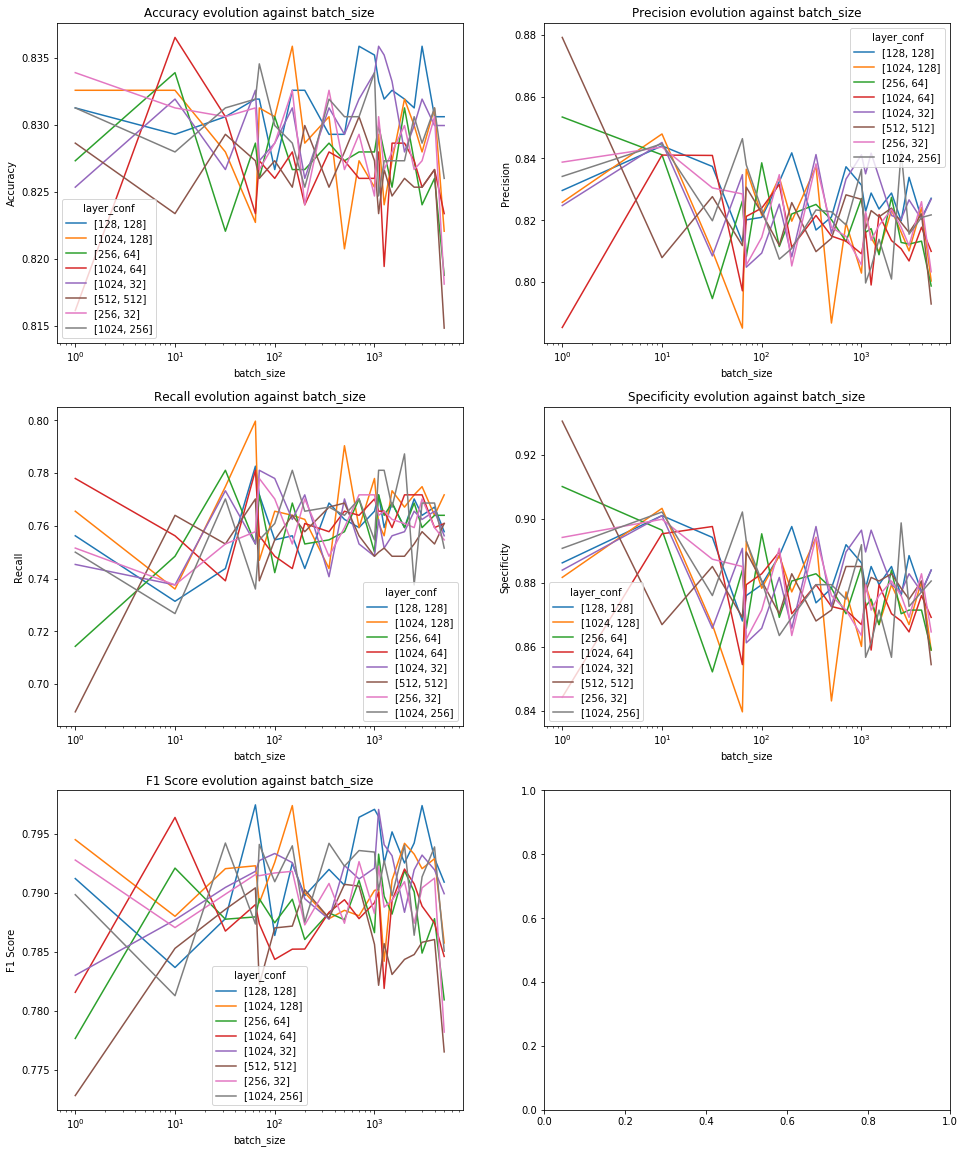

(<Figure size 1152x1440 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfe456fc50>,
       dtype=object))

In [9]:
plot_mlp_summ_performance(mlp_perf_metrics2, x_ax_param='batch_size', group_param='layer_conf', x_ax_log=True)

In [40]:
def plot_mlp_summ_avg_performance(perf_df, x_ax_param: str, group_param: str, x_ax_log=False):

    fig, ax = plt.subplots(3,2, figsize=(16,20))
    avg_group = perf_df.groupby(by=x_ax_param).agg(np.mean)
    max_group = perf_df.groupby(by=x_ax_param).agg(np.max)
    min_group = perf_df.groupby(by=x_ax_param).agg(np.min)

    # Plot accuracy
    ax[0, 0].plot(avg_group.index.values, avg_group['accuracy'].values, color='tab:blue')
    ax[0, 0].fill_between(avg_group.index.values, min_group['accuracy'].values, max_group['accuracy'].values,
                          color='lightblue')
    if x_ax_log:
        ax[0, 0].set_xscale('log')
    ax[0, 0].set_xlabel(x_ax_param)
    ax[0, 0].set_ylabel('Accuracy')
    ax[0, 0].set_title('Accuracy evolution against ' + x_ax_param)
    
    # Plot precision
    ax[0, 1].plot(avg_group.index.values, avg_group['precision'].values, color='tab:red')
    ax[0, 1].fill_between(avg_group.index.values, min_group['precision'].values, max_group['precision'].values,
                          color='coral')
    if x_ax_log:
        ax[0, 1].set_xscale('log')
    ax[0, 1].set_xlabel(x_ax_param)
    ax[0, 1].set_ylabel('Precision')
    ax[0, 1].set_title('Precision evolution against ' + x_ax_param)
    
    # Plot recall
    ax[1, 0].plot(avg_group.index.values, avg_group['recall'].values, color='tab:green')
    ax[1, 0].fill_between(avg_group.index.values, min_group['recall'].values, max_group['recall'].values,
                          color='lightgreen')
    if x_ax_log:
        ax[1, 0].set_xscale('log')
    ax[1, 0].set_xlabel(x_ax_param)
    ax[1, 0].set_ylabel('Recall')
    ax[1, 0].set_title('Recall evolution against ' + x_ax_param)
    
    # Plot specificity
    ax[1, 1].plot(avg_group.index.values, avg_group['specificity'].values, color='tab:orange')
    ax[1, 1].fill_between(avg_group.index.values, min_group['specificity'].values, max_group['specificity'].values,
                          color='orange')
    if x_ax_log:
        ax[1, 1].set_xscale('log')
    ax[1, 1].set_xlabel(x_ax_param)
    ax[1, 1].set_ylabel('Specificity')
    ax[1, 1].set_title('Specificity evolution against ' + x_ax_param)

    # Plot f1 score
    ax[2, 0].plot(avg_group.index.values, avg_group['f1_score'].values, color='tab:pink')
    ax[2, 0].fill_between(avg_group.index.values, min_group['f1_score'].values, max_group['f1_score'].values,
                          color='lightpink')
    if x_ax_log:
        ax[2, 0].set_xscale('log')
    ax[2, 0].set_xlabel(x_ax_param)
    ax[2, 0].set_ylabel('F1 Score')
    ax[2, 0].set_title('F1 Score evolution against ' + x_ax_param)
    
    plt.show()
    return fig, ax

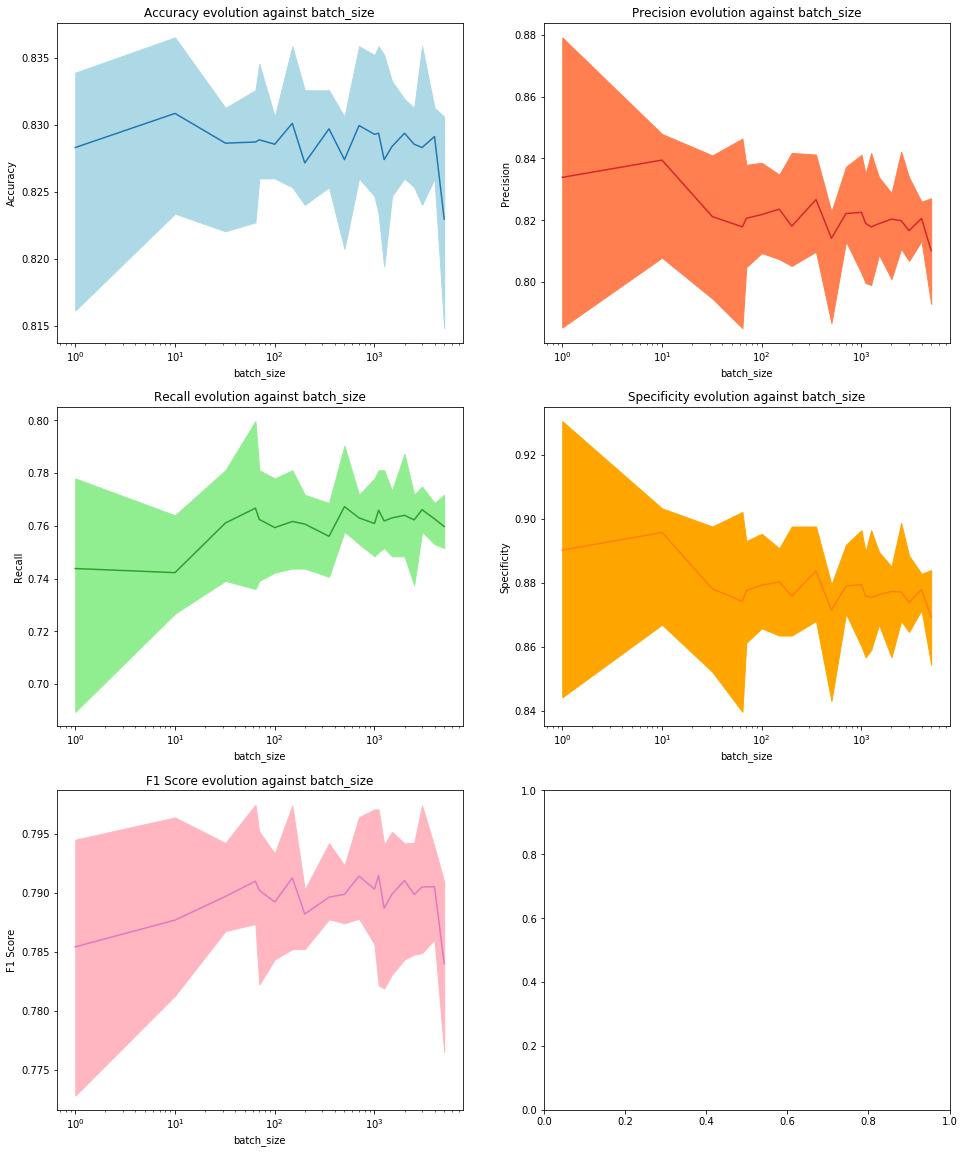

(<Figure size 1152x1440 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfe122a710>,
       dtype=object))

In [42]:
plot_mlp_summ_avg_performance(mlp_perf_metrics2, x_ax_param='batch_size', group_param='layer_conf', x_ax_log=True)

In [35]:
mlp_perf_metrics2.groupby(by='batch_size').agg(np.mean).index.values

array([1.00e+00, 1.00e+01, 3.20e+01, 6.40e+01, 7.00e+01, 1.00e+02,
       1.50e+02, 2.00e+02, 3.50e+02, 5.00e+02, 7.00e+02, 1.00e+03,
       1.10e+03, 1.25e+03, 1.50e+03, 2.00e+03, 2.50e+03, 3.00e+03,
       4.00e+03, 5.00e+03])

Metrics evolution respecting `batch_size` fit a disruptive schedule and no clear tendence is extracted at first.

Models with architectures [1024, 64], [1024, 128], [1024, 532], [128, 128] offer a balanced high-prediction over both classes for different `batch_size` values. 

#### Predict

Let's predict test set by using model with architecture [1024, 128] and `batch_size=150` which proves higher accuracy and f1-score on the rank

In [11]:
# Prepare model
mlp_model = build_MLP_network(input_dim=X_train_vect.shape[1],
                                      layers_dim=(1024, 128),
                                      dropout=0.1, lr=1e-4,
                                      seed=123456)
mlp_model.summary()

# Fit model using train test keeping 
hist = mlp_model.fit(X_train_vect, y_train.values,
                     batch_size=150,
                     epochs=300,
                      validation_split=0.1,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=5,
                                               restore_best_weights=True,
                                              min_delta=1e-7)])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1536)]            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1573888   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,705,217
Trainable params: 1,705,217
Non-trainable params: 0
___________________________________________________

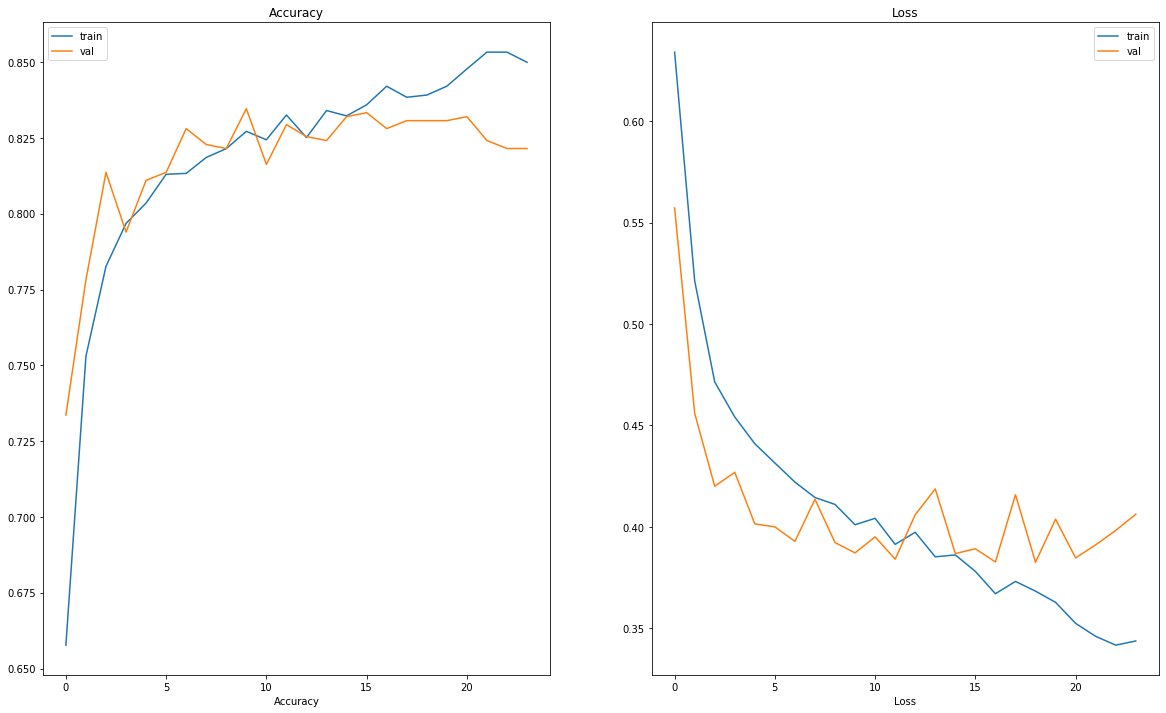

In [12]:
# Plot performance evolution metrics
fig, ax = plt.subplots(1,2, figsize=(20, 12))

# Accuracy
ax[0].plot(hist.history['acc'], label='train')
ax[0].plot(hist.history['val_acc'], label='val')
ax[0].set_xlabel('Epochs')
ax[0].set_xlabel('Accuracy')
ax[0].legend()
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(hist.history['loss'], label='train')
ax[1].plot(hist.history['val_loss'], label='val')
ax[1].set_xlabel('Epochs')
ax[1].set_xlabel('Loss')
ax[1].legend()
ax[1].set_title('Loss')

plt.show()

predict and save test

In [13]:
y_pred = mlp_model.predict(X_test_vect)
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0
y_pred = y_pred.squeeze().astype('int8')

In [14]:
# Merge index and labels in dataframe
pred_out = pd.DataFrame({'id':test['id'], 'target': y_pred})
pred_out.to_csv('BERT_trans_hyb_des_mlp_pred_out.csv', index=False)

Let's try to decrease `lr`parameter

In [15]:
# Prepare model
mlp_model2 = build_MLP_network(input_dim=X_train_vect.shape[1],
                                      layers_dim=(1024, 128),
                                      dropout=0.1, lr=1e-5,
                                      seed=123456)
mlp_model2.summary()

# Fit model using train test keeping 
hist2 = mlp_model2.fit(X_train_vect, y_train.values,
                     batch_size=150,
                     epochs=300,
                      validation_split=0.1,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=5,
                                               restore_best_weights=True,
                                              min_delta=1e-7)])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1536)]            0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1573888   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 1,705,217
Trainable params: 1,705,217
Non-trainable params: 0
_________________________________________________

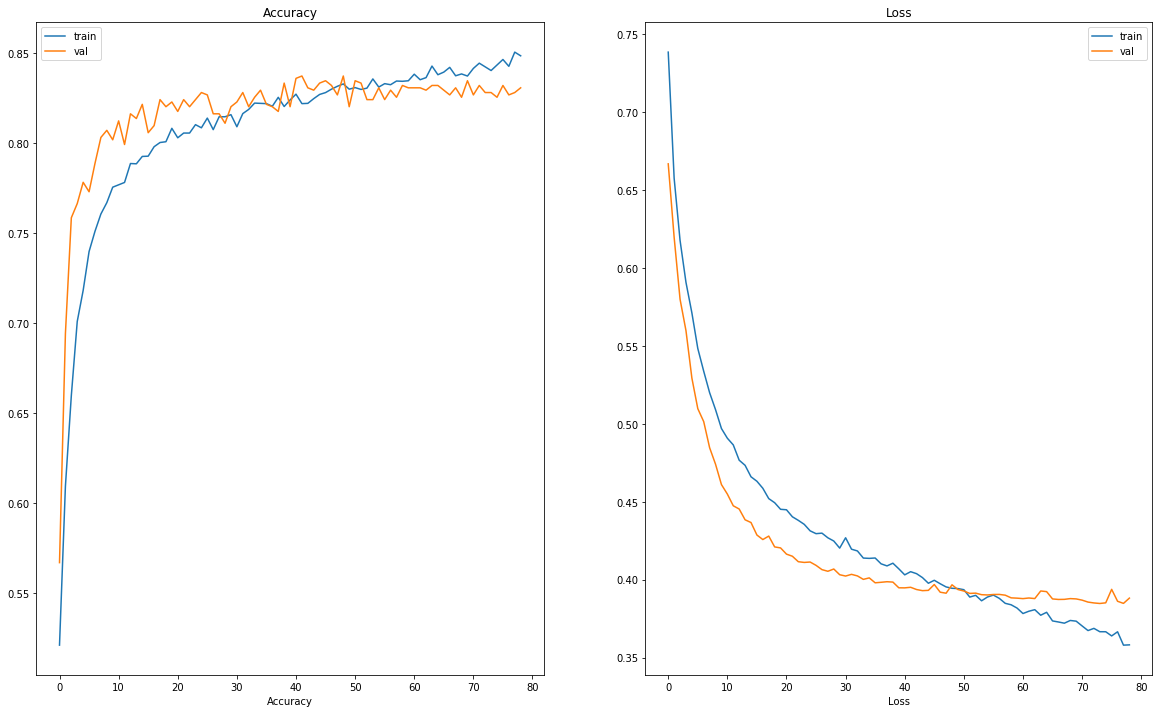

In [16]:
# Plot performance evolution metrics
fig, ax = plt.subplots(1,2, figsize=(20, 12))

# Accuracy
ax[0].plot(hist2.history['acc'], label='train')
ax[0].plot(hist2.history['val_acc'], label='val')
ax[0].set_xlabel('Epochs')
ax[0].set_xlabel('Accuracy')
ax[0].legend()
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(hist2.history['loss'], label='train')
ax[1].plot(hist2.history['val_loss'], label='val')
ax[1].set_xlabel('Epochs')
ax[1].set_xlabel('Loss')
ax[1].legend()
ax[1].set_title('Loss')

plt.show()

Predict again over the test set

In [17]:
y_pred2 = mlp_model2.predict(X_test_vect)
y_pred2[y_pred2 >= 0.5] = 1
y_pred2[y_pred2 < 0.5] = 0
y_pred2 = y_pred2.squeeze().astype('int8')

In [18]:
# Merge index and labels in dataframe
pred_out2 = pd.DataFrame({'id':test['id'], 'target': y_pred2})
pred_out2.to_csv('BERT_trans_hyb_des_mlp_pred_out2.csv', index=False)